In [6]:
# datapreprocessor.py

import pandas as pd
import numpy as np
from typing import List, Dict, Optional, Tuple, Any
import logging
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, SMOTEN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import joblib  # For saving/loading transformers
from inspect import signature  # For parameter validation in SMOTE
import inspect
from functools import wraps
import re
from feature_engine.selection import DropHighPSIFeatures
from datetime import datetime
from collections import defaultdict

def warp_sequence(seq: np.ndarray, path: list, target_length: int) -> np.ndarray:
    """
    Warp the given sequence to match the target length based on the DTW warping path.
    
    Args:
        seq: Original sequence, shape (n, features)
        path: Warping path from dtw_path (list of tuples)
        target_length: Desired sequence length (typically the reference length)
    
    Returns:
        aligned_seq: Warped sequence with shape (target_length, features)
    """
    aligned_seq = np.zeros((target_length, seq.shape[1]))
    # Create mapping: for each target index, collect corresponding indices from seq
    mapping = {t: [] for t in range(target_length)}
    for (i, j) in path:
        mapping[j].append(i)
    
    for t in range(target_length):
        indices = mapping[t]
        if indices:
            aligned_seq[t] = np.mean(seq[indices], axis=0)
        else:
            # If no alignment, reuse the previous value (or use interpolation)
            aligned_seq[t] = aligned_seq[t-1] if t > 0 else seq[0]
    return aligned_seq
    


class DataPreprocessor:
    def __init__(
        self,
        model_type: str,
        y_variable: List[str],
        ordinal_categoricals: List[str],
        nominal_categoricals: List[str],
        numericals: List[str],
        mode: str,  # 'train', 'predict', 'clustering'
        options: Optional[Dict] = None,
        debug: bool = False,
        normalize_debug: bool = False,
        normalize_graphs_output: bool = False,
        graphs_output_dir: str = './plots',
        transformers_dir: str = './transformers',
        time_series_sequence_mode: str = "pad",  # "set_window", "pad", "dtw"
        sequence_categorical: Optional[List[str]] = None,
        sub_sequence_categorical: Optional[List[str]] = None
    ):
        # --- Process and validate sequence grouping parameters ---
        self.sequence_categorical = list(sequence_categorical) if sequence_categorical else []
        self.sub_sequence_categorical = list(sub_sequence_categorical) if sub_sequence_categorical else []
        
        if set(self.sequence_categorical) & set(self.sub_sequence_categorical):
            conflicting = set(self.sequence_categorical) & set(self.sub_sequence_categorical)
            raise ValueError(f"Categorical conflict in {conflicting}. Top-level and sub-phase groups must form a strict hierarchy")

        # --- Basic attribute assignments ---
        self.model_type = model_type
        self.y_variable = y_variable
        self.ordinal_categoricals = ordinal_categoricals if ordinal_categoricals is not None else []
        self.nominal_categoricals = nominal_categoricals if nominal_categoricals is not None else []
        self.numericals = numericals if numericals is not None else []
        self.mode = mode.lower()
        if self.mode not in ['train', 'predict', 'clustering']:
            raise ValueError("Mode must be one of 'train', 'predict', or 'clustering'.")
        self.options = options or {}
        self.ts_outlier_method = self.options.get('handle_outliers', {}).get('time_series_method', 'median').lower()

        self.debug = debug
        self.normalize_debug = normalize_debug
        self.normalize_graphs_output = normalize_graphs_output
        self.graphs_output_dir = graphs_output_dir
        self.transformers_dir = transformers_dir

        # NEW: Read new option to drop the time column from input features.
        self.drop_time_column = self.options.get('drop_time_column', True)

        # --- Initialize logging ---
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.DEBUG if self.debug else logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
        handler.setFormatter(formatter)
        if not self.logger.handlers:
            self.logger.addHandler(handler)

        self.logger.debug(f"Initialized ordinal_categoricals: {self.ordinal_categoricals}")
        self.logger.debug(f"Initialized nominal_categoricals: {self.nominal_categoricals}")
        self.logger.debug(f"Initialized numericals: {self.numericals}")

        # --- Extract time series parameters from configuration ---
        time_series_config = self.options  # Use options directly
        self.time_series_enabled = time_series_config.get('enabled', False)
        self.time_column = time_series_config.get('time_column')
        self.step_size = time_series_config.get('step_size')
        self.ts_outlier_method = time_series_config.get('ts_outlier_handling_method', self.ts_outlier_method).lower()
        self.time_series_sequence_mode = time_series_sequence_mode.lower()

        # NEW: If using "set_window" mode, warn and ignore grouping parameters.
        if self.time_series_sequence_mode == "set_window":
            if self.sequence_categorical or self.sub_sequence_categorical:
                self.logger.warning(
                    "Sequence categorical and sub-sequence categorical parameters are ignored in 'set_window' mode. "
                    "They will not be used for grouping."
                )
                self.sequence_categorical = []
                self.sub_sequence_categorical = []

        # --- New parameters for sequence‐based horizon ---
        self.sequence_length = time_series_config.get('sequence_length', 379)  # default sequence length

        self.horizon_sequence_number = None  # Default value
        if self.time_series_sequence_mode in ["set_window"]:
            self.use_horizon_sequence = time_series_config.get('use_horizon_sequence', False)
            if self.use_horizon_sequence:
                self.horizon_sequence_number = time_series_config.get('horizon_sequence_number', 1)
                self.logger.info(f"Set_window mode: Using sequence-based horizon: {self.horizon_sequence_number} sequence(s) with each {self.sequence_length} steps")
                self.horizon = self.horizon_sequence_number * self.sequence_length
            else:
                self.horizon = time_series_config.get('horizon')
                self.logger.info(f"Set_window mode: Using fixed horizon: {self.horizon} step(s)")
        elif self.time_series_sequence_mode in ["dtw", "pad"]:
            # For dtw/pad modes, always use a dynamic horizon based on horizon_sequence_number * sequence_length.
            self.use_horizon_sequence = True
            self.horizon_sequence_number = time_series_config.get('horizon_sequence_number', 1)
            self.horizon = None  # Horizon will be updated dynamically later.
            self.logger.info("DTW/pad mode detected: Horizon will be updated dynamically as horizon_sequence_number * sequence_length.")
        else:
            raise ValueError(f"Unknown time series sequence mode: {self.time_series_sequence_mode}")

        # --- Store expected model shape (will be populated later) ---
        self.expected_model_shape = None
        self.actual_output_shape = None

        # --- Process sequence mode configurations (set_window, pad, dtw) ---
        sequence_modes_config = time_series_config.get('sequence_modes', {})
        if self.time_series_sequence_mode == "set_window":
            set_window_config = sequence_modes_config.get('set_window', {})
            self.window_size = set_window_config.get('window_size')
            self.max_sequence_length = set_window_config.get('max_sequence_length')
            if self.mode == 'train':
                if self.window_size is None or self.step_size is None:
                    raise ValueError("Both 'window_size' and 'step_size' must be provided for 'set_window' mode in training.")
            else:
                if self.window_size is None or self.step_size is None:
                    self.logger.warning("In predict mode, 'window_size' and/or 'step_size' are missing; these will be loaded from saved transformers if available.")
        elif self.time_series_sequence_mode == "pad":
            pad_config = sequence_modes_config.get('pad', {})
            self.padding_side = pad_config.get('padding_side', 'post')
            self.pad_threshold = pad_config.get('pad_threshold', 0.9)
            self.max_sequence_length = None
        elif self.time_series_sequence_mode == "dtw":
            dtw_config = sequence_modes_config.get('dtw', {})
            self.use_dtw = dtw_config.get('use_dtw', True)
            self.reference_sequence = dtw_config.get('reference_sequence', 'max')
            self.dtw_threshold = dtw_config.get('dtw_threshold', 0.9)
            self.max_sequence_length = None
        else:
            raise ValueError(f"Unknown time series sequence mode: {self.time_series_sequence_mode}")

        self.max_phase_distortion = self.options.get('max_phase_distortion', 0.9)
        self.max_length_variance = self.options.get('max_length_variance', 5)

        if self.sequence_categorical and self.sub_sequence_categorical:
            overlap = set(self.sequence_categorical) & set(self.sub_sequence_categorical)
            if overlap:
                raise ValueError(f"Overlapping grouping columns: {overlap}. Top-level and sub-phase groups must be distinct")

        # --- Determine model category ---
        self.hierarchical_categories = {}
        model_type_lower = self.model_type.lower()
        if any(kw in model_type_lower for kw in ['lstm', 'rnn', 'time series']):
            self.model_category = 'time_series'
        else:
            self.model_category = self.map_model_type_to_category()

        self.categorical_indices = []
        if self.model_category == 'unknown':
            self.logger.error(f"Model category for '{self.model_type}' is unknown. Check your configuration.")
            raise ValueError(f"Model category for '{self.model_type}' is unknown. Check your configuration.")
        if self.mode in ['train', 'predict']:
            if not self.y_variable:
                raise ValueError("Target variable 'y_variable' must be specified for supervised models in train/predict mode.")
        elif self.mode == 'clustering':
            self.y_variable = []

        self.time_step = self.options.get('time_step', 1/60) if self.options else 1/60

        # Initialize additional variables, transformers, etc.
        self.scaler = None
        self.transformer = None
        self.ordinal_encoder = None
        self.nominal_encoder = None
        self.preprocessor = None
        self.smote = None
        all_features = []
        all_features.extend(self.ordinal_categoricals)
        all_features.extend(self.nominal_categoricals)
        all_features.extend(self.numericals)
        self.feature_reasons = {col: '' for col in all_features}
        self.preprocessing_steps = []
        self.normality_results = {}
        self.features_to_transform = []
        self.nominal_encoded_feature_names = []
        self.final_feature_order = []

        # Additional initialization for clustering
        self.cluster_transformers = {}
        self.cluster_model = None
        self.cluster_labels = None
        self.silhouette_score = None

        self.imbalance_threshold = self.options.get('smote_recommendation', {}).get('imbalance_threshold', 0.1)
        self.noise_threshold = self.options.get('smote_recommendation', {}).get('noise_threshold', 0.1)
        self.overlap_threshold = self.options.get('smote_recommendation', {}).get('overlap_threshold', 0.1)
        self.boundary_threshold = self.options.get('smote_recommendation', {}).get('boundary_threshold', 0.1)

        self.pipeline = None

        # (Re)initialize logging handler if necessary
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.DEBUG if self.debug else logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
        handler.setFormatter(formatter)
        if not self.logger.handlers:
            self.logger.addHandler(handler)

        all_features = []
        all_features.extend(self.ordinal_categoricals)
        all_features.extend(self.nominal_categoricals)
        all_features.extend(self.numericals)
        self.feature_reasons = {col: '' for col in all_features}
        if self.model_category == 'clustering':
            self.feature_reasons['all_numericals'] = ''

        # --- Automatically load transformers if in prediction mode ---
        if self.mode == 'predict' and self.transformers_dir:
            try:
                self.logger.info(f"Prediction mode detected. Automatically loading transformers from '{self.transformers_dir}'")
                loaded_transformers = self.load_transformers()
                self.logger.info(f"Successfully loaded {len(loaded_transformers)} transformer components for prediction")
            except Exception as e:
                self.logger.warning(f"Failed to automatically load transformers: {e}")
                self.logger.warning("Will attempt to load transformers again during data processing")



    def get_debug_flag(self, flag_name: str) -> bool:
        """
        Retrieve the value of a specific debug flag from the options.
        Args:
            flag_name (str): The name of the debug flag.
        Returns:
            bool: The value of the debug flag.
        """
        return self.options.get(flag_name, False)

    def _log(self, message: str, step: str, level: str = 'info'):
        """
        Internal method to log messages based on the step-specific debug flags.
        
        Args:
            message (str): The message to log.
            step (str): The preprocessing step name.
            level (str): The logging level ('info', 'debug', etc.).
        """
        debug_flag = self.get_debug_flag(f'debug_{step}')
        if debug_flag:
            if level == 'debug':
                self.logger.debug(message)
            elif level == 'info':
                self.logger.info(message)
            elif level == 'warning':
                self.logger.warning(message)
            elif level == 'error':
                self.logger.error(message)

    def map_model_type_to_category(self) -> str:
        """
        Map the model_type string to a predefined category based on keywords.

        Returns:
            str: The model category ('classification', 'regression', 'clustering', etc.).
        """
        classification_keywords = ['classifier', 'classification', 'logistic', 'svm', 'support vector machine', 'knn', 'neural network']
        regression_keywords = ['regressor', 'regression', 'linear', 'knn', 'neural network']  # Removed 'svm'
        clustering_keywords = ['k-means', 'clustering', 'dbscan', 'kmodes', 'kprototypes']

        model_type_lower = self.model_type.lower()

        for keyword in classification_keywords:
            if keyword in model_type_lower:
                return 'classification'

        for keyword in regression_keywords:
            if keyword in model_type_lower:
                return 'regression'

        for keyword in clustering_keywords:
            if keyword in model_type_lower:
                return 'clustering'

        return 'unknown'

    def filter_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        step_name = "filter_columns"
        self.logger.info(f"Step: {step_name}")

        # Combine all feature lists from configuration
        desired_features = self.numericals + self.ordinal_categoricals + self.nominal_categoricals

        # For time series models, ensure the time column is included
        if self.model_category == 'time_series' and self.time_column:
            if self.time_column not in df.columns:
                self.logger.error(f"Time column '{self.time_column}' not found in input data.")
                raise ValueError(f"Time column '{self.time_column}' not found in the input data.")
            if self.time_column not in desired_features:
                desired_features.append(self.time_column)

        # NEW: If drop_time_column is True, remove the time column from the desired features.
        if self.drop_time_column and self.time_column in desired_features:
            self.logger.info(f"Dropping time column '{self.time_column}' from desired features as per configuration.")
            desired_features.remove(self.time_column)

        # *** NEW: Auto-include sequence grouping columns ***
        # Ensure that any column listed in sequence_categorical is added to desired_features if present.
        for col in self.sequence_categorical:
            if col not in desired_features and col in df.columns:
                desired_features.append(col)
                self.logger.debug(f"Auto-added sequence column '{col}' to desired features")

        # Debug log: report target variable info
        self.logger.debug(f"y_variable provided: {self.y_variable}")
        if self.y_variable and all(col in df.columns for col in self.y_variable):
            self.logger.debug(f"First value in target column(s): {df[self.y_variable].iloc[0].to_dict()}")

        # For 'train' mode, ensure the target variable is present and excluded from features
        if self.mode == 'train':
            if not all(col in df.columns for col in self.y_variable):
                missing_y = [col for col in self.y_variable if col not in df.columns]
                self.logger.error(f"Target variable(s) {missing_y} not found in the input data.")
                raise ValueError(f"Target variable(s) {missing_y} not found in the input data.")
            desired_features = [col for col in desired_features if col not in self.y_variable]
            filtered_df = df[desired_features + self.y_variable].copy()
        else:
            filtered_df = df[desired_features].copy()

        # Check that all desired features are present in the input DataFrame
        missing_features = [col for col in desired_features if col not in df.columns]
        if missing_features:
            self.logger.error(f"The following required features are missing in the input data: {missing_features}")
            raise ValueError(f"The following required features are missing in the input data: {missing_features}")

        # Additional numeric type check for expected numeric columns
        for col in self.numericals:
            if col in filtered_df.columns and not np.issubdtype(filtered_df[col].dtype, np.number):
                raise TypeError(f"Numerical column '{col}' has non-numeric dtype {filtered_df[col].dtype}")

        self.logger.info(f"✅ Filtered DataFrame to include only specified features. Shape: {filtered_df.shape}")
        self.logger.debug(f"Selected Features: {desired_features}")
        if self.mode == 'train':
            self.logger.debug(f"Retained Target Variable(s): {self.y_variable}")

        return filtered_df





    def _group_top_level(self, data: pd.DataFrame):
        """
        Group the data based on top-level sequence categorical variables.
        Returns the grouped DataFrames (without converting them to NumPy arrays)
        to ensure that subsequent processing (such as sub-phase segmentation) has access
        to DataFrame methods like .groupby and .columns.
        """
        if not self.sequence_categorical:
            return [('default_group', data)]
        
        groups = data.groupby(self.sequence_categorical)
        self.logger.debug(f"Group keys: {list(groups.groups.keys())}")
        
        validated_groups = []
        for name, group in groups:
            try:
                self.logger.debug(f"Group '{name}' type: {type(group)}, Shape: {group.shape if hasattr(group, 'shape') else 'N/A'}")
            except Exception as e:
                self.logger.error(f"Error obtaining shape for group {name}: {e}")
            if isinstance(group, pd.DataFrame):
                # *** FIX: Return the DataFrame (not group.values) so that it retains the .columns attribute ***
                validated_groups.append((name, group))
            else:
                self.logger.warning(f"Unexpected group type {type(group)} for group {name}")
        return validated_groups


    
    @staticmethod
    def normalize_phase_key(key: str) -> str:
        """
        General-purpose phase name normalization for any domain.
        This method removes sport-specific mappings and applies a generic set of transformations.
        """
        # Ensure the key is a string.
        if not isinstance(key, str):
            key = str(key)
        
        # Standard normalization: trim, lowercase, and replace various hyphen/space characters.
        normalized = (
            key.strip().lower()
            .replace(" - ", "_")  # Replace spaced hyphens with underscore.
            .replace("-", "_")    # Replace hyphens with underscore.
            .replace(" ", "_")    # Replace spaces with underscore.
            .replace("‐", "")     # Remove various unicode hyphen variants.
            .replace("‑", "")
            .replace("–", "")
            .replace("—", "")
        )
        
        # Collapse multiple underscores and trim any leading/trailing underscores.
        normalized = re.sub(r'_+', '_', normalized).strip('_')
        
        # Optional: Apply generic domain-agnostic abbreviations.
        common_abbreviations = {
            'phase': 'ph',
            'stage': 'st',
            'step': 'sp',
        }
        for full, abbrev in common_abbreviations.items():
            # Replace whole word matches.
            normalized = re.sub(rf'\b{full}\b', abbrev, normalized)
        
        return normalized
    
    def validate_phase_coverage(self, data: pd.DataFrame) -> dict:
        """
        Generic phase validation suitable for any domain.
        This method checks for a generic 'phase' column, logs the raw counts,
        applies normalization to each phase value, and aggregates counts accordingly.
        """
        phase_col = 'phase'  # This could be made configurable if needed.
        if phase_col not in data.columns:
            self.logger.warning(f"Phase column '{phase_col}' not found")
            return {}
        
        raw_counts = data[phase_col].value_counts()
        self.logger.info(f"Raw phase counts:\n{raw_counts}")
        
        # Normalize phase names and aggregate counts.
        normalized_counts = defaultdict(int)
        for phase, count in raw_counts.items():
            norm_phase = self.normalize_phase_key(phase)
            normalized_counts[norm_phase] += count

        self.logger.info(f"Normalized phase distribution:\n{dict(normalized_counts)}")
        return dict(normalized_counts)


        
    @staticmethod
    def safe_array_conversion(data):
        """
        Convert input data to a NumPy array if it is not already.
        Handles both structured and unstructured arrays.
        Raises a TypeError if the input data is a dictionary.
        """
        if isinstance(data, dict):
            raise TypeError("Input data is a dict. Expected array-like input.")
        if isinstance(data, np.ndarray):
            if data.dtype.names:
                # For structured arrays, view as float32 and reshape to combine fields.
                return data.view(np.float32).reshape(data.shape + (-1,))
            return data
        elif hasattr(data, 'values'):
            arr = data.values
            if arr.dtype.names:
                return arr.view(np.float32).reshape(arr.shape + (-1,))
            return arr
        else:
            return np.array(data)
            
    def validate_group_phases(self, group_key, group_data):
        """
        Validate the phases for a given group by logging:
        - The raw phases found in the group's 'pitch_phase_biomech' column.
        - The normalized phases after applying normalization.
        - The required phases as per the phase order.
        
        This function aids in tracing how the phase values are processed.
        
        Args:
            group_key: Identifier for the group.
            group_data (pd.DataFrame): The group data containing phase information.
        """
        if 'pitch_phase_biomech' not in group_data.columns:
            self.logger.warning(f"Group {group_key} does not contain 'pitch_phase_biomech' column for phase validation.")
            return
        raw_phases = group_data['pitch_phase_biomech'].unique()
        self.logger.debug(f"Raw phases for group {group_key}: {raw_phases}")
        
        normalized_phases = [self.normalize_phase_key(p) for p in raw_phases if isinstance(p, str)]
        self.logger.debug(f"Normalized phases for group {group_key}: {normalized_phases}")
        
        required_phases = self.get_phase_order()
        self.logger.debug(f"Required phases: {required_phases}")


    def _segment_subphases(self, group_data: pd.DataFrame, skip_min_samples=False, context=None):
        """
        Segment a group's data into sub-phases based on the secondary grouping.
        For each phase, converts the data to a numeric NumPy array and maps it with a normalized phase key.
        
        Adaptive minimum sample requirement:
        - In prediction mode, set MIN_PHASE_SAMPLES = 2 (more lenient).
        - Otherwise, use 2 (or 1 if skip_min_samples is True).
        
        Args:
            group_data (pd.DataFrame): Data for one group.
            skip_min_samples (bool): If True, lower the sample threshold.
            context (Optional[dict]): Additional context information for debugging.
        
        Returns:
            dict: Mapping from normalized phase keys to tuples (original key, numeric array).
        """
        context_str = ""
        if context:
            group_key = context.get('group_key', 'unknown')
            context_str = f" [Group: {group_key}]"
        
        if not self.sub_sequence_categorical:
            if self.numericals:
                group_data = group_data[[col for col in group_data.columns if col in self.numericals]]
            self.logger.debug(f"No secondary grouping, returning default phase{context_str}")
            return {"default_phase": ("default_phase", group_data.values)}
        
        if 'pitch_phase_biomech' in group_data.columns:
            unique_phases = group_data['pitch_phase_biomech'].unique()
            self.logger.debug(f"Raw phases in group{context_str}: {unique_phases}")
            raw_phase_counts = group_data['pitch_phase_biomech'].value_counts().to_dict()
            self.logger.debug(f"Phase sample counts{context_str}: {raw_phase_counts}")
            for phase in unique_phases:
                norm_value = self.normalize_phase_key(str(phase))
                self.logger.debug(f"Normalization test{context_str}: '{phase}' → '{norm_value}'")
        
        phase_groups = list(group_data.groupby(self.sub_sequence_categorical))
        subphases = {}
        MIN_PHASE_SAMPLES = 2 if self.mode == 'predict' else (2 if not skip_min_samples else 1)
        
        if self.time_column and self.time_column in group_data.columns:
            try:
                self._validate_timestamps(group_data)
            except Exception as e:
                self.logger.warning(f"Timestamp validation error{context_str}: {e}")
        
        for phase_key, phase_df in phase_groups:
            stable_key = "|".join(map(str, phase_key)) if isinstance(phase_key, tuple) else str(phase_key)
            normalized_key = DataPreprocessor.normalize_phase_key(stable_key)
            self.logger.debug(f"Sub-phase raw key{context_str} '{stable_key}' normalized to: '{normalized_key}'")
                                    
            if not isinstance(phase_df, (pd.DataFrame, np.ndarray)):
                self.logger.error(f"Invalid type {type(phase_df)} for phase '{stable_key}'{context_str}. Skipping.")
                continue

            phase_length = len(phase_df)
            self.logger.debug(f"Phase '{stable_key}'{context_str} (normalized: '{normalized_key}') length: {phase_length}")

            if phase_length < MIN_PHASE_SAMPLES:
                self.logger.warning(f"Skipping short phase '{stable_key}'{context_str} (length {phase_length} < {MIN_PHASE_SAMPLES})")
                continue

            if isinstance(phase_df, pd.DataFrame):
                numeric_phase_df = phase_df[[col for col in phase_df.columns if col in self.numericals]] if self.numericals else phase_df
                try:
                    numeric_phase_array = self.safe_array_conversion(numeric_phase_df)
                except Exception as e:
                    self.logger.error(f"Array conversion failed for phase '{stable_key}'{context_str}: {e}")
                    continue
            elif isinstance(phase_df, np.ndarray):
                numeric_phase_array = phase_df
            else:
                self.logger.error(f"Unexpected type {type(phase_df)} for phase '{stable_key}'{context_str}. Skipping.")
                continue

            if numeric_phase_array.ndim == 1:
                numeric_phase_array = numeric_phase_array.reshape(-1, 1)
                self.logger.debug(f"Phase '{stable_key}'{context_str} reshaped to 2D: {numeric_phase_array.shape}")

            subphases[normalized_key] = (stable_key, numeric_phase_array)
        
        self.logger.debug(f"Completed segmentation. Normalized phase keys obtained: {list(subphases.keys())}")
        expected_set = set(self.get_phase_order(context=context))
        self.logger.debug(f"Expected phase keys: {expected_set}")
        
        missing_phases = expected_set - set(subphases.keys())
        if missing_phases:
            self.logger.warning(f"Missing expected phases after segmentation{context_str}: {missing_phases}")
            for phase in missing_phases:
                original_phases = [p for p in unique_phases if hasattr(p, 'lower') and self.normalize_phase_key(str(p)) == phase]
                if original_phases:
                    self.logger.warning(f"Phase '{phase}'{context_str} was present as {original_phases} but filtered out")
                    for orig_phase in original_phases:
                        phase_data = group_data[group_data['pitch_phase_biomech'] == orig_phase]
                        self.logger.warning(f"  - Raw phase '{orig_phase}' had {len(phase_data)} samples (min required: {MIN_PHASE_SAMPLES})")
                else:
                    self.logger.warning(f"Phase '{phase}'{context_str} not found in raw data")
        
        if not subphases:
            self.logger.error("No valid subphases detected in this group.")
            raise ValueError("Subphase segmentation produced an empty dictionary.")
        return subphases






    def _validate_timestamps(self, phase_data: pd.DataFrame):
        """
        Validate that timestamps in phase_data have no large discontinuities (>1 second gap).
        Logs a warning if a gap is detected.
        """
        time_col = self.time_column
        if time_col not in phase_data.columns:
            return
        diffs = phase_data[time_col].diff().dropna()
        diffs_seconds = diffs.dt.total_seconds()
        if (diffs_seconds  > 1.0).any():
            gap_loc = diffs_seconds .idxmax()
            self.logger.warning(
                f"Timestamp jump in group {getattr(phase_data, 'name', 'unknown')}: {diffs_seconds [gap_loc]:.2f}s gap at index {gap_loc}"
            )



    @staticmethod
    def pad_sequence(seq: np.ndarray, target_length: int) -> np.ndarray:
        """
        Pad or truncate the given sequence to match the target length.
        Ensures that the input is a 2D array. For a 1D input, reshapes it to (-1, 1).
        A minimum target_length of 5 is enforced to avoid degenerate sequences.
        """
        seq = np.array(seq)
        if seq.ndim == 1:
            seq = seq.reshape(-1, 1)  # Ensure the array is 2D
        current_length = seq.shape[0]
        target_length = max(target_length, 5)  # Enforce a minimum target length of 5
        if current_length >= target_length:
            return seq[:target_length]
        else:
            pad_width = target_length - current_length
            padding = np.zeros((pad_width, seq.shape[1]))
            return np.concatenate([seq, padding], axis=0)

    @staticmethod
    def dtw_compute(s1: np.ndarray, s2: np.ndarray, return_path: bool = True, window: Optional[int] = None) -> Tuple[float, Optional[List[Tuple[int, int]]]]:
        """
        Compute the DTW distance between two sequences with an optional window constraint.
        Can return both the DTW distance and the warping path if requested.
        
        Args:
            s1 (np.ndarray): First sequence (shape: n x features).
            s2 (np.ndarray): Second sequence (shape: m x features).
            return_path (bool): If True, return the warping path; otherwise, only the distance.
            window (Optional[int]): Optional window constraint for computation.
            
        Returns:
            Tuple: (dtw_distance (float), warping path (list of tuples) or None)
        """
        n, m = len(s1), len(s2)
        cost = np.full((n + 1, m + 1), np.inf)
        cost[0, 0] = 0

        # Build the cost matrix
        for i in range(1, n + 1):
            if window is not None:
                window_start = max(1, i - window)
                window_end = min(m + 1, i + window + 1)
            else:
                window_start = 1
                window_end = m + 1
            for j in range(window_start, window_end):
                dist = np.linalg.norm(s1[i - 1] - s2[j - 1])
                cost[i, j] = dist + min(cost[i - 1, j], cost[i, j - 1], cost[i - 1, j - 1])
        
        dtw_distance = cost[n, m]
        
        if not return_path:
            return dtw_distance, None

        # Backtracking to compute the optimal warping path
        i, j = n, m
        path = []
        while i > 0 and j > 0:
            path.append((i - 1, j - 1))
            directions = [cost[i - 1, j], cost[i, j - 1], cost[i - 1, j - 1]]
            min_index = np.argmin(directions)
            if min_index == 0:
                i -= 1
            elif min_index == 1:
                j -= 1
            else:
                i -= 1
                j -= 1
        path.reverse()
        return dtw_distance, path


    def _align_phase(self, phase_data, target_length: int, phase_name: str, context=None) -> Tuple[np.ndarray, bool]:
        """
        Align a sub-phase's sequence to a target length using DTW (if enabled) or padding.
        Enhanced to return a success flag instead of raising exceptions for excessive distortion.
        
        Args:
            phase_data: The phase data to align.
            target_length (int): Target length to align to.
            phase_name (str): Name of the phase (for logging).
            context (Optional[dict]): Optional context information for debugging.
                
        Returns:
            Tuple[np.ndarray, bool]: (Aligned phase data, success flag)
                If success is False, the first element will be None.
        """
        phase_array = self.safe_array_conversion(phase_data)
        
        context_str = ""
        if context:
            group_key = context.get('group_key', 'unknown')
            context_str = f" [Group: {group_key}, Phase: {phase_name}]"
        
        self.logger.debug(f"Aligning phase '{phase_name}'{context_str} with input type {type(phase_data)} and shape {phase_array.shape}")

        if phase_array.ndim == 1:
            phase_array = phase_array.reshape(-1, 1)
            self.logger.debug(f"Phase '{phase_name}'{context_str} was 1D and reshaped to {phase_array.shape}")

        current_length = phase_array.shape[0]
        if phase_array.ndim != 2:
            self.logger.error(f"Invalid input shape {phase_array.shape} - expected a 2D array{context_str}")
            return None, False  # Return failure without raising exception

        if not np.issubdtype(phase_array.dtype, np.number):
            self.logger.warning(f"Non-numeric dtype detected: {phase_array.dtype}. Converting to np.float32.{context_str}")
            try:
                phase_array = phase_array.astype(np.float32)
            except Exception as e:
                self.logger.error(f"Failed conversion to float32: {e}{context_str}")
                return None, False  # Return failure without raising exception

        distortion = abs(current_length - target_length) / target_length

        if self.time_series_sequence_mode == "dtw":
            threshold = self.dtw_threshold
            mode_used = "dtw"
        elif self.time_series_sequence_mode == "pad":
            threshold = self.pad_threshold
            mode_used = "pad"
        else:
            self.logger.error(f"Unsupported time_series_sequence_mode: '{self.time_series_sequence_mode}'{context_str}")
            return None, False  # Return failure without raising exception

        self.logger.debug(f"[{mode_used.upper()} Distortion Analysis]{context_str} Phase '{phase_name}': raw length {current_length}, "
                        f"target {target_length}, distortion {distortion:.1%}, threshold: {threshold:.1%}")

        if not hasattr(self, 'distortion_stats'):
            self.distortion_stats = []
        self.distortion_stats.append({
            'phase_name': phase_name,
            'current_length': current_length,
            'target_length': target_length,
            'distortion': distortion,
            'mode': mode_used,
            'threshold': threshold,
            'group_key': context.get('group_key', 'unknown') if context else 'unknown',
            'timestamp': datetime.now()
        })

        # Return failure instead of raising an exception for excessive distortion
        if distortion > threshold:
            self.logger.warning(f"Phase '{phase_name}'{context_str} has excessive {mode_used} distortion: "
                                f"{distortion:.1%} exceeds threshold {threshold:.1%}. Current length: {current_length}, "
                                f"target: {target_length}")
            return None, False

        try:
            if self.time_series_sequence_mode == "dtw":
                distance, path = DataPreprocessor.dtw_compute(phase_array, phase_array, return_path=True)
                aligned_seq = warp_sequence(phase_array, path, target_length)
            elif self.time_series_sequence_mode == "pad":
                aligned_seq = self.pad_sequence(phase_array, target_length)

            if aligned_seq.shape[0] != target_length:
                self.logger.error(f"Phase '{phase_name}'{context_str} alignment resulted in {aligned_seq.shape[0]} steps (expected {target_length}).")
                return None, False
        except Exception as e:
            self.logger.error(f"Alignment error for phase '{phase_name}'{context_str}: {e}")
            return None, False

        self.logger.debug(f"Phase '{phase_name}'{context_str} aligned successfully to shape {aligned_seq.shape}")
        return aligned_seq, True



    def create_sequences(self, X: np.ndarray, y: np.ndarray) -> Tuple[Any, Any]:
        """
        Create sequences from the input data based on the specified time series sequence mode.
        
        For "set_window" mode, it creates sliding windows with a specified window_size and horizon.
        For other modes (e.g. "dtw", "pad"), it returns the full sequences.
        
        Returns:
            Tuple: (X_seq_array, y_seq_array) as NumPy arrays.
        """
        X_seq, y_seq = [], []
        
        if self.time_series_sequence_mode == "set_window":
            # Sliding window approach: build sequences using window_size, step_size, and horizon.
            for i in range(0, len(X) - self.window_size - self.horizon + 1, self.step_size):
                seq_X = X[i:i+self.window_size]
                seq_y = y[i+self.window_size:i+self.window_size+self.horizon]
                # If a maximum sequence length is defined, pad the sequence if needed.
                if self.max_sequence_length and seq_X.shape[0] < self.max_sequence_length:
                    pad_width = self.max_sequence_length - seq_X.shape[0]
                    seq_X = np.pad(seq_X, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
                X_seq.append(seq_X)
                y_seq.append(seq_y)
        
        elif self.time_series_sequence_mode in ["dtw", "pad"]:
            # For these modes, the full sequence is processed directly.
            X_seq = X
            y_seq = y
        
        else:
            raise ValueError(f"Unsupported time_series_sequence_mode: {self.time_series_sequence_mode}")
        
        # --- New Debug Logging ---
        # Convert lists to NumPy arrays (if not already) and log their shapes and data types.
        X_seq_array = np.array(X_seq)
        y_seq_array = np.array(y_seq)
        self.logger.debug(f"X_seq_array shape: {X_seq_array.shape}, dtype: {X_seq_array.dtype}")
        self.logger.debug(f"y_seq_array shape: {y_seq_array.shape}, dtype: {y_seq_array.dtype}")
        
        return X_seq_array, y_seq_array



    def split_dataset(
        self,
        X: pd.DataFrame,
        y: Optional[pd.Series] = None,
        split_ratio: float = 0.2,
        time_split_column: Optional[str] = None,
        time_split_value: Optional[Any] = None
    ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.Series]]:
        """
        Split the dataset into training and testing sets while retaining original indices.
        Supports both ratio-based splitting and time-based splitting.
        If the resulting test set is empty, uses a fallback: a portion of train data becomes test data.
        """
        step_name = "split_dataset"
        self.logger.info("Step: Split Dataset into Train and Test")

        # Debug log shapes
        self._log(f"Before Split - X shape: {X.shape}", step_name, 'debug')
        if y is not None:
            self._log(f"Before Split - y shape: {y.shape}", step_name, 'debug')
        else:
            self._log("Before Split - y is None", step_name, 'debug')

        # Determine splitting method based on mode and model_category.
        if self.mode == 'train' and self.model_category in ['classification', 'regression', 'time_series']:
            if time_split_column and time_split_value:
                if time_split_column not in X.columns:
                    raise ValueError(f"Time split column '{time_split_column}' not found in the dataset.")
                self._log(f"Performing time-based split on '{time_split_column}' with value {time_split_value}", step_name, 'debug')
                train_mask = X[time_split_column] <= time_split_value
                test_mask = X[time_split_column] > time_split_value
                X_train = X[train_mask].copy()
                X_test = X[test_mask].copy()
                if X_test.empty:
                    self.logger.warning("Test set is empty after time-based split. Using a portion of train data as test.")
                    # Fallback: use 20% of train data (or at least one row)
                    split_idx = int(len(X) * 0.8)
                    X_train = X.iloc[:split_idx].copy()
                    X_test = X.iloc[split_idx:].copy()
                if y is not None:
                    y_train = y[train_mask].copy()
                    y_test = y[test_mask].copy() if not X_test.empty else pd.Series(dtype=y.dtype)
                else:
                    y_train, y_test = None, None
                self._log("Performed time-based split.", step_name, 'debug')
            else:
                # For time series, perform chronological split
                if self.model_category == 'time_series':
                    self._log(f"Using chronological split for time series with ratio {split_ratio}", step_name, 'debug')
                    if self.time_column and self.time_column in X.columns:
                        X = X.sort_values(by=self.time_column)
                        if y is not None:
                            y = y.loc[X.index]
                    split_idx = int((1 - split_ratio) * len(X))
                    X_train = X.iloc[:split_idx].copy()
                    X_test = X.iloc[split_idx:].copy()
                    if y is not None:
                        y_train = y.iloc[:split_idx].copy()
                        y_test = y.iloc[split_idx:].copy()
                    else:
                        y_train, y_test = None, None
                    self._log(f"Performed chronological split at index {split_idx}", step_name, 'debug')
                elif self.model_category == 'classification':
                    stratify = y if self.options.get('split_dataset', {}).get('stratify_for_classification', False) else None
                    random_state = self.options.get('split_dataset', {}).get('random_state', 42)
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, 
                        test_size=split_ratio,
                        stratify=stratify, 
                        random_state=random_state
                    )
                    self._log(f"Performed stratified split for classification with ratio {split_ratio}.", step_name, 'debug')
                elif self.model_category == 'regression':
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, 
                        test_size=split_ratio,
                        random_state=self.options.get('split_dataset', {}).get('random_state', 42)
                    )
                    self._log(f"Performed random split for regression with ratio {split_ratio}.", step_name, 'debug')
        else:
            X_train = X.copy()
            X_test = None
            y_train = y.copy() if y is not None else None
            y_test = None
            self.logger.info(f"No splitting performed for mode '{self.mode}' or model category '{self.model_category}'.")

        self.preprocessing_steps.append("Split Dataset into Train and Test")

        self._log(f"After Split - X_train shape: {X_train.shape}", step_name, 'debug')
        if X_test is not None:
            self._log(f"After Split - X_test shape: {X_test.shape}", step_name, 'debug')
        else:
            self._log("After Split - X_test is None", step_name, 'debug')
        
        if y_train is not None:
            self._log(f"After Split - y_train shape: {y_train.shape}", step_name, 'debug')
        if y_test is not None:
            self._log(f"After Split - y_test shape: {y_test.shape}", step_name, 'debug')

        # Keep indices aligned
        if X_test is not None and y_test is not None:
            X_test = X_test.sort_index()
            y_test = y_test.sort_index()
            self.logger.debug("Sorted X_test and y_test by index for alignment.")

        if y_train is not None and not X_train.index.equals(y_train.index):
            self.logger.warning("X_train and y_train indices are misaligned.")
        if X_test is not None and y_test is not None and not X_test.index.equals(y_test.index):
            self.logger.warning("X_test and y_test indices are misaligned.")

        return X_train, X_test, y_train, y_test




    def handle_missing_values(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Handle missing values for numerical and categorical features based on user options.
        """
        step_name = "handle_missing_values"
        self.logger.info("Step: Handle Missing Values")

        # Fetch user-defined imputation options or set defaults
        impute_options = self.options.get('handle_missing_values', {})
        numerical_strategy = impute_options.get('numerical_strategy', {})
        categorical_strategy = impute_options.get('categorical_strategy', {})

        # Numerical Imputation
        numerical_imputer = None
        new_columns = []
        if self.numericals:
            if self.model_category in ['regression', 'classification', 'clustering']:
                default_num_strategy = 'median'  # Changed to median as per preprocessor_config_baseball.yaml
            else:
                default_num_strategy = 'median'
            num_strategy = numerical_strategy.get('strategy', default_num_strategy)
            num_imputer_type = numerical_strategy.get('imputer', 'SimpleImputer')  # Can be 'SimpleImputer', 'KNNImputer', etc.

            self._log(f"Numerical Imputation Strategy: {num_strategy.capitalize()}, Imputer Type: {num_imputer_type}", step_name, 'debug')

            # Initialize numerical imputer based on user option
            if num_imputer_type == 'SimpleImputer':
                numerical_imputer = SimpleImputer(strategy=num_strategy)
            elif num_imputer_type == 'KNNImputer':
                knn_neighbors = numerical_strategy.get('knn_neighbors', 5)
                numerical_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                self.logger.error(f"Numerical imputer type '{num_imputer_type}' is not supported.")
                raise ValueError(f"Numerical imputer type '{num_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[self.numericals] = numerical_imputer.fit_transform(X_train[self.numericals])
            self.numerical_imputer = numerical_imputer  # Assign to self for saving
            self.feature_reasons.update({col: self.feature_reasons.get(col, '') + f'Numerical: {num_strategy.capitalize()} Imputation | ' for col in self.numericals})
            new_columns.extend(self.numericals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[self.numericals] = numerical_imputer.transform(X_test[self.numericals])

        # Categorical Imputation
        categorical_imputer = None
        all_categoricals = self.ordinal_categoricals + self.nominal_categoricals
        if all_categoricals:
            default_cat_strategy = 'most_frequent'
            cat_strategy = categorical_strategy.get('strategy', default_cat_strategy)
            cat_imputer_type = categorical_strategy.get('imputer', 'SimpleImputer')

            self._log(f"Categorical Imputation Strategy: {cat_strategy.capitalize()}, Imputer Type: {cat_imputer_type}", step_name, 'debug')

            # Initialize categorical imputer based on user option
            if cat_imputer_type == 'SimpleImputer':
                categorical_imputer = SimpleImputer(strategy=cat_strategy)
            elif cat_imputer_type == 'ConstantImputer':
                fill_value = categorical_strategy.get('fill_value', 'Missing')
                categorical_imputer = SimpleImputer(strategy='constant', fill_value=fill_value)
            else:
                self.logger.error(f"Categorical imputer type '{cat_imputer_type}' is not supported.")
                raise ValueError(f"Categorical imputer type '{cat_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[all_categoricals] = categorical_imputer.fit_transform(X_train[all_categoricals])
            self.categorical_imputer = categorical_imputer  # Assign to self for saving
            self.feature_reasons.update({
                col: self.feature_reasons.get(col, '') + (f'Categorical: Constant Imputation (Value={categorical_strategy.get("fill_value", "Missing")}) | ' if cat_imputer_type == 'ConstantImputer' else f'Categorical: {cat_strategy.capitalize()} Imputation | ')
                for col in all_categoricals
            })
            new_columns.extend(all_categoricals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[all_categoricals] = categorical_imputer.transform(X_test[all_categoricals])

        self.preprocessing_steps.append("Handle Missing Values")

        # Debugging: Log post-imputation shapes and missing values
        self._log(f"Completed: Handle Missing Values. Dataset shape after imputation: {X_train.shape}", step_name, 'debug')
        self._log(f"Missing values after imputation in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')
        self._log(f"New columns handled: {new_columns}", step_name, 'debug')

        return X_train, X_test

    def handle_outliers(self, X_train: pd.DataFrame, y_train: Optional[pd.Series] = None) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """
        Handle outliers based on the model's sensitivity and user options.
        For time_series models, apply a custom outlier handling using a rolling statistic (median or mean)
        to replace extreme values rather than dropping rows (to preserve temporal alignment).

        Args:
            X_train (pd.DataFrame): Training features.
            y_train (pd.Series, optional): Training target.

        Returns:
            tuple: X_train with outliers handled and corresponding y_train.
        """
        step_name = "handle_outliers"
        self.logger.info("Step: Handle Outliers")
        self._log("Starting outlier handling.", step_name, 'debug')
        initial_shape = X_train.shape[0]
        outlier_options = self.options.get('handle_outliers', {})
        zscore_threshold = outlier_options.get('zscore_threshold', 3)
        iqr_multiplier = outlier_options.get('iqr_multiplier', 1.5)
        isolation_contamination = outlier_options.get('isolation_contamination', 0.05)

        # ----- NEW: Configurable outlier handling branch for time series -----
        if self.model_category == 'time_series':
            # Check if time series outlier handling is disabled
            if self.ts_outlier_method == 'none':
                self.logger.info("Time series outlier handling disabled per config")
                return X_train, y_train

            # Validate that the method is one of the allowed options
            valid_methods = ['median', 'mean']
            if self.ts_outlier_method not in valid_methods:
                raise ValueError(f"Invalid ts_outlier_method: {self.ts_outlier_method}. Choose from {valid_methods + ['none']}")

            self.logger.info(f"Applying {self.ts_outlier_method}-based outlier replacement for time series")
            
            # Process each numerical column using the selected method
            for col in self.numericals:
                # Dynamic method selection based on configuration
                if self.ts_outlier_method == 'median':
                    rolling_stat = X_train[col].rolling(window=5, center=True, min_periods=1).median()
                elif self.ts_outlier_method == 'mean':
                    rolling_stat = X_train[col].rolling(window=5, center=True, min_periods=1).mean()
                
                # Compute rolling IQR for outlier detection
                rolling_q1 = X_train[col].rolling(window=5, center=True, min_periods=1).quantile(0.25)
                rolling_q3 = X_train[col].rolling(window=5, center=True, min_periods=1).quantile(0.75)
                rolling_iqr = rolling_q3 - rolling_q1
                
                # Create an outlier mask based on deviation from the rolling statistic
                outlier_mask = abs(X_train[col] - rolling_stat) > (iqr_multiplier * rolling_iqr)
                
                # Replace detected outliers with the corresponding rolling statistic
                X_train.loc[outlier_mask, col] = rolling_stat[outlier_mask]
                self.logger.debug(f"Replaced {outlier_mask.sum()} outliers in column '{col}' using {self.ts_outlier_method} method.")
            
            self.preprocessing_steps.append("Handle Outliers (time_series custom)")
            self._log(f"Completed: Handle Outliers for time_series. Initial samples: {initial_shape}, Final samples: {X_train.shape[0]}", step_name, 'debug')
            return X_train, y_train
        # -----------------------------------------------------------------

        # Existing outlier handling for regression and classification models
        if self.model_category in ['regression', 'classification']:
            self.logger.info(f"Applying univariate outlier detection for {self.model_category}.")
            for col in self.numericals:
                # Z-Score Filtering
                apply_zscore = outlier_options.get('apply_zscore', True)
                if apply_zscore:
                    z_scores = np.abs((X_train[col] - X_train[col].mean()) / X_train[col].std())
                    mask_z = z_scores < zscore_threshold
                    removed_z = (~mask_z).sum()
                    X_train = X_train[mask_z]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with Z-Score Filtering (threshold={zscore_threshold}) | '
                    self._log(f"Removed {removed_z} outliers from '{col}' using Z-Score Filtering.", step_name, 'debug')

                # IQR Filtering
                apply_iqr = outlier_options.get('apply_iqr', True)
                if apply_iqr:
                    Q1 = X_train[col].quantile(0.25)
                    Q3 = X_train[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - iqr_multiplier * IQR
                    upper_bound = Q3 + iqr_multiplier * IQR
                    mask_iqr = (X_train[col] >= lower_bound) & (X_train[col] <= upper_bound)
                    removed_iqr = (~mask_iqr).sum()
                    X_train = X_train[mask_iqr]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with IQR Filtering (multiplier={iqr_multiplier}) | '
                    self._log(f"Removed {removed_iqr} outliers from '{col}' using IQR Filtering.", step_name, 'debug')

        elif self.model_category == 'clustering':
            self.logger.info("Applying multivariate IsolationForest for clustering.")
            contamination = isolation_contamination
            iso_forest = IsolationForest(contamination=contamination, random_state=42)
            preds = iso_forest.fit_predict(X_train[self.numericals])
            mask_iso = preds != -1
            removed_iso = (preds == -1).sum()
            X_train = X_train[mask_iso]
            if y_train is not None:
                y_train = y_train.loc[X_train.index]
            self.feature_reasons['all_numericals'] += f'Outliers handled with Multivariate IsolationForest (contamination={contamination}) | '
            self._log(f"Removed {removed_iso} outliers using Multivariate IsolationForest.", step_name, 'debug')
        else:
            self.logger.warning(f"Model category '{self.model_category}' not recognized for outlier handling.")

        self.preprocessing_steps.append("Handle Outliers")
        self._log(f"Completed: Handle Outliers. Initial samples: {initial_shape}, Final samples: {X_train.shape[0]}", step_name, 'debug')
        self._log(f"Missing values after outlier handling in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')
        return X_train, y_train



    def test_normality(self, X_train: pd.DataFrame) -> Dict[str, Dict]:
        """
        Test normality for numerical features based on normality tests and user options.

        Args:
            X_train (pd.DataFrame): Training features.

        Returns:
            Dict[str, Dict]: Dictionary with normality test results for each numerical feature.
        """
        step_name = "Test for Normality"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_test_normality')
        normality_results = {}

        # Fetch user-defined normality test options or set defaults
        normality_options = self.options.get('test_normality', {})
        p_value_threshold = normality_options.get('p_value_threshold', 0.05)
        skewness_threshold = normality_options.get('skewness_threshold', 1.0)
        additional_tests = normality_options.get('additional_tests', [])  # e.g., ['anderson-darling']

        for col in self.numericals:
            data = X_train[col].dropna()
            skewness = data.skew()
            kurtosis = data.kurtosis()

            # Determine which normality test to use based on sample size and user options
            test_used = 'Shapiro-Wilk'
            p_value = 0.0

            if len(data) <= 5000:
                from scipy.stats import shapiro
                stat, p_val = shapiro(data)
                test_used = 'Shapiro-Wilk'
                p_value = p_val
            else:
                from scipy.stats import anderson
                result = anderson(data)
                test_used = 'Anderson-Darling'
                # Determine p-value based on critical values
                p_value = 0.0  # Default to 0
                for cv, sig in zip(result.critical_values, result.significance_level):
                    if result.statistic < cv:
                        p_value = sig / 100
                        break

            # Apply user-defined or default criteria
            if self.model_category in ['regression', 'classification', 'clustering']:
                # Linear, Logistic Regression, and Clustering: Use p-value and skewness
                needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
            else:
                # Other models: Use skewness, and optionally p-values based on options
                use_p_value = normality_options.get('use_p_value_other_models', False)
                if use_p_value:
                    needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
                else:
                    needs_transform = abs(skewness) > skewness_threshold

            normality_results[col] = {
                'skewness': skewness,
                'kurtosis': kurtosis,
                'p_value': p_value,
                'test_used': test_used,
                'needs_transform': needs_transform
            }

            # Conditional Detailed Logging
            if debug_flag:
                self._log(f"Feature '{col}': p-value={p_value:.4f}, skewness={skewness:.4f}, needs_transform={needs_transform}", step_name, 'debug')

        self.normality_results = normality_results
        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Normality results computed.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Normality results computed.")

        return normality_results


    def generate_recommendations(self) -> pd.DataFrame:
        """
        Generate a table of preprocessing recommendations based on the model type, data, and user options.

        Returns:
            pd.DataFrame: DataFrame containing recommendations for each feature.
        """
        step_name = "Generate Preprocessor Recommendations"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_generate_recommendations')

        # Generate recommendations based on feature reasons
        recommendations = {}
        for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals:
            reasons = self.feature_reasons.get(col, '').strip(' | ')
            recommendations[col] = reasons

        recommendations_table = pd.DataFrame.from_dict(
            recommendations, 
            orient='index', 
            columns=['Preprocessing Reason']
        )
        if debug_flag:
            self.logger.debug(f"Preprocessing Recommendations:\n{recommendations_table}")
        else:
            self.logger.info("Preprocessing Recommendations generated.")

        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Recommendations generated.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Recommendations generated.")

        return recommendations_table

    def save_transformers(self, model_input_shape=None):
        """
        Save all transformers and relevant model parameters for later use in prediction.
        
        Args:
            model_input_shape (tuple, optional): The expected input shape for prediction models
                                                (batch_size, seq_len, features)
        """
        step_name = "Save Transformers"
        self.logger.info(f"Step: {step_name}")
        
        # Ensure the transformers directory exists
        os.makedirs(self.transformers_dir, exist_ok=True)
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')
        
        # Basic transformers to save
        transformers = {
            'numerical_imputer': getattr(self, 'numerical_imputer', None),
            'categorical_imputer': getattr(self, 'categorical_imputer', None),
            'preprocessor': self.pipeline,
            'smote': self.smote,
            'final_feature_order': self.final_feature_order,
            'categorical_indices': self.categorical_indices,
            'model_category': self.model_category,
            'expected_model_shape': model_input_shape,  # NEW: Store the expected model shape
            'actual_output_shape': getattr(self, 'actual_output_shape', None)
        }
        
        # --- NEW: Save time series specific parameters ---
        if self.model_category == 'time_series':
            time_series_components = {
                'time_series_sequence_mode': self.time_series_sequence_mode,
                'window_size': getattr(self, 'window_size', None),
                'step_size': getattr(self, 'step_size', None),
                'horizon': getattr(self, 'horizon', None),
                'horizon_sequence_number': self.horizon_sequence_number,  # UPDATED: Use consistent attribute name
                'sequence_length': self.sequence_length,
                'max_sequence_length': getattr(self, 'max_sequence_length', None),
                'global_target_lengths': getattr(self, 'global_target_lengths', {}),
                'sequence_categorical': self.sequence_categorical,
                'sub_sequence_categorical': self.sub_sequence_categorical
            }
            transformers.update(time_series_components)

        
        try:
            joblib.dump(transformers, transformers_path)
            self.logger.info(f"Transformers saved at '{transformers_path}'.")
        except Exception as e:
            self.logger.error(f"❌ Failed to save transformers: {e}")
            raise

    def load_transformers(self) -> dict:
        """
        Load transformers and model parameters from saved files.
        """
        step_name = "Load Transformers"
        self.logger.info(f"Step: {step_name}")
        
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')
        
        if not os.path.exists(transformers_path):
            self.logger.error(f"❌ Transformers file not found at '{transformers_path}'.")
            raise FileNotFoundError(f"Transformers file not found at '{transformers_path}'.")
        
        try:
            transformers = joblib.load(transformers_path)
            
            # Load basic transformers
            self.numerical_imputer = transformers.get('numerical_imputer')
            self.categorical_imputer = transformers.get('categorical_imputer')
            self.pipeline = transformers.get('preprocessor')
            self.smote = transformers.get('smote')
            self.final_feature_order = transformers.get('final_feature_order', [])
            self.categorical_indices = transformers.get('categorical_indices', [])
            
            # NEW: Load model shape information
            self.expected_model_shape = transformers.get('expected_model_shape')
            self.actual_output_shape = transformers.get('actual_output_shape')
            
            # --- NEW: Load time series specific components if applicable ---
            if transformers.get('model_category') == 'time_series':
                self.time_series_sequence_mode = transformers.get('time_series_sequence_mode')
                self.window_size = transformers.get('window_size')
                self.step_size = transformers.get('step_size')
                self.horizon = transformers.get('horizon')
                self.horizon_sequence_number = transformers.get('horizon_sequence_number')  # UPDATED: Use consistent attribute name
                self.sequence_length = transformers.get('sequence_length')
                self.max_sequence_length = transformers.get('max_sequence_length')
                self.global_target_lengths = transformers.get('global_target_lengths', {})
                
                self.logger.debug(f"Loaded time series parameters: mode={self.time_series_sequence_mode}, "
                                f"window_size={self.window_size}, step_size={self.step_size}, horizon={self.horizon}")
                if self.horizon_sequence_number is not None:
                    self.logger.info(f"Loaded horizon_sequence_number: {self.horizon_sequence_number} sequence(s)")
                if self.sequence_length is not None:
                    self.logger.info(f"Loaded sequence_length: {self.sequence_length} steps per sequence")
                if self.expected_model_shape:
                    self.logger.debug(f"Loaded expected model input shape: {self.expected_model_shape}")
                if self.actual_output_shape:
                    self.logger.debug(f"Loaded actual preprocessor output shape: {self.actual_output_shape}")

            self.logger.info(f"Transformers loaded successfully from '{transformers_path}'.")
            return transformers
        
        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise




    def determine_n_neighbors(self, minority_count: int, default_neighbors: int = 5) -> int:
        """
        Determine the appropriate number of neighbors for SMOTE based on minority class size.

        Args:
            minority_count (int): Number of samples in the minority class.
            default_neighbors (int): Default number of neighbors to use if possible.

        Returns:
            int: Determined number of neighbors for SMOTE.
        """
        if minority_count <= 1:
            raise ValueError("SMOTE cannot be applied when the minority class has less than 2 samples.")
        
        # Ensure n_neighbors does not exceed minority_count - 1
        n_neighbors = min(default_neighbors, minority_count - 1)
        return n_neighbors

    def implement_smote(self, X_train: pd.DataFrame, y_train: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Implement SMOTE or its variants based on class imbalance with automated n_neighbors selection.

        Args:
            X_train (pd.DataFrame): Training features (transformed).
            y_train (pd.Series): Training target.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: Resampled X_train and y_train.
        """
        step_name = "Implement SMOTE (Train Only)"
        self.logger.info(f"Step: {step_name}")

        # Check if classification
        if self.model_category != 'classification':
            self.logger.info("SMOTE not applicable: Not a classification model.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        # Calculate class distribution
        class_counts = y_train.value_counts()
        if len(class_counts) < 2:
            self.logger.warning("SMOTE not applicable: Only one class present.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        majority_class = class_counts.idxmax()
        minority_class = class_counts.idxmin()
        majority_count = class_counts.max()
        minority_count = class_counts.min()
        imbalance_ratio = minority_count / majority_count
        self.logger.info(f"Class Distribution before SMOTE: {class_counts.to_dict()}")
        self.logger.info(f"Imbalance Ratio (Minority/Majority): {imbalance_ratio:.4f}")

        # Determine SMOTE variant based on dataset composition
        has_numericals = len(self.numericals) > 0
        has_categoricals = len(self.ordinal_categoricals) + len(self.nominal_categoricals) > 0

        # Automatically select SMOTE variant
        if has_numericals and has_categoricals:
            smote_variant = 'SMOTENC'
            self.logger.info("Dataset contains both numerical and categorical features. Using SMOTENC.")
        elif has_numericals and not has_categoricals:
            smote_variant = 'SMOTE'
            self.logger.info("Dataset contains only numerical features. Using SMOTE.")
        elif has_categoricals and not has_numericals:
            smote_variant = 'SMOTEN'
            self.logger.info("Dataset contains only categorical features. Using SMOTEN.")
        else:
            smote_variant = 'SMOTE'  # Fallback
            self.logger.info("Feature composition unclear. Using SMOTE as default.")

        # Initialize SMOTE based on the variant
        try:
            if smote_variant == 'SMOTENC':
                if not self.categorical_indices:
                    # Determine categorical indices if not already set
                    categorical_features = []
                    for name, transformer, features in self.pipeline.transformers_:
                        if 'ord' in name or 'nominal' in name:
                            if isinstance(transformer, Pipeline):
                                encoder = transformer.named_steps.get('ordinal_encoder') or transformer.named_steps.get('onehot_encoder')
                                if hasattr(encoder, 'categories_'):
                                    # Calculate indices based on transformers order
                                    # This can be complex; for simplicity, assuming categorical features are the first
                                    categorical_features.extend(range(len(features)))
                    self.categorical_indices = categorical_features
                    self.logger.debug(f"Categorical feature indices for SMOTENC: {self.categorical_indices}")
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTENC(categorical_features=self.categorical_indices, random_state=42, k_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTENC with categorical features indices: {self.categorical_indices} and n_neighbors={n_neighbors}")
            elif smote_variant == 'SMOTEN':
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTEN(random_state=42, n_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTEN with n_neighbors={n_neighbors}")
            else:
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTE with n_neighbors={n_neighbors}")
        except ValueError as ve:
            self.logger.error(f"❌ SMOTE initialization failed: {ve}")
            raise
        except Exception as e:
            self.logger.error(f"❌ Unexpected error during SMOTE initialization: {e}")
            raise

        # Apply SMOTE
        try:
            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            self.logger.info(f"Applied {smote_variant}. Resampled dataset shape: {X_resampled.shape}")
            self.preprocessing_steps.append("Implement SMOTE")
            self.smote = smote  # Assign to self for saving
            self.logger.debug(f"Selected n_neighbors for SMOTE: {n_neighbors}")
            return X_resampled, y_resampled
        except Exception as e:
            self.logger.error(f"❌ SMOTE application failed: {e}")
            raise

    def inverse_transform_data(self, X_transformed: np.ndarray, original_data: Optional[pd.DataFrame] = None) -> pd.DataFrame:
        """
        Perform inverse transformation on the transformed data to reconstruct original feature values.

        Args:
            X_transformed (np.ndarray): The transformed feature data.
            original_data (Optional[pd.DataFrame]): The original data before transformation.

        Returns:
            pd.DataFrame: The inverse-transformed DataFrame including passthrough columns.
        """
        if self.pipeline is None:
            self.logger.error("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
            raise AttributeError("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")

        preprocessor = self.pipeline
        logger = logging.getLogger('InverseTransform')
        if self.debug or self.get_debug_flag('debug_final_inverse_transformations'):
            logger.setLevel(logging.DEBUG)
        else:
            logger.setLevel(logging.INFO)

        logger.debug(f"[DEBUG Inverse] Starting inverse transformation. Input shape: {X_transformed.shape}")

        # Initialize variables
        inverse_data = {}
        transformations_applied = False  # Flag to check if any transformations are applied
        start_idx = 0  # Starting index for slicing

        # Iterate over each transformer in the ColumnTransformer
        for name, transformer, features in preprocessor.transformers_:
            if name == 'remainder':
                logger.debug(f"[DEBUG Inverse] Skipping 'remainder' transformer (passthrough columns).")
                continue  # Skip passthrough columns

            end_idx = start_idx + len(features)
            logger.debug(f"[DEBUG Inverse] Transformer '{name}' handling features {features} with slice {start_idx}:{end_idx}")

            # Check if the transformer has an inverse_transform method
            if hasattr(transformer, 'named_steps'):
                # Access the last step in the pipeline (e.g., scaler or encoder)
                last_step = list(transformer.named_steps.keys())[-1]
                inverse_transformer = transformer.named_steps[last_step]

                if hasattr(inverse_transformer, 'inverse_transform'):
                    transformed_slice = X_transformed[:, start_idx:end_idx]
                    inverse_slice = inverse_transformer.inverse_transform(transformed_slice)

                    # Assign inverse-transformed data to the corresponding feature names
                    for idx, feature in enumerate(features):
                        inverse_data[feature] = inverse_slice[:, idx]

                    logger.debug(f"[DEBUG Inverse] Applied inverse_transform on transformer '{last_step}' for features {features}.")
                    transformations_applied = True
                else:
                    logger.debug(f"[DEBUG Inverse] Transformer '{last_step}' does not support inverse_transform. Skipping.")
            else:
                logger.debug(f"[DEBUG Inverse] Transformer '{name}' does not have 'named_steps'. Skipping.")

            start_idx = end_idx  # Update starting index for next transformer

        # Convert the inverse_data dictionary to a DataFrame
        if transformations_applied:
            inverse_df = pd.DataFrame(inverse_data, index=original_data.index if original_data is not None else None)
            logger.debug(f"[DEBUG Inverse] Inverse DataFrame shape (transformed columns): {inverse_df.shape}")
            logger.debug(f"[DEBUG Inverse] Sample of inverse-transformed data:\n{inverse_df.head()}")
        else:
            if original_data is not None:
                logger.warning("⚠️ No reversible transformations were applied. Returning original data.")
                inverse_df = original_data.copy()
                logger.debug(f"[DEBUG Inverse] Returning a copy of original_data with shape: {inverse_df.shape}")
            else:
                logger.error("❌ No transformations were applied and original_data was not provided. Cannot perform inverse transformation.")
                raise ValueError("No transformations were applied and original_data was not provided.")

        # Identify passthrough columns by excluding transformed features
        if original_data is not None and transformations_applied:
            transformed_features = set(inverse_data.keys())
            all_original_features = set(original_data.columns)
            passthrough_columns = list(all_original_features - transformed_features)
            logger.debug(f"[DEBUG Inverse] Inverse DataFrame columns before pass-through merge: {inverse_df.columns.tolist()}")
            logger.debug(f"[DEBUG Inverse] all_original_features: {list(all_original_features)}")
            logger.debug(f"[DEBUG Inverse] passthrough_columns: {passthrough_columns}")

            if passthrough_columns:
                logger.debug(f"[DEBUG Inverse] Passthrough columns to merge: {passthrough_columns}")
                passthrough_data = original_data[passthrough_columns].copy()
                inverse_df = pd.concat([inverse_df, passthrough_data], axis=1)

                # Ensure the final DataFrame has the same column order as original_data
                inverse_df = inverse_df[original_data.columns]
                logger.debug(f"[DEBUG Inverse] Final inverse DataFrame shape: {inverse_df.shape}")
                
                # Check for missing columns after inverse transform
                expected_columns = set(original_data.columns)
                final_columns = set(inverse_df.columns)
                missing_after_inverse = expected_columns - final_columns

                if missing_after_inverse:
                    err_msg = (
                    f"Inverse transform error: The following columns are missing "
                    f"after inverse transform: {missing_after_inverse}"
                    )
                    logger.error(err_msg)
                    raise ValueError(err_msg)
            else:
                logger.debug("[DEBUG Inverse] No passthrough columns to merge.")
        else:
            logger.debug("[DEBUG Inverse] Either no original_data provided or no transformations were applied.")

        return inverse_df



    def build_pipeline(self, X_train: pd.DataFrame) -> ColumnTransformer:
        """
        Build and return a ColumnTransformer pipeline to preprocess features.
        
        Args:
            X_train (pd.DataFrame): Training data for building the pipeline.
            
        Returns:
            ColumnTransformer: The constructed preprocessing pipeline.
        """
        # === NEW: Debug logging of input columns and dtypes ===
        self.logger.debug(f"Columns in X_train: {X_train.columns.tolist()}")
        self.logger.debug(f"Column dtypes in X_train: {X_train.dtypes.to_dict()}")
        datetime_columns = [col for col in X_train.columns if pd.api.types.is_datetime64_any_dtype(X_train[col])]
        self.logger.debug(f"Datetime columns being processed: {datetime_columns}")
        # === End NEW logging ===
        
        transformers = []

        # Handle Numerical Features
        if self.numericals:
            numerical_strategy = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('strategy', 'median')
            numerical_imputer = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('imputer', 'SimpleImputer')

            if numerical_imputer == 'SimpleImputer':
                num_imputer = SimpleImputer(strategy=numerical_strategy)
            elif numerical_imputer == 'KNNImputer':
                knn_neighbors = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('knn_neighbors', 5)
                num_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                raise ValueError(f"Unsupported numerical imputer type: {numerical_imputer}")

            # Determine scaling method
            scaling_method = self.options.get('apply_scaling', {}).get('method', None)
            if scaling_method is None:
                if self.model_category in ['regression', 'classification', 'clustering']:
                    if self.model_category == 'clustering':
                        scaler = MinMaxScaler()
                        scaling_type = 'MinMaxScaler'
                    else:
                        scaler = StandardScaler()
                        scaling_type = 'StandardScaler'
                else:
                    scaler = 'passthrough'
                    scaling_type = 'None'
            else:
                scaling_method_normalized = scaling_method.lower()
                if scaling_method_normalized == 'standardscaler':
                    scaler = StandardScaler()
                    scaling_type = 'StandardScaler'
                elif scaling_method_normalized == 'minmaxscaler':
                    scaler = MinMaxScaler()
                    scaling_type = 'MinMaxScaler'
                elif scaling_method_normalized == 'robustscaler':
                    scaler = RobustScaler()
                    scaling_type = 'RobustScaler'
                elif scaling_method_normalized == 'none':
                    scaler = 'passthrough'
                    scaling_type = 'None'
                else:
                    raise ValueError(f"Unsupported scaling method: {scaling_method}")

            numerical_transformer = Pipeline(steps=[
                ('imputer', num_imputer),
                ('scaler', scaler)
            ])

            transformers.append(('num', numerical_transformer, self.numericals))
            self.logger.debug(f"Numerical transformer added with imputer '{numerical_imputer}' and scaler '{scaling_type}'.")

        # Handle Ordinal Categorical Features
        if self.ordinal_categoricals:
            ordinal_strategy = self.options.get('encode_categoricals', {}).get('ordinal_encoding', 'OrdinalEncoder')
            if ordinal_strategy == 'OrdinalEncoder':
                ordinal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
                ])
                transformers.append(('ord', ordinal_transformer, self.ordinal_categoricals))
                self.logger.debug("Ordinal transformer added with OrdinalEncoder (handling unknown categories with -1).")
            else:
                raise ValueError(f"Unsupported ordinal encoding strategy: {ordinal_strategy}")

        # Handle Nominal Categorical Features
        if self.nominal_categoricals:
            nominal_strategy = self.options.get('encode_categoricals', {}).get('nominal_encoding', 'OneHotEncoder')
            if nominal_strategy == 'OneHotEncoder':
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ])
                transformers.append(('nominal', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OneHotEncoder.")
            elif nominal_strategy == 'OrdinalEncoder':
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
                ])
                transformers.append(('nominal_ord', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OrdinalEncoder.")
            elif nominal_strategy == 'FrequencyEncoder':
                for feature in self.nominal_categoricals:
                    freq = X_train[feature].value_counts(normalize=True)
                    X_train[feature] = X_train[feature].map(freq)
                    self.feature_reasons[feature] += 'Frequency Encoding applied | '
                    self.logger.debug(f"Frequency Encoding applied to '{feature}'.")
            else:
                raise ValueError(f"Unsupported nominal encoding strategy: {nominal_strategy}")

        if not transformers and 'FrequencyEncoder' not in nominal_strategy:
            self.logger.error("No transformers added to the pipeline. Check feature categorization and configuration.")
            raise ValueError("No transformers added to the pipeline. Check feature categorization and configuration.")

        preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
        self.logger.debug("ColumnTransformer constructed with the following transformers:")
        for t in transformers:
            self.logger.debug(t)

        preprocessor.fit(X_train)
        self.logger.info("✅ Preprocessor fitted on training data.")
        
        return preprocessor





    def check_target_alignment(self, X_seq: Any, y_seq: Any) -> bool:
        """
        Verify that for each sequence the target length matches expectations.
        For 'set_window' mode or when a horizon is defined, the target should have self.horizon rows;
        for other modes without a horizon, the target length is expected to match the sequence length.
        
        This update allows many-to-few prediction scenarios to log a warning instead of immediately failing.
        """
        has_mismatch = False
        for idx, (seq, target) in enumerate(zip(X_seq, y_seq)):
            # Determine the length of the input sequence
            seq_length = seq.shape[0] if hasattr(seq, 'shape') else len(seq)
            
            # If we are in set_window mode or a horizon is defined, expect target length = self.horizon;
            # Otherwise, target length should equal the sequence length.
            if self.time_series_sequence_mode == "set_window" or (hasattr(self, 'horizon') and self.horizon):
                expected_length = self.horizon
            else:
                expected_length = seq_length

            actual_length = target.shape[0] if hasattr(target, 'shape') else len(target)
            self.logger.debug(
                f"Sequence {idx}: sequence length = {seq_length}, expected target length = {expected_length}, actual target length = {actual_length}"
            )
            
            # If the actual length does not match the expected value, log appropriately.
            if actual_length != expected_length:
                if hasattr(self, 'horizon') and self.horizon:
                    # Log a warning when using a horizon-based prediction rather than failing
                    self.logger.warning(
                        f"Alignment note in sequence {idx}: using {actual_length} target values for horizon prediction when {expected_length} was expected"
                    )
                else:
                    self.logger.error(
                        f"Alignment error in sequence {idx}: expected target length {expected_length} but got {actual_length}"
                    )
                    has_mismatch = True

        if has_mismatch:
            self.logger.warning("Target alignment check failed: Some sequences may not have matching target lengths.")
            
        # In horizon-based cases, return True even if there are mismatches.
        return not has_mismatch or (hasattr(self, 'horizon') and self.horizon)




    def get_phase_order(self, context=None) -> List[str]:
        """
        Return the correct phase order based on the actual detected phases.

        For prediction mode or when global target lengths are available, it returns the
        detected phase names (sorted or ordered according to a predefined order).
        If no global target lengths have been computed yet (e.g. before alignment),
        it falls back to a predefined phase order.

        Args:
            context (Optional[dict]): Optional context dictionary with information about
                                    the current group being processed (for improved debugging)

        Returns:
            List[str]: The ordered list of phase names.
        """
        # Log caller and context details.
        caller_info = inspect.stack()[1]
        context_str = f" for {context}" if context else ""
        self.logger.debug(f"get_phase_order() called from {caller_info.function} at line {caller_info.lineno}{context_str}")

        # Predefined order (fallback). Adjust these values as needed.
        predefined_order = ["windup", "arm_cocking", "arm_acceleration", "stride"]

        if self.mode == 'predict':
            if hasattr(self, 'global_target_lengths') and self.global_target_lengths:
                detected_phases = list(self.global_target_lengths.keys())
                group_info = f" ({context['group_key']})" if context and 'group_key' in context else ""
                seq_cat_info = f" for sequence_categorical: {self.sequence_categorical}" if self.sequence_categorical else ""
                self.logger.info(f"Using detected phases for prediction{group_info}{seq_cat_info}: {detected_phases}")
                return sorted(detected_phases)

        if hasattr(self, 'global_target_lengths') and self.global_target_lengths:
            detected_phases = list(self.global_target_lengths.keys())
            ordered = sorted(
                detected_phases,
                key=lambda x: (predefined_order.index(x) if x in predefined_order else len(predefined_order), x)
            )
            group_info = f" ({context['group_key']})" if context and 'group_key' in context else ""
            seq_cat_info = f" for sequence_categorical: {self.sequence_categorical}" if self.sequence_categorical else ""
            self.logger.info(f"Using detected phases{group_info}{seq_cat_info}: {detected_phases}")
            return ordered

        self.logger.debug(f"Using predefined phases (no global_target_lengths yet){context_str}: {predefined_order}")
        return predefined_order

    def analyze_distortion_patterns(self):
        """
        Analyze distortion patterns to identify systematic issues.
        This method groups the recorded distortion statistics by phase and logs
        average distortion, maximum distortion, and the failure rate (i.e. percentage
        of instances that exceeded the maximum allowed distortion).
        """
        if not hasattr(self, 'distortion_stats') or not self.distortion_stats:
            self.logger.warning("No distortion statistics available for analysis")
            return

        # Group distortion stats by phase
        phase_stats = {}
        for stat in self.distortion_stats:
            phase = stat['phase_name']
            if phase not in phase_stats:
                phase_stats[phase] = []
            phase_stats[phase].append({
                'distortion': stat['distortion'],
                'group_key': stat['group_key'],
                'current_length': stat['current_length'],
                'target_length': stat['target_length']
            })

        # Analyze each phase
        for phase, stats in phase_stats.items():
            count = len(stats)
            distortions = [s['distortion'] for s in stats]
            avg_distortion = sum(distortions) / count if count else 0
            max_distortion = max(distortions) if distortions else 0
            # Compare against the maximum allowed distortion (max_phase_distortion)
            failure_rate = sum(1 for d in distortions if d > self.max_phase_distortion) / count if count else 0

            self.logger.info(f"Phase '{phase}' analysis: {count} instances, "
                            f"avg_distortion={avg_distortion:.4f}, max={max_distortion:.4f}, "
                            f"failure_rate={failure_rate:.2%}")

            # If there are failures, log a few examples
            if failure_rate > 0:
                failures = [s for s in stats if s['distortion'] > self.max_phase_distortion]
                self.logger.warning(f"Phase '{phase}' has {len(failures)} failures - examples:")
                for i, fail in enumerate(failures[:3]):  # Show first 3 examples
                    self.logger.warning(f"  {i+1}. Group {fail['group_key']}: "
                                        f"current={fail['current_length']}, target={fail['target_length']}, "
                                        f"distortion={fail['distortion']:.4f}")


    def process_group_phases(self, group_key, phases_data, target_lengths):
        """
        Process all phases for a group and determine if the group is valid.

        Args:
            group_key: Identifier for the group.
            phases_data (dict): Mapping of phase names to their raw data arrays.
            target_lengths (dict): Expected target lengths per phase.

        Returns:
            Tuple[Dict, bool]: A tuple where the first element is a dictionary mapping phase names 
                                to aligned data (if successful) and the second element is a boolean 
                                indicating whether the group is valid (True if all phases are acceptable).
        """
        processed_phases = {}
        distorted_phases = []
        context = {'group_key': group_key}

        # Process each phase in the group
        for phase_name, phase_data in phases_data.items():
            target_length = target_lengths.get(phase_name)
            if not target_length:
                self.logger.warning(f"No target length for phase '{phase_name}' in group {group_key}")
                distorted_phases.append(phase_name)
                continue

            aligned_data, success = self._align_phase(phase_data, target_length, phase_name, context)
            if not success:
                self.logger.warning(f"INVALID_GROUP: Group {group_key} has distorted phase '{phase_name}'")
                distorted_phases.append(phase_name)
                # If any phase fails, mark the group as invalid and stop further processing.
                break

            processed_phases[phase_name] = aligned_data

        # The group is valid only if no phase is flagged as distorted.
        is_group_valid = len(distorted_phases) == 0

        if not is_group_valid:
            self.logger.warning(f"FILTERED_GROUP: {group_key} due to distorted phases: {distorted_phases}")

        # Optionally record which groups were dropped for later analysis.
        if hasattr(self, 'distorted_groups'):
            if not is_group_valid and group_key not in self.distorted_groups:
                self.distorted_groups[group_key] = distorted_phases
        else:
            self.distorted_groups = {group_key: distorted_phases} if not is_group_valid else {}

        return processed_phases, is_group_valid



    def reassemble_phases(self, aligned_phases: Dict) -> Tuple[Dict, Dict]:
        """
        Concatenate the aligned phase arrays for each group along the temporal axis.
        Filters out groups missing any required phases.
        
        Args:
            aligned_phases (Dict): Dictionary mapping group keys to aligned phase data.
            
        Returns:
            Tuple[Dict, Dict]: A tuple containing the final sequences dictionary and metadata.
        """
        final_seqs = {}
        metadata = {}

        # Get the expected phase order.
        phase_order = self.get_phase_order()
        self.logger.info(f"Expected phases for reassembly: {phase_order}")

        # Validate groups: filter out those missing one or more required phases.
        total_groups = len(aligned_phases)
        valid_phase_groups = {}
        invalid_phase_groups = 0

        for group_key, phases in aligned_phases.items():
            missing = set(phase_order) - set(phases.keys())
            if missing:
                self.logger.warning(f"Group {group_key} is missing phases: {missing}")
                invalid_phase_groups += 1
                continue
            valid_phase_groups[group_key] = phases

        valid_count = len(valid_phase_groups)
        self.logger.info(f"Group validation: {valid_count}/{total_groups} valid ({invalid_phase_groups} with missing phases)")

        if not valid_phase_groups:
            self.logger.warning("No valid groups remain after filtering")
            self.logger.debug(f"Original aligned_phases: {aligned_phases}")
            self.logger.debug(f"Phase order: {phase_order}")
            return {}, {}

        # Process each valid group.
        for group_key, phases in valid_phase_groups.items():
            group_context = {'group_key': group_key, 'sequence_categorical': self.sequence_categorical}
            phase_lengths = {phase_name: phases[phase_name].shape[0] for phase_name in phase_order}
            self.logger.debug(f"Group {group_key} phase lengths: {phase_lengths}")

            # Concatenate phases in the defined order.
            ordered_phases = [phases[name] for name in phase_order]
            full_seq = np.concatenate(ordered_phases, axis=0)
            phase_lengths_list = [arr.shape[0] for arr in ordered_phases]

            # Record metadata.
            metadata[group_key] = {
                "phase_lengths": phase_lengths_list,
                "total_features": full_seq.shape[1],
                "phase_names": phase_order
            }

            original_length = full_seq.shape[0]
            if hasattr(self, 'expected_model_shape') and self.expected_model_shape:
                expected_length = self.expected_model_shape[1]
                if original_length < expected_length:
                    pad_width = expected_length - original_length
                    self.logger.info(f"Padding sequence {group_key} from {original_length} to {expected_length}")
                    full_seq = np.pad(full_seq, ((0, pad_width), (0, 0)), mode='constant')
                elif original_length > expected_length:
                    self.logger.info(f"Truncating sequence {group_key} from {original_length} to {expected_length}")
                    full_seq = full_seq[:expected_length]
                metadata[group_key]["adjusted_length"] = expected_length
                metadata[group_key]["adjustment"] = "padded" if original_length < expected_length else "truncated"

            final_seqs[group_key] = full_seq
            self.logger.debug(f"Group {group_key} reassembled: shape {full_seq.shape}")

        if not hasattr(self, 'expected_model_shape') or not self.expected_model_shape:
            if final_seqs:
                sample_seq = next(iter(final_seqs.values()))
                self.expected_model_shape = (None, sample_seq.shape[0], sample_seq.shape[1])
                self.logger.info(f"Setting expected model shape: {self.expected_model_shape}")

        return final_seqs, metadata






    def validate_temporal_integrity(self, final_seqs: Dict, metadata: Dict):
        """
        For each group, verify that the concatenated sequence length equals either:
        1. The sum of individual phase lengths, or
        2. The adjusted_length if padding/truncation was applied.
        
        Raises a ValueError if a mismatch is found.
        """
        for group_key, seq in final_seqs.items():
            expected_length = sum(metadata[group_key]["phase_lengths"])
            adjusted_length = metadata[group_key].get("adjusted_length")
            
            if adjusted_length is not None:
                # If sequence was adjusted (padded/truncated), check against the adjusted length
                if seq.shape[0] != adjusted_length:
                    raise ValueError(
                        f"Group {group_key}: Adjusted length mismatch. Expected {adjusted_length}, got {seq.shape[0]}. "
                        f"Original length: {expected_length}, Phase lengths: {metadata[group_key]['phase_lengths']}"
                    )
            else:
                # Otherwise check against the sum of phase lengths
                if seq.shape[0] != expected_length:
                    raise ValueError(
                        f"Group {group_key}: Expected length {expected_length}, got {seq.shape[0]}. "
                        f"Phase lengths: {metadata[group_key]['phase_lengths']}"
                    )


    def validate_feature_space(self, final_seqs: Dict):
        """
        Ensure that all final sequences have the same number of features.
        """
        if not final_seqs:
            self.logger.warning("No sequences to validate. Skipping feature space validation.")
            return
        
        base_features = next(iter(final_seqs.values())).shape[1]
        for group_key, seq in final_seqs.items():
            if seq.shape[1] != base_features:
                raise ValueError(
                    f"Group {group_key}: Feature dimension mismatch. Expected {base_features}, got {seq.shape[1]}"
                )

    def log_phase_lengths(self, aligned_phases: Dict):
        """
        Logs the dimensions of each phase for each group for debugging purposes.
        """
        for group_key, phases in aligned_phases.items():
            self.logger.debug(f"\nGroup {group_key} phase dimensions:")
            for pname, parr in phases.items():
                self.logger.debug(f"  {pname}: {parr.shape}")
            # Assuming all phases have the same feature dimension:
            any_phase = next(iter(phases.values()))
            self.logger.debug(f"Total features (from a phase): {any_phase.shape[1]}")

    def sanity_check_concatenation(self, input_phases: List[np.ndarray], output_seq: np.ndarray, metadata: Optional[Dict] = None):
        """
        Perform a sanity check by comparing sample values between the input phases and output sequence.
        Verifies that the first value of the first phase is preserved, and for non-truncated sequences,
        that the last value of the last phase is preserved.
        
        Args:
            input_phases (List[np.ndarray]): List of input phase arrays
            output_seq (np.ndarray): Concatenated output sequence
            metadata (Optional[Dict]): Metadata including adjustment information
        """
        # Always check the start value
        phase1_start = input_phases[0][0, 0]
        if not np.isclose(output_seq[0, 0], phase1_start):
            self.logger.error(f"Start value mismatch: expected {phase1_start}, got {output_seq[0, 0]}")
            raise AssertionError("Start value mismatch in concatenated sequence")
        
        # For end value check, consider sequence adjustments
        phaseN_end = input_phases[-1][-1, -1]
        adjustment = metadata.get("adjustment") if metadata else None
        
        # Skip end value check for truncated sequences
        if adjustment == "truncated":
            self.logger.debug("Skipping end value check for truncated sequence")
        else:
            # For original or padded sequences, check the end value
            if adjustment == "padded":
                # For padded sequences, the original end value is before the padding
                original_length = sum(phase.shape[0] for phase in input_phases)
                # Check if the end value is preserved at the correct position (before padding)
                if original_length <= output_seq.shape[0] and np.isclose(output_seq[original_length-1, -1], phaseN_end):
                    self.logger.debug("End value preserved at original position in padded sequence")
                else:
                    self.logger.error(f"End value mismatch in padded sequence: expected {phaseN_end} at position {original_length-1}, got {output_seq[original_length-1, -1]}")
                    raise AssertionError("End value mismatch in padded sequence")
            else:
                # For unmodified sequences, check the last value directly
                if not np.isclose(output_seq[-1, -1], phaseN_end):
                    self.logger.error(f"End value mismatch: expected {phaseN_end}, got {output_seq[-1, -1]}")
                    raise AssertionError("End value mismatch in concatenated sequence")
        
        self.logger.debug("Sanity check passed for concatenation")




    def full_reassembly_pipeline(self, aligned_phases: Dict) -> Tuple[np.ndarray, List]:
        """
        Executes the complete reassembly pipeline:
        1. Logs input phase dimensions.
        2. Reassembles phases with reassemble_phases().
        3. Validates temporal integrity and feature consistency.
        4. Performs a sanity check on one sample group.
        5. Returns the final sequences and corresponding group keys.
        
        Args:
            aligned_phases (dict): Dictionary mapping group keys to aligned phase data.
                
        Returns:
            Tuple[np.ndarray, List]: Final sequences array and list of group keys.
        """
        self.logger.debug("Starting full reassembly pipeline.")
        self.logger.debug("Input phase dimensions:")
        self.log_phase_lengths(aligned_phases)
        
        final_seqs_dict, metadata = self.reassemble_phases(aligned_phases)
        
        self.validate_temporal_integrity(final_seqs_dict, metadata)
        self.validate_feature_space(final_seqs_dict)

        # Perform a sanity check if possible.
        valid_groups = set(aligned_phases.keys()) & set(final_seqs_dict.keys())
        if valid_groups:
            sample_group = next(iter(valid_groups))
            sample_phases = [aligned_phases[sample_group][p] for p in self.get_phase_order()]
            
            # Pass the metadata for the sample group to the sanity check
            sample_metadata = metadata.get(sample_group, {})
            self.sanity_check_concatenation(sample_phases, final_seqs_dict[sample_group], sample_metadata)
        else:
            self.logger.warning("No valid groups found for sanity check - skipping.")

        group_keys = list(final_seqs_dict.keys())
        sequences = np.array([final_seqs_dict[gk] for gk in group_keys])
        
        # Return group_keys as a list (not as a numpy array)
        return sequences, group_keys





    def apply_psi_feature_selection(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Apply PSI-based feature selection using feature-engine's DropHighPSIFeatures.
        
        Args:
            data (pd.DataFrame): Input data with features and datetime column
            
        Returns:
            pd.DataFrame: Data with high PSI features dropped
        """
        # Get PSI configuration from options
        psi_config = self.options.get('psi_feature_selection', {})
        if not psi_config.get('enabled', False):
            self.logger.info("PSI-based feature selection is disabled. Skipping.")
            return data
        
        # Extract configuration parameters
        psi_threshold = psi_config.get('threshold', 0.25)
        split_frac = psi_config.get('split_frac', 0.75)
        split_distinct = psi_config.get('split_distinct', False)
        cut_off = psi_config.get('cut_off', None)
        
        # Check if we have a time column (required for chronological splitting)
        if self.time_column is None or self.time_column not in data.columns:
            self.logger.warning("No time column specified or found. Cannot perform PSI-based feature selection.")
            return data
        
        # Determine which features to analyze
        features_to_analyze = [col for col in data.columns 
                            if col not in self.y_variable and col != self.time_column]
        
        try:
            # Initialize the PSI transformer
            psi_transformer = DropHighPSIFeatures(
                variables=features_to_analyze,
                split_col=self.time_column,
                split_frac=split_frac,
                split_distinct=split_distinct,
                threshold=psi_threshold,
                cut_off=cut_off
            )
            
            # Fit and transform to drop high PSI features
            data_reduced = psi_transformer.fit_transform(data)
            
            # Log the results
            dropped_features = set(features_to_analyze) - set(data_reduced.columns)
            if dropped_features:
                self.logger.info(f"Dropped {len(dropped_features)} features with high PSI values: {dropped_features}")
                
                # Update feature reasons dictionary
                for feature in dropped_features:
                    if feature in self.feature_reasons:
                        self.feature_reasons[feature] += f"Dropped due to high PSI value (threshold={psi_threshold}) | "
                        
                # Store PSI values for reporting
                self.psi_values = psi_transformer.psi_values_
            
            return data_reduced
        
        except Exception as e:
            self.logger.error(f"Error during PSI-based feature selection: {e}")
            self.logger.warning("Continuing without PSI-based feature selection.")
            return data



    def split_time_series(self, data: pd.DataFrame, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Split time series data respecting temporal ordering, with chronological split.
        
        Args:
            data (pd.DataFrame): Time series data to split
            test_size (float): Proportion of data to use for testing (0.0 to 1.0)
            random_state (int): Random seed for reproducibility (unused in chronological splitting)
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: Training data, testing data
        """
        # Check if we have a time column
        if self.time_column is None or self.time_column not in data.columns:
            self.logger.warning("No time column specified or found. Using index-based splitting.")
            split_idx = int((1 - test_size) * len(data))
            return data.iloc[:split_idx], data.iloc[split_idx:]
        
        # Sort by time
        data_sorted = data.sort_values(by=self.time_column)
        
        # Use chronological splitting
        split_idx = int((1 - test_size) * len(data_sorted))
        self.logger.info(f"Performing chronological split at index {split_idx} (test_size={test_size})")
        return data_sorted.iloc[:split_idx], data_sorted.iloc[split_idx:]


    def split_with_feature_engine(self, data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Split time series data using feature-engine's built-in splitting functionality.
        
        Args:
            data (pd.DataFrame): Time series data to split
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: Reference data (train), Test data (test)
        """
        # Get configuration for feature-engine splitting
        fe_config = self.options.get('feature_engine_split', {})
        
        # Extract configuration parameters
        split_frac = fe_config.get('split_frac', 0.75)
        split_distinct = fe_config.get('split_distinct', False)
        cut_off = fe_config.get('cut_off', None)
        
        # Check if we have a time column (required for chronological splitting)
        if self.time_column is None or self.time_column not in data.columns:
            self.logger.warning("No time column specified or found. Cannot use feature-engine splitting.")
            return self.split_time_series(data)
        
        try:
            # Create a temporary transformer just for splitting
            # Setting threshold=1.0 means no features will be dropped based on PSI
            splitter = DropHighPSIFeatures(
                variables=[],  # Empty list means no PSI calculation
                split_col=self.time_column,
                split_frac=split_frac,
                split_distinct=split_distinct,
                threshold=1.0,  # Set high to prevent dropping features
                cut_off=cut_off
            )
            
            # Extract reference and test sets without transforming the data
            splitter.fit(data)
            
            # Access the reference and test sets directly from the transformer
            reference_set = splitter.reference_set_.copy()
            test_set = splitter.test_set_.copy()
            
            self.logger.info(f"Split data using feature-engine: reference_set shape={reference_set.shape}, test_set shape={test_set.shape}")
            
            return reference_set, test_set
        
        except Exception as e:
            self.logger.error(f"Error during feature-engine splitting: {e}")
            self.logger.warning("Falling back to standard time series splitting.")
            return self.split_time_series(data)

    def process_set_window(self, data: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Process data using the set_window (sliding window) approach.

        Args:
            data (pd.DataFrame): Data to process

        Returns:
            Tuple[np.ndarray, np.ndarray]: X sequences, y sequences

        Notes:
            In training mode, target columns (self.y_variable) are present and will be dropped from X.
            In prediction mode, the target columns may be missing, so we do not drop any columns.
        """
        # Check whether target columns exist in the DataFrame.
        if set(self.y_variable).issubset(data.columns):
            X = data.drop(columns=self.y_variable)
            y = data[self.y_variable]
        else:
            # In prediction mode the target columns are not present.
            X = data.copy()
            y = pd.DataFrame()  # empty DataFrame

        # # NEW: Remove datetime columns from X if they are not meant to be features.
        # datetime_columns = [col for col in X.columns if pd.api.types.is_datetime64_any_dtype(X[col])]
        # if self.time_column in datetime_columns and self.time_column not in (self.numericals + self.ordinal_categoricals + self.nominal_categoricals):
        #     self.logger.info(f"Removing time column '{self.time_column}' from feature preprocessing")
        #     X = X.drop(columns=[self.time_column])
        
        # Log unique values for categorical columns (for debugging).
        self.logger.debug(f"process_set_window called with data shape: {data.shape}")
        for col in self.ordinal_categoricals + self.nominal_categoricals:
            if col in X.columns:
                unique_vals = sorted(X[col].unique())
                self.logger.debug(f"Column '{col}' unique values: {unique_vals}")

        # Build and apply the preprocessing pipeline if needed.
        if not hasattr(self, 'pipeline') or self.pipeline is None:
            self.pipeline = self.build_pipeline(X)
            self.logger.debug("Created new pipeline and fitting on data.")
            X_preprocessed = self.pipeline.fit_transform(X)
        else:
            self.logger.debug("Using existing pipeline for transformation.")
            try:
                X_preprocessed = self.pipeline.transform(X)
            except ValueError as e:
                self.logger.error(f"Pipeline transformation error: {str(e)}")
                raise

        X_seq, y_seq = [], []
        
        # Create sliding windows.
        for i in range(0, len(X_preprocessed) - self.window_size - self.horizon + 1, self.step_size):
            seq_X = X_preprocessed[i:i+self.window_size]
            seq_y = y.iloc[i+self.window_size:i+self.window_size+self.horizon].values if not y.empty else np.array([])
            # If a maximum sequence length is specified, pad the sequence if needed.
            if self.max_sequence_length and seq_X.shape[0] < self.max_sequence_length:
                pad_width = self.max_sequence_length - seq_X.shape[0]
                seq_X = np.pad(seq_X, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
            X_seq.append(seq_X)
            y_seq.append(seq_y)
        
        self.logger.debug(f"Created {len(X_seq)} sequences using set_window mode.")
        
        return np.array(X_seq), np.array(y_seq)


    def record_dropped_sequence(self, group_key, reason, details=None, subphases=None, context=None):
        """
        Record information about a dropped sequence for later analysis.
        
        Args:
            group_key: Identifier for the group that was dropped.
            reason (str): Short reason for dropping.
            details (str, optional): Detailed explanation.
            subphases (dict, optional): Information about affected subphases.
            context (dict, optional): Additional context about the sequence.
        """
        if not hasattr(self, 'dropped_sequences'):
            self.dropped_sequences = []
        
        record = {
            'group_key': group_key,
            'timestamp': datetime.now(),
            'reason': reason
        }
        
        if details:
            record['details'] = details
        if subphases:
            record['subphases'] = subphases
        if context:
            record['context'] = {k: str(v) for k, v in context.items()}
        
        self.dropped_sequences.append(record)
        
        # Limit the stored records to avoid memory bloat
        max_records = 1000
        if len(self.dropped_sequences) > max_records:
            self.dropped_sequences = self.dropped_sequences[-max_records:]


    def align_targets_by_group(self, X_seq: np.ndarray, group_keys: list, y_values: pd.DataFrame) -> np.ndarray:
        """
        Build a mapping of group keys to aggregated target values and construct an aligned target sequence array (y_seq).
        
        This function uses a single groupby on the target DataFrame (y_values) based on the grouping columns
        defined in self.sequence_categorical, then looks up each group key (provided in group_keys) to form y_seq.
        
        Args:
            X_seq (np.ndarray): Input sequence array of shape (n_sequences, seq_length, n_features)
            group_keys (List): List of group identifiers corresponding to each sequence.
            y_values (pd.DataFrame): DataFrame containing target variables and grouping columns.
            
        Returns:
            np.ndarray: Aligned target sequence array with shape (n_sequences, n_targets)
        """
        # Validate that X_seq is not empty and group_keys is provided
        if len(X_seq) == 0 or y_values is None or y_values.empty:
            self.logger.warning("Empty sequence array or target DataFrame provided; returning empty array.")
            return np.array([])
        
        if len(group_keys) != len(X_seq):
            self.logger.error("Length of group_keys does not match number of sequences in X_seq.")
            raise ValueError("Mismatch between number of sequences and provided group_keys.")
        
        # Validate that all grouping columns are present in y_values
        missing_keys = [col for col in self.sequence_categorical if col not in y_values.columns]
        if missing_keys:
            self.logger.error(f"Missing grouping columns in target DataFrame: {missing_keys}")
            raise ValueError(f"Missing grouping columns: {missing_keys}")
        
        # Build a mapping from group key to aggregated target values (using mean aggregation)
        # The result is a dictionary where each key is a group (tuple if multiple) and the value is a dictionary
        # mapping each target column to its mean value.
        group_target_map = y_values.groupby(self.sequence_categorical)[self.y_variable]\
                                    .mean().to_dict(orient='index')
        
        # Construct y_seq by iterating over the provided group_keys
        y_seq = []
        for group_key in group_keys:
            target_values = group_target_map.get(group_key)
            if target_values is not None:
                # Build an array of target values in the order defined by self.y_variable
                y_seq.append(np.array([target_values[y_var] for y_var in self.y_variable]))
            else:
                self.logger.warning(f"No target found for group {group_key}, inserting NaNs.")
                y_seq.append(np.full(len(self.y_variable), np.nan))
        
        # Optionally, one could add further validation here comparing the computed y_seq
        # against expected statistics (if available) from previous runs.
        self.logger.debug(f"Aligned target sequence shape: {np.array(y_seq).shape}")
        
        return np.array(y_seq)

    def align_group_target_sequence(self, group_y_values, seq_length):
        """
        Align a single group's target values to match the specified sequence length.
        
        Args:
            group_y_values (pd.DataFrame): Target values for a single group.
            seq_length (int): Desired length after alignment.
            
        Returns:
            np.ndarray: Aligned target values, shape (seq_length, n_targets).
        """
        n_targets = len(self.y_variable)
        group_targets = group_y_values[self.y_variable].values
        current_length = len(group_targets)

        if current_length == seq_length:
            return group_targets
        elif current_length > seq_length:
            # Truncate if longer
            return group_targets[:seq_length]
        else:
            # Pad with last observed value if shorter
            padding = np.tile(group_targets[-1], (seq_length - current_length, 1))
            return np.vstack([group_targets, padding])


    def align_targets_to_sequences(self, X_seq, group_keys, y_values):
        """
        Align target values to match the structure of input sequences preserving temporal alignment.
        
        Args:
            X_seq (np.ndarray): Input sequences, shape (n_sequences, seq_length, n_features)
            group_keys (List): List of group identifiers corresponding to each sequence
            y_values (pd.DataFrame): DataFrame containing target values
                
        Returns:
            np.ndarray: Aligned target values with shape (n_sequences, seq_length, n_targets)
        """
        if len(X_seq) == 0 or y_values is None or y_values.empty:
            return np.array([])
        
        n_sequences, seq_length, _ = X_seq.shape
        n_targets = len(self.y_variable)
        y_seq = np.zeros((n_sequences, seq_length, n_targets))
        
        for i, group_key in enumerate(group_keys):
            mask = pd.Series(True, index=y_values.index)

            # Existing filtering logic
            for j, col in enumerate(self.sequence_categorical):
                if col not in y_values.columns:
                    continue
                
                if isinstance(group_key, tuple):
                    if j < len(group_key):
                        mask &= (y_values[col] == group_key[j])
                    else:
                        self.logger.warning(f"Group key tuple index {j} out of range for {group_key}")
                else:
                    if len(self.sequence_categorical) == 1:
                        mask &= (y_values[col] == group_key)
                    else:
                        self.logger.warning(f"Expected tuple for group_key with multi-column sequence_categorical, got {type(group_key)}")
                        mask &= (y_values[col] == group_key)

            group_y_values = y_values[mask]

            if len(group_y_values) == 0:
                self.logger.warning(f"No target values found for group {group_key}")
                continue

            # Align temporally instead of taking mean
            aligned_targets = self.align_group_target_sequence(group_y_values, seq_length)
            y_seq[i] = aligned_targets
        
        return y_seq


    def process_dtw_or_pad(self, data: pd.DataFrame, is_test_set: bool = False, is_prediction: bool = False) -> Tuple[np.ndarray, np.ndarray]:
        """
        Process data using DTW or pad alignment with enhanced sequence filtering.
        
        This method implements a two-stage approach:
        1. Pre-filter sequences that would require excessive distortion.
        2. Align and process the remaining valid sequences.
        
        Args:
            data (pd.DataFrame): The data to process.
            is_test_set (bool): Flag indicating if this is the test set.
            is_prediction (bool): Flag indicating prediction mode (no targets).
                    
        Returns:
            Tuple[np.ndarray, np.ndarray]: X_seq, y_seq arrays.
        """
        if not self.sequence_categorical:
            raise ValueError("DTW/pad mode requires sequence_categorical to be specified")
        
        # In training mode, compute global target lengths first
        if not is_test_set and not is_prediction and not hasattr(self, 'global_target_lengths'):
            self.compute_global_target_lengths(data)
        
        # Call prefilter_sequences to remove problematic sequences
        filtered_data = self.prefilter_sequences(data)
        
        if filtered_data.empty:
            self.logger.error("No valid sequences remain after filtering")
            return np.array([]), np.array([])
        
        # Split features and targets if available
        targets_present = not is_prediction and all(col in filtered_data.columns for col in self.y_variable)
        if targets_present:
            X = filtered_data.drop(columns=self.y_variable)
            y = filtered_data[self.y_variable]
            self.logger.debug(f"Target variables found. Target shape: {y.shape}")
        else:
            X = filtered_data
            y = None
        
        # === NEW: Debug and handle datetime columns ===
        datetime_columns = [col for col in X.columns if pd.api.types.is_datetime64_any_dtype(X[col])]
        self.logger.debug(f"Datetime columns in X before pipeline processing: {datetime_columns}")
        # Remove the designated time column if not explicitly listed as a feature
        if self.time_column in datetime_columns and self.time_column not in (self.numericals + self.ordinal_categoricals + self.nominal_categoricals):
            self.logger.info(f"Removing time column '{self.time_column}' from feature preprocessing")
            X = X.drop(columns=[self.time_column])
        # Warn if any additional datetime columns exist
        for col in datetime_columns:
            if col != self.time_column and col in X.columns:
                self.logger.warning(f"Datetime column '{col}' may cause dtype issues - consider handling it explicitly")
        # === End of NEW block ===
        
        # Build or load the preprocessing pipeline
        if not hasattr(self, 'pipeline') or self.pipeline is None:
            if is_test_set or is_prediction:
                if self.transformers_dir:
                    try:
                        self.logger.info("Loading transformers for test/prediction mode")
                        self.load_transformers()
                        X_preprocessed = self.pipeline.transform(X)
                    except Exception as e:
                        self.logger.error(f"Failed to load transformers: {e}")
                        return np.array([]), np.array([])
                else:
                    self.logger.error("Pipeline not initialized for test/prediction mode")
                    return np.array([]), np.array([])
            else:
                self.pipeline = self.build_pipeline(X)
                X_preprocessed = self.pipeline.fit_transform(X)
        else:
            try:
                X_preprocessed = self.pipeline.transform(X)
            except Exception as e:
                self.logger.error(f"Pipeline transformation error: {e}")
                return np.array([]), np.array([])
        
        # Group the data based on sequence categorical fields
        grouped = self._group_top_level(filtered_data)
        total_groups = len(grouped)
        self.logger.info(f"Processing {total_groups} groups after filtering")
        
        if total_groups == 0:
            self.logger.warning("No groups found in dataset")
            return np.array([]), np.array([])
        
        # Align each group
        aligned_groups = {}
        for group_key, group_data in grouped:
            context = {'group_key': group_key}
            try:
                subphases = self._segment_subphases(group_data, context=context)
                aligned_subphases = {}
                
                # Align each expected phase
                for phase in self.get_phase_order(context=context):
                    if phase not in subphases:
                        self.logger.error(f"Phase '{phase}' not found in group {group_key}. This should not happen after prefiltering.")
                        raise ValueError(f"Phase '{phase}' not found in group {group_key}")
                    
                    phase_name, phase_array = subphases[phase]
                    target_length = self.global_target_lengths.get(phase, phase_array.shape[0])
                    
                    aligned_phase, success = self._align_phase(phase_array, target_length, phase, context=context)
                    
                    if not success:
                        self.logger.error(f"Alignment failed for group {group_key}, phase '{phase}'. This should not happen after prefiltering.")
                        raise ValueError(f"Alignment failed for group {group_key}")
                    
                    aligned_subphases[phase] = aligned_phase
                
                aligned_groups[group_key] = aligned_subphases
                
            except Exception as e:
                self.logger.error(f"Error processing group {group_key}: {e}")
                continue
        
        if not aligned_groups:
            self.logger.error("No valid groups remain after alignment")
            return np.array([]), np.array([])
        
        # Use full_reassembly_pipeline to convert dictionary to numpy array
        X_seq, group_keys = self.full_reassembly_pipeline(aligned_groups)
        
        # Process targets if available
        if targets_present and y is not None:
            y_seq = self.align_targets_to_sequences(X_seq, group_keys, y)
        else:
            y_seq = np.array([])
        
        self.logger.info(f"Final sequence shapes: X_seq {X_seq.shape}, y_seq {y_seq.shape if y_seq.size else 'empty'}")
        
        return X_seq, y_seq

    
    def fit_resample(self, X, y):
        """Generate synthetic samples along the temporal path between samples."""
        X_array = np.array(X)
        y_array = np.array(y)
        
        # Find minority and majority classes
        unique_classes, counts = np.unique(y_array, return_counts=True)
        minority_class = unique_classes[np.argmin(counts)]
        majority_class = unique_classes[np.argmax(counts)]
        
        # Get minority class samples
        minority_indices = np.where(y_array == minority_class)[0]
        
        # Calculate how many synthetic samples to generate
        n_minority = np.sum(y_array == minority_class)
        n_majority = np.sum(y_array == majority_class)
        n_to_generate = n_majority - n_minority
        
        if n_to_generate <= 0 or len(minority_indices) < 2:
            return X_array, y_array
            
        # Find temporal neighbors for each minority sample
        temporal_neighbors = self._find_temporal_neighbors(X_array, minority_indices)
        
        # Generate synthetic samples
        synthetic_samples = []
        synthetic_labels = []
        
        for _ in range(n_to_generate):
            # Randomly select a minority sample
            idx = self.rng.choice(minority_indices)
            
            # Get its temporal neighbors
            neighbors = temporal_neighbors.get(idx, [])
            
            if not neighbors:
                continue
                
            # Select a random temporal neighbor
            neighbor_idx = self.rng.choice(neighbors)
            
            # Generate a weight for interpolation
            alpha = self.rng.random()
            
            # Special handling for different sequence modes
            if self.phase_markers is not None:
                # Respect phase boundaries when generating synthetic samples
                synthetic = self._generate_phase_aware_sample(X_array[idx], X_array[neighbor_idx], alpha)
            elif self.window_size is not None:
                # For set_window mode, preserve window structure
                synthetic = self._generate_window_aware_sample(X_array[idx], X_array[neighbor_idx], alpha)
            else:
                # Generate synthetic sample along the temporal path
                synthetic = X_array[idx] + alpha * (X_array[neighbor_idx] - X_array[idx])
            
            synthetic_samples.append(synthetic)
            synthetic_labels.append(minority_class)
        
        # Combine original and synthetic samples
        if synthetic_samples:
            X_resampled = np.vstack([X_array, np.array(synthetic_samples)])
            y_resampled = np.hstack([y_array, np.array(synthetic_labels)])
            return X_resampled, y_resampled
        else:
            return X_array, y_array
            
    def _generate_phase_aware_sample(self, sample1, sample2, alpha):
        """Generate a synthetic sample respecting phase boundaries."""
        synthetic = np.zeros_like(sample1)
        
        # If phase markers are provided, respect them when generating samples
        if self.phase_markers:
            phase_start = 0
            for i, marker in enumerate(self.phase_markers):
                phase_end = marker if i < len(self.phase_markers) else len(sample1)
                
                # Interpolate within each phase separately
                phase_slice = slice(phase_start, phase_end)
                synthetic[phase_slice] = sample1[phase_slice] + alpha * (sample2[phase_slice] - sample1[phase_slice])
                
                phase_start = phase_end
        else:
            # If no phase markers, use standard interpolation
            synthetic = sample1 + alpha * (sample2 - sample1)
            
        return synthetic
        
    def _generate_window_aware_sample(self, sample1, sample2, alpha):
        """Generate a synthetic sample preserving window structure."""
        synthetic = np.zeros_like(sample1)
        
        # For windowed data, weight more recent time steps more heavily
        for t in range(len(sample1)):
            # Increasing weight for more recent time steps
            time_weight = 0.5 + 0.5 * (t / len(sample1))
            effective_alpha = alpha * time_weight
            
            # Interpolate with time-weighted alpha
            synthetic[t] = sample1[t] + effective_alpha * (sample2[t] - sample1[t])
        
        return synthetic


    def validate_categorical_distributions(self, train_data: pd.DataFrame, test_data: pd.DataFrame) -> None:
        self.logger.info("Validating categorical distributions...")
        for col in self.ordinal_categoricals:
            if col in train_data.columns and col in test_data.columns:
                self.logger.debug(f"Column {col} dtypes - train: {train_data[col].dtype}, test: {test_data[col].dtype}")
                self.logger.debug(f"Sample values - train: {train_data[col].head(3).tolist()}, test: {test_data[col].head(3).tolist()}")

        for idx, col in enumerate(self.ordinal_categoricals):
            if col in train_data.columns and col in test_data.columns:
                train_cats = set(train_data[col].unique())
                test_cats = set(test_data[col].unique())
                
                # Check for test categories not in training
                unseen_cats = test_cats - train_cats
                if unseen_cats:
                    self.logger.warning(f"Column index {idx} ({col}) has unseen categories: {sorted(unseen_cats)}")
                    self.logger.warning(f"Training categories for {col}: {sorted(train_cats)}")
                    
                    # Calculate percentage of test rows affected
                    affected_rows = test_data[test_data[col].isin(unseen_cats)].shape[0]
                    affected_pct = round(100 * affected_rows / test_data.shape[0], 2)
                    self.logger.warning(f"Affects {affected_rows} test rows ({affected_pct}% of test data)")

    def compute_global_target_lengths(self, data: pd.DataFrame):
        """
        Compute global target lengths for each phase based on the training data.
        
        For each phase, this method computes the maximum length across all groups,
        which will be used as the target length for alignment.
        
        Args:
            data (pd.DataFrame): Training data
        """
        if not self.sequence_categorical or not self.sub_sequence_categorical:
            self.logger.warning("Cannot compute global target lengths without sequence_categorical and sub_sequence_categorical")
            return
        
        # Group data by sequence_categorical
        grouped = self._group_top_level(data)
        
        phase_lengths = {}
        
        for group_key, group_data in grouped:
            context = {'group_key': group_key}
            try:
                # Segment into phases
                subphases = self._segment_subphases(group_data, context=context)
                
                # Record lengths for each phase
                for phase, (phase_name, phase_array) in subphases.items():
                    if phase not in phase_lengths:
                        phase_lengths[phase] = []
                    
                    phase_lengths[phase].append(phase_array.shape[0])
                    
            except Exception as e:
                self.logger.error(f"Error computing phase lengths for group {group_key}: {e}")
        
        # Compute target length for each phase (maximum)
        global_target_lengths = {}
        for phase, lengths in phase_lengths.items():
            if not lengths:
                continue
            
            # Use max length as target to avoid information loss
            target_length = max(lengths)
            global_target_lengths[phase] = target_length
            
            self.logger.info(f"Phase '{phase}' target length: {target_length} (from {len(lengths)} groups)")
        
        self.global_target_lengths = global_target_lengths


    def prefilter_sequences(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Filter out sequences that would require excessive distortion during alignment.
        
        This method:
        1. Groups data based on sequence_categorical
        2. For each group, segments into phases based on sub_sequence_categorical
        3. Calculates the distortion that would be required for each phase
        4. Filters out groups where any phase exceeds the distortion threshold
        
        Args:
            data (pd.DataFrame): Input data
            
        Returns:
            pd.DataFrame: Filtered data with only valid sequences
        """
        if not self.sequence_categorical or not self.sub_sequence_categorical:
            self.logger.info("Sequence filtering not applicable without sequence_categorical and sub_sequence_categorical")
            return data
        
        # First, compute global target lengths if in training mode
        if self.mode == 'train' and not hasattr(self, 'global_target_lengths'):
            self.compute_global_target_lengths(data)
        
        # Group data by sequence_categorical
        grouped = self._group_top_level(data)
        
        valid_groups = []
        invalid_groups = []
        
        for group_key, group_data in grouped:
            context = {'group_key': group_key}
            try:
                # Segment into phases
                subphases = self._segment_subphases(group_data, context=context)
                
                # Check if all required phases are present
                phase_order = self.get_phase_order(context=context)
                missing_phases = set(phase_order) - set(subphases.keys())
                
                if missing_phases:
                    self.logger.warning(f"Group {group_key} is missing phases: {missing_phases}")
                    invalid_groups.append((group_key, "missing_phases", {"missing": list(missing_phases)}))
                    continue
                
                # Check distortion for each phase
                phase_valid = True
                phase_distortions = {}
                
                for phase in phase_order:
                    phase_name, phase_array = subphases[phase]
                    current_length = phase_array.shape[0]
                    
                    if self.mode == 'train':
                        # In training mode, compare to the global target length for this phase
                        target_length = self.global_target_lengths.get(phase, current_length)
                    else:
                        # In prediction mode, use the target length from training
                        if not hasattr(self, 'global_target_lengths') or phase not in self.global_target_lengths:
                            self.logger.error(f"No target length available for phase '{phase}' in prediction mode")
                            phase_valid = False
                            break
                        target_length = self.global_target_lengths[phase]
                    
                    # Calculate distortion
                    distortion = abs(current_length - target_length) / target_length
                    phase_distortions[phase] = distortion
                    
                    # Check against threshold based on mode
                    if self.time_series_sequence_mode == "dtw":
                        threshold = self.dtw_threshold
                    elif self.time_series_sequence_mode == "pad":
                        threshold = self.pad_threshold
                    else:
                        self.logger.error(f"Unsupported time_series_sequence_mode: '{self.time_series_sequence_mode}'")
                        phase_valid = False
                        break
                    
                    if distortion > threshold:
                        self.logger.warning(f"Phase '{phase}' in group {group_key} exceeds distortion threshold: {distortion:.2f} > {threshold:.2f}")
                        phase_valid = False
                        break
                
                if phase_valid:
                    valid_groups.append(group_key)
                else:
                    invalid_groups.append((group_key, "excessive_distortion", {"distortions": phase_distortions}))
                    
            except Exception as e:
                self.logger.error(f"Error processing group {group_key}: {e}")
                invalid_groups.append((group_key, "error", {"error": str(e)}))
        
        # Record invalid groups for reporting
        for group_key, reason, details in invalid_groups:
            self.record_dropped_sequence(group_key, reason, details=details)
        
        # Filter the data to include only valid groups
        if len(valid_groups) == 0:
            self.logger.warning("No valid groups remain after filtering")
            # Return empty DataFrame with same columns
            return pd.DataFrame(columns=data.columns)
        
        # Create a mask to filter the original DataFrame
        mask = pd.Series(False, index=data.index)
        for group_key in valid_groups:
            group_mask = pd.Series(True, index=data.index)
            for i, col in enumerate(self.sequence_categorical):
                if col not in data.columns:
                    self.logger.warning(f"Column '{col}' not found in data. Cannot filter on this column.")
                    continue
                
                if isinstance(group_key, tuple):
                    if i < len(group_key):
                        group_mask = group_mask & (data[col] == group_key[i])
                    else:
                        self.logger.warning(f"Group key tuple index {i} out of range for {group_key}")
                else:
                    # If group_key is not a tuple but should be
                    if len(self.sequence_categorical) == 1:
                        group_mask = group_mask & (data[col] == group_key)
                    else:
                        # Try as single column for backward compatibility
                        group_mask = group_mask & (data[col] == group_key)
            
            mask = mask | group_mask
        
        filtered_data = data[mask].copy()
        self.logger.info(f"Filtered data from {len(data)} to {len(filtered_data)} rows ({len(valid_groups)}/{len(valid_groups) + len(invalid_groups)} groups)")
        
        return filtered_data




    def split_dataset_sequence_aware(
        self,
        data: pd.DataFrame,
        split_ratio: float = 0.2,
        time_split_column: Optional[str] = None,
        time_split_value: Optional[Any] = None
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Split dataset while respecting sequence boundaries and ensuring both splits have valid sequences.
        
        Args:
            data (pd.DataFrame): Pre-filtered dataset with only valid sequences
            split_ratio (float): Proportion for test set
            time_split_column (str, optional): Column to use for time-based splitting
            time_split_value (Any, optional): Value to use as cutoff for time-based splitting
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: Train data, test data
        """
        self.logger.info("Performing sequence-aware dataset splitting")
        
        if not self.sequence_categorical:
            # Fall back to regular splitting if not using sequences
            return self.split_dataset(data, split_ratio=split_ratio)
        
        # Extract unique sequence identifiers
        if isinstance(self.sequence_categorical, list):
            sequences = data[self.sequence_categorical].drop_duplicates().values
            # Convert to tuples for hashability
            sequence_ids = [tuple(seq) for seq in sequences]
        else:
            sequence_ids = data[self.sequence_categorical].unique().tolist()
        
        self.logger.info(f"Dataset contains {len(sequence_ids)} unique sequences")
        
        if time_split_column and time_split_value:
            # Time-based splitting
            if time_split_column not in data.columns:
                raise ValueError(f"Time split column '{time_split_column}' not found in dataset")
            
            # Get a representative time value for each sequence (using median)
            sequence_times = {}
            
            for seq_id in sequence_ids:
                if isinstance(self.sequence_categorical, list):
                    mask = data[self.sequence_categorical].apply(lambda row: tuple(row) == seq_id, axis=1)
                else:
                    mask = data[self.sequence_categorical] == seq_id
                
                # Get median time value for this sequence
                seq_times = data.loc[mask, time_split_column]
                if seq_times.empty:
                    continue
                    
                median_time = seq_times.median() if hasattr(seq_times, 'median') else seq_times.iloc[0]
                sequence_times[seq_id] = median_time
            
            # Split sequences based on their time values
            train_seqs = [seq for seq, time in sequence_times.items() if time <= time_split_value]
            test_seqs = [seq for seq, time in sequence_times.items() if time > time_split_value]
            
            # Check if split results in empty sets
            if not train_seqs or not test_seqs:
                self.logger.warning(f"Time split at {time_split_value} would result in empty train or test set")
                
                # Find a better split value
                sorted_times = sorted(sequence_times.values())
                mid_idx = int(len(sorted_times) * (1 - split_ratio))
                suggested_split = sorted_times[mid_idx]
                
                self.logger.warning(f"Suggesting alternative split at {suggested_split} instead of {time_split_value}")
                
                # If in prediction mode, use the suggested split
                if self.mode == 'predict':
                    self.logger.info(f"Using suggested split value {suggested_split} for prediction")
                    train_seqs = [seq for seq, time in sequence_times.items() if time <= suggested_split]
                    test_seqs = [seq for seq, time in sequence_times.items() if time > suggested_split]
                else:
                    # In training mode, raise an error so user can adjust
                    raise ValueError(
                        f"Time split at {time_split_value} would result in empty sets. "
                        f"Try using {suggested_split} instead."
                    )
        else:
            # Random split based on ratio
            from sklearn.model_selection import train_test_split
            train_seqs, test_seqs = train_test_split(
                sequence_ids, test_size=split_ratio, random_state=42
            )
        
        # Create masks for train and test sets
        if isinstance(self.sequence_categorical, list):
            train_mask = data[self.sequence_categorical].apply(
                lambda row: tuple(row) in train_seqs, axis=1
            )
            test_mask = data[self.sequence_categorical].apply(
                lambda row: tuple(row) in test_seqs, axis=1
            )
        else:
            train_mask = data[self.sequence_categorical].isin(train_seqs)
            test_mask = data[self.sequence_categorical].isin(test_seqs)
        
        train_data = data[train_mask].copy()
        test_data = data[test_mask].copy()
        
        self.logger.info(f"Train set: {len(train_seqs)} sequences, {train_data.shape[0]} samples")
        self.logger.info(f"Test set: {len(test_seqs)} sequences, {test_data.shape[0]} samples")
        
        return train_data, test_data








    def generate_dropped_sequences_report(self) -> pd.DataFrame:
        """
        Generate a comprehensive report of all dropped sequences with detailed statistics.
        
        Returns:
            pd.DataFrame: DataFrame with details about all dropped sequences.
        """
        if not hasattr(self, 'dropped_sequences') or not self.dropped_sequences:
            self.logger.info("No dropped sequences to report.")
            return pd.DataFrame(columns=['group_key', 'reason', 'details', 'timestamp', 'problematic_subphases'])
        
        # Create the base DataFrame
        report = pd.DataFrame(self.dropped_sequences)
        
        # Add summary statistics
        total_dropped = len(report)
        self.logger.info(f"Total dropped sequences: {total_dropped}")
        
        # Analyze reasons for dropping
        reason_counts = report['reason'].str.split(':', expand=True)[0].value_counts()
        self.logger.info(f"Drop reasons summary:\n{reason_counts}")
        
        # Analyze problematic subphases
        if 'problematic_subphases' in report.columns:
            # Extract and count problematic subphases
            subphase_issues = {}
            for idx, row in report.iterrows():
                if isinstance(row.get('problematic_subphases'), dict):
                    for subphase, issue in row['problematic_subphases'].items():
                        if subphase not in subphase_issues:
                            subphase_issues[subphase] = {}
                        issue_type = type(issue).__name__ if not isinstance(issue, str) else issue
                        subphase_issues[subphase][issue_type] = subphase_issues[subphase].get(issue_type, 0) + 1
            
            # Log subphase issue statistics
            self.logger.info("Subphase issue statistics:")
            for subphase, issues in subphase_issues.items():
                self.logger.info(f"  {subphase}:")
                for issue_type, count in issues.items():
                    self.logger.info(f"    {issue_type}: {count}")
        
        return report





    def analyze_split_options(self, data: pd.DataFrame) -> list:
        """
        Analyze the available sequence boundaries and return candidate split options.
        For each possible split point (i.e. between sequences), compute the fraction of data
        that would fall in the training set.

        Args:
            data (pd.DataFrame): The input data (must contain the time_column).
        
        Returns:
            List[Dict]: A list of dictionaries with keys: 'split_time', 'train_fraction', and 'test_fraction'.
        """
        if self.time_column not in data.columns:
            raise ValueError(f"Time column '{self.time_column}' not found in data.")
        data[self.time_column] = pd.to_datetime(data[self.time_column])
        groups = self._group_top_level(data)
        if not groups:
            return []
        
        # Compute boundaries and group sizes
        sequence_boundaries = []
        total_samples = len(data)
        cumulative = 0
        options = []
        for group_key, group_df in groups:
            start_time = group_df[self.time_column].min()
            end_time = group_df[self.time_column].max()
            group_size = len(group_df)
            cumulative += group_size
            train_fraction = cumulative / total_samples
            options.append({
                "group_key": group_key,
                "split_time": start_time,
                "train_fraction": train_fraction,
                "test_fraction": 1 - train_fraction
            })
        # Sort options by how close the train_fraction is to any desired value if needed
        return options

    def preprocess_time_series(self, data: pd.DataFrame) -> Tuple[Any, Any, Any, Any, pd.DataFrame, Any]:
        """
        Preprocess data specifically for time series models.
        
        Steps:
        1. Handle missing values and outliers.
        2. Sort data by time.
           - NEW: Log all unique phase values in the dataset.
        3. Split data into training and testing sets.
           - If the time_series_split options specify method "sequence_aware", then:
             a. If a 'split_date' is provided, use it.
             b. Else, if a 'target_train_fraction' is provided, use analyze_split_options
                to determine an appropriate split_date.
             c. Otherwise, raise an error.
        4. Continue with the rest of the time series processing:
           - Grouping, segmentation, alignment, reassembly.
        
        Returns:
            Tuple: (X_seq, X_test_seq, y_seq, y_test_seq, recommendations, extras)
        """
        # 1. Handle missing values and outliers.
        data_clean, _ = self.handle_missing_values(data)
        X_temp = data_clean.drop(columns=self.y_variable)
        y_temp = data_clean[self.y_variable]
        X_temp, y_temp = self.handle_outliers(X_temp, y_temp)
        data_clean = pd.concat([X_temp, y_temp], axis=1)
        
        # 2. Sort data by time column.
        if self.time_column is None:
            raise ValueError("For time series models, 'time_column' must be specified.")
        data_clean[self.time_column] = pd.to_datetime(data_clean[self.time_column])
        data_sorted = data_clean.sort_values(by=self.time_column)
        
        # NEW: Log all unique phase values in the sorted dataset (if the column exists).
        if 'pitch_phase_biomech' in data_sorted.columns:
            all_unique_phases = data_sorted['pitch_phase_biomech'].unique()
            self.logger.debug(f"All unique phase values in dataset: {all_unique_phases}")
        
        # 3. Split the data.
        ts_split_options = self.options.get('time_series_split', {})
        if ts_split_options.get('method') == "sequence_aware":
            # NEW: If no split_date is provided, try to compute one using target_train_fraction.
            if 'split_date' not in ts_split_options:
                if 'target_train_fraction' in ts_split_options:
                    target_fraction = ts_split_options['target_train_fraction']
                    self.logger.info(f"Using target_train_fraction: {target_fraction} to determine split_date")
                    # Use analyze_split_options to obtain candidate split points.
                    split_opts = self.analyze_split_options(data)
                    if split_opts:
                        # Choose the option whose train_fraction is closest to the target.
                        closest_option = min(split_opts, key=lambda x: abs(x['train_fraction'] - target_fraction))
                        ts_split_options['split_date'] = closest_option['split_time']
                        self.logger.info(f"Determined split_date: {ts_split_options['split_date']}")
                    else:
                        self.logger.warning("No valid split options found. Falling back to chronological split.")
                        ts_split_options['method'] = 'chronological'
                else:
                    raise ValueError("For sequence_aware splitting, either 'split_date' or 'target_train_fraction' must be provided in options.")
            # Use the (provided or determined) split_date to split.
            split_date = pd.to_datetime(ts_split_options['split_date'])
            self.logger.info(f"Performing sequence-aware split at split_date: {split_date}")
            train_data, test_data = self.split_dataset_sequence_aware(data_sorted, split_date)
        else:
            # Default to chronological splitting.
            test_size = self.options.get('split_dataset', {}).get('test_size', 0.2)
            train_data, test_data = self.split_time_series(data_sorted, test_size=test_size, random_state=42)
        
        # 4. Continue with the rest of the processing.
        self.validate_categorical_distributions(train_data, test_data)
        
        # Remove the time column from feature lists to avoid passing it to the pipeline.
        if self.time_column in self.numericals:
            self.numericals.remove(self.time_column)
        if self.time_column in self.ordinal_categoricals:
            self.ordinal_categoricals.remove(self.time_column)
        if self.time_column in self.nominal_categoricals:
            self.nominal_categoricals.remove(self.time_column)
        
        X_train = train_data.drop(columns=self.y_variable)
        X_clean = X_train.drop(columns=[self.time_column]) if self.time_column in X_train.columns else X_train
        y_train = train_data[self.y_variable]
        y_clean = y_train
        
        self.pipeline = self.build_pipeline(X_clean)
        X_preprocessed = self.pipeline.fit_transform(X_clean)
        
        # Process training data to create sequences.
        if self.sequence_categorical is not None:
            grouped = self._group_top_level(train_data)
            global_target_lengths = {}
            for group_key, group_data in grouped:
                subphases = self._segment_subphases(group_data, skip_min_samples=True)
                for phase, (phase_name, phase_array) in subphases.items():
                    current_len = phase_array.shape[0]
                    global_target_lengths[phase] = max(global_target_lengths.get(phase, 0), current_len)
            self.logger.debug(f"Global target lengths per phase: {global_target_lengths}")
            self.global_target_lengths = global_target_lengths
            
            aligned_groups = {}
            for group_key, group_data in grouped:
                subphases = self._segment_subphases(group_data)
                aligned_subphases = {}
                for phase, (phase_name, phase_array) in subphases.items():
                    target = global_target_lengths.get(phase, phase_array.shape[0])
                    try:
                        aligned = self._align_phase(phase_array, target, phase_name=phase_name)
                        aligned_subphases[phase] = aligned
                    except Exception as e:
                        self.logger.error(f"Alignment failed for group {group_key}, phase {phase}: {e}")
                        aligned_subphases[phase] = None
                missing = set(self.get_phase_order()) - set(aligned_subphases.keys())
                if missing:
                    self.record_dropped_sequence(group_key, f"Missing phases: {missing}")
                    self.logger.error(f"Group {group_key} invalid. Missing phases: {missing}")
                    self.logger.warning(f"Skipping group {group_key} due to missing phases.")
                elif all(aligned is not None for aligned in aligned_subphases.values()):
                    aligned_groups[group_key] = aligned_subphases
                else:
                    self.logger.warning(f"Skipping invalid group {group_key}")
            
            X_seq, group_labels = self.full_reassembly_pipeline(aligned_groups)
            
            y_seq = []
            for group_key in aligned_groups.keys():
                if isinstance(self.sequence_categorical, list):
                    mask = train_data[self.sequence_categorical].apply(lambda row: tuple(row) == group_key, axis=1)
                else:
                    mask = train_data[self.sequence_categorical] == group_key
                group_indices = train_data[mask].index
                y_group = y_clean.loc[group_indices].values
                if len(y_group) < self.horizon:
                    self.logger.error(f"Group {group_key} has insufficient target samples for horizon {self.horizon}")
                    raise ValueError(f"Insufficient target samples in group {group_key}")
                if self.horizon == 1:
                    y_seq.append(y_group[-1])
                else:
                    y_seq.append(y_group[-self.horizon:].squeeze())
            y_seq = np.array(y_seq)
        elif self.time_series_sequence_mode == "set_window":
            X_seq, y_seq = self.create_sequences(X_preprocessed, y_clean.values)
        else:
            raise ValueError(f"Invalid time_series_sequence_mode: {self.time_series_sequence_mode}")
        
        if y_seq is not None and not self.check_target_alignment(X_seq, y_seq):
            self.logger.warning("Target alignment check failed: Some sequences may not have matching target lengths.")
        
        recommendations = self.generate_recommendations()
        self.final_feature_order = list(self.pipeline.get_feature_names_out())
        self.save_transformers()
        
        # Process test data using the already fitted pipeline.
        X_test = test_data.drop(columns=self.y_variable)
        y_test = test_data[self.y_variable]
        X_test_preprocessed = self.pipeline.transform(X_test)
        
        if self.sequence_categorical is not None:
            test_grouped = self._group_top_level(test_data)
            test_aligned_groups = {}
            for group_key, group_data in test_grouped:
                subphases = self._segment_subphases(group_data)
                aligned_subphases = {}
                for phase, (phase_name, phase_array) in subphases.items():
                    target = global_target_lengths.get(phase, phase_array.shape[0])
                    try:
                        aligned = self._align_phase(phase_array, target, phase_name=phase_name)
                        aligned_subphases[phase] = aligned
                    except Exception as e:
                        self.logger.error(f"Test alignment failed for group {group_key}, phase {phase}: {e}")
                        aligned_subphases[phase] = None
                missing = set(self.get_phase_order()) - set(aligned_subphases.keys())
                if missing:
                    self.record_dropped_sequence(group_key, f"Missing phases: {missing}")
                    self.logger.error(f"Test group {group_key} invalid. Missing phases: {missing}")
                    self.logger.warning(f"Skipping test group {group_key} due to missing phases.")
                elif all(aligned is not None for aligned in aligned_subphases.values()):
                    test_aligned_groups[group_key] = aligned_subphases
                else:
                    self.logger.warning(f"Skipping invalid test group {group_key}")
            
            if test_aligned_groups:
                X_test_seq, test_group_labels = self.full_reassembly_pipeline(test_aligned_groups)
                y_test_seq = []
                for group_key in test_aligned_groups.keys():
                    if isinstance(self.sequence_categorical, list):
                        mask = test_data[self.sequence_categorical].apply(lambda row: tuple(row) == group_key, axis=1)
                    else:
                        mask = test_data[self.sequence_categorical] == group_key
                    group_indices = test_data[mask].index
                    y_group = y_test.loc[group_indices].values
                    if len(y_group) < self.horizon:
                        self.logger.error(f"Test group {group_key} has insufficient target samples for horizon {self.horizon}")
                        raise ValueError(f"Insufficient target samples in test group {group_key}")
                    if self.horizon == 1:
                        y_test_seq.append(y_group[-1])
                    else:
                        y_test_seq.append(y_group[-self.horizon:].squeeze())
                y_test_seq = np.array(y_test_seq)
            else:
                X_test_seq = None
                y_test_seq = None
        elif self.time_series_sequence_mode == "set_window":
            X_test_seq, y_test_seq = self.create_sequences(X_test_preprocessed, y_test.values)
        else:
            raise ValueError(f"Invalid time_series_sequence_mode: {self.time_series_sequence_mode}")
        
        return X_seq, X_test_seq, y_seq, y_test_seq, recommendations, None




    def adapt_sequence_shape(self, X_seq: np.ndarray, target_shape: tuple) -> np.ndarray:
        """
        Adapt the sequence shape to match the target shape required by the model.
        
        This method handles:
        1. Sequence length adaptation (padding/truncation)
        2. Feature dimension adaptation (padding/truncation)
        
        Args:
            X_seq (np.ndarray): Input sequence array with shape (batch, seq_len, features)
            target_shape (tuple): Target shape expected by the model (None, seq_len, features)
            
        Returns:
            np.ndarray: Adapted sequence with the target shape.
        """
        # Check for an empty input array.
        if X_seq.size == 0:
            self.logger.error("Empty sequence array provided; no valid sequences remain.")
            # Return an empty array with the proper dimensions (for API compatibility)
            empty_shape = (0,) + target_shape[1:]
            return np.zeros(empty_shape)
        
        current_shape = X_seq.shape
        self.logger.info(f"Adapting sequence shape: current shape {current_shape} -> target shape {(current_shape[0], target_shape[1], target_shape[2])}")
        
        current_seq_len, current_features = current_shape[1], current_shape[2]
        target_seq_len, target_features = target_shape[1], target_shape[2]
        
        # Check feature dimensions first.
        if current_features != target_features:
            self.logger.warning(f"Feature dimension mismatch: {current_features} vs {target_features}")
            if current_features > target_features:
                self.logger.info(f"Truncating features from {current_features} to {target_features}")
                X_seq = X_seq[:, :, :target_features]
            else:
                self.logger.info(f"Padding features from {current_features} to {target_features}")
                pad_width = target_features - current_features
                padding = np.zeros((X_seq.shape[0], X_seq.shape[1], pad_width))
                X_seq = np.concatenate([X_seq, padding], axis=2)
        
        # Adapt sequence length.
        if current_seq_len != target_seq_len:
            self.logger.warning(f"Sequence length mismatch: {current_seq_len} vs {target_seq_len}")
            if current_seq_len > target_seq_len:
                self.logger.info(f"Truncating sequence length from {current_seq_len} to {target_seq_len}")
                X_seq = X_seq[:, -target_seq_len:, :]
            else:
                self.logger.info(f"Padding sequence length from {current_seq_len} to {target_seq_len}")
                pad_length = target_seq_len - current_seq_len
                padding = np.zeros((X_seq.shape[0], pad_length, X_seq.shape[2]))
                X_seq = np.concatenate([padding, X_seq], axis=1)
        
        self.logger.info(f"Final adapted sequence shape: {X_seq.shape}")
        return X_seq




    def preprocess_predict_time_series(self, X: pd.DataFrame) -> np.ndarray:
        """
        Preprocess new time series data for prediction.
        
        Args:
            X (pd.DataFrame): New data for prediction
                
        Returns:
            np.ndarray: Preprocessed data ready for prediction, with shape adaptations if needed
        """
        self.logger.info("Preprocessing time series data for prediction")
        
        # Load transformers
        transformers = self.load_transformers()
        self.pipeline = transformers.get('preprocessor')
        if self.pipeline is None:
            raise ValueError("Failed to load preprocessing pipeline from transformers")
        
        # Handle missing values and outliers
        X_clean, _ = self.handle_missing_values(X)
        
        # Sort by time column if available
        if self.time_column and self.time_column in X_clean.columns:
            X_clean['__time__'] = pd.to_datetime(X_clean[self.time_column])
            X_clean = X_clean.sort_values(by='__time__').drop(columns=['__time__'])
        
        # Process based on sequence mode
        if self.time_series_sequence_mode == "set_window":
            # For set_window, create sequences from the most recent data
            X_no_target = X_clean.drop(columns=self.y_variable, errors='ignore')
            X_preprocessed = self.pipeline.transform(X_no_target)
            
            self.logger.debug(f"Preprocessed data shape before reshaping: {X_preprocessed.shape}")
            self.logger.debug(f"Using window_size: {self.window_size} for reshaping")
            
            total_required = self.window_size
            if len(X_preprocessed) < total_required:
                raise ValueError(f"Insufficient data for prediction: need at least {total_required} samples")
            
            # Take the most recent window
            X_seq = X_preprocessed[-total_required:].reshape(1, total_required, -1)
            self.logger.debug(f"Sequence shape after initial reshaping: {X_seq.shape}")
        
        elif self.time_series_sequence_mode in ["dtw", "pad"]:
            # For DTW/pad, use the process_dtw_or_pad method
            # First, create a dummy target variable required by process_dtw_or_pad
            dummy_target = pd.DataFrame({self.y_variable[0]: np.zeros(len(X_clean))})
            X_with_dummy = pd.concat([X_clean, dummy_target], axis=1)
            
            # Process the data using the dtw/pad logic
            X_seq, _ = self.process_dtw_or_pad(X_with_dummy)
            self.logger.debug(f"Sequence shape after dtw/pad processing: {X_seq.shape}")
        
        else:
            raise ValueError(f"Invalid time_series_sequence_mode: {self.time_series_sequence_mode}")
        
        # NEW: Check if we need to adapt the sequence shape to match the model's expectations
        if hasattr(self, 'expected_model_shape') and self.expected_model_shape is not None:
            X_seq = self.adapt_sequence_shape(X_seq, self.expected_model_shape)
        
        return X_seq



    def visualize_psi_results(self, data: pd.DataFrame, top_n: int = 10):
        """
        Visualize PSI results for the top N features with highest PSI values.
        
        Args:
            data (pd.DataFrame): Original data
            top_n (int): Number of top features to visualize
        """
        if not hasattr(self, 'psi_values') or not self.psi_values:
            self.logger.warning("No PSI values available. Run apply_psi_feature_selection first.")
            return
        
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Sort features by PSI value
        sorted_psi = sorted(self.psi_values.items(), key=lambda x: x[1], reverse=True)
        top_features = sorted_psi[:top_n]
        
        # Plot PSI values
        plt.figure(figsize=(12, 6))
        sns.barplot(x=[f[0] for f in top_features], y=[f[1] for f in top_features])
        plt.title(f'Top {top_n} Features by PSI Value')
        plt.xlabel('Feature')
        plt.ylabel('PSI Value')
        plt.xticks(rotation=45, ha='right')
        plt.axhline(y=0.1, color='green', linestyle='--', label='Minor Change (0.1)')
        plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.graphs_output_dir, 'psi_values.png'))
        plt.close()
        
        # Get reference and test sets
        split_frac = self.options.get('psi_feature_selection', {}).get('split_frac', 0.75)
        split_idx = int(split_frac * len(data))
        reference = data.iloc[:split_idx]
        test = data.iloc[split_idx:]
        
        # Plot distribution comparisons for top features
        for feature, psi_value in top_features:
            if feature in data.columns:
                plt.figure(figsize=(10, 6))
                plt.subplot(2, 1, 1)
                sns.histplot(reference[feature].dropna(), color='blue', label='Reference', kde=True)
                sns.histplot(test[feature].dropna(), color='red', label='Test', kde=True)
                plt.title(f'Distribution Comparison for {feature} (PSI={psi_value:.4f})')
                plt.legend()
                
                plt.subplot(2, 1, 2)
                sns.boxplot(data=[reference[feature].dropna(), test[feature].dropna()], 
                        width=0.5)
                plt.xticks([0, 1], ['Reference', 'Test'])
                plt.tight_layout()
                plt.savefig(os.path.join(self.graphs_output_dir, f'psi_dist_{feature}.png'))
                plt.close()



    def preprocess_train(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Preprocess training data for various model types.
        For time series models, delegate to preprocess_time_series.
        
        Returns:
            - For standard models: X_train_final, X_test_final, y_train_smoted, y_test, recommendations, X_test_inverse.
            - For time series models: X_seq, None, y_seq, None, recommendations, None.
        """
        # If the model is time series, use the dedicated time series preprocessing flow.
        if self.model_category == 'time_series':
            return self.preprocess_time_series(X, y)
        
        # Get split options from configuration
        split_options = self.options.get('split_dataset', {})
        split_ratio = split_options.get('test_size', 0.2)
        time_split_column = split_options.get('time_split_column', None)
        time_split_value = split_options.get('time_split_value', None)
        
        # Standard preprocessing flow for classification/regression/clustering
        X_train_original, X_test_original, y_train_original, y_test = self.split_dataset(
            X, y, 
            split_ratio=split_ratio,
            time_split_column=time_split_column,
            time_split_value=time_split_value
        )
        
        X_train_missing_values, X_test_missing_values = self.handle_missing_values(X_train_original, X_test_original)
        
        # Only perform normality tests if applicable
        if self.model_category in ['regression', 'classification', 'clustering']:
            self.test_normality(X_train_missing_values)
        
        X_train_outliers_handled, y_train_outliers_handled = self.handle_outliers(X_train_missing_values, y_train_original)
        X_test_outliers_handled = X_test_missing_values.copy() if X_test_missing_values is not None else None
        recommendations = self.generate_recommendations()
        self.pipeline = self.build_pipeline(X_train_outliers_handled)
        X_train_preprocessed = self.pipeline.fit_transform(X_train_outliers_handled)
        X_test_preprocessed = self.pipeline.transform(X_test_outliers_handled) if X_test_outliers_handled is not None else None

        if self.model_category == 'classification':
            try:
                X_train_smoted, y_train_smoted = self.implement_smote(X_train_preprocessed, y_train_outliers_handled)
            except Exception as e:
                self.logger.error(f"❌ SMOTE application failed: {e}")
                raise
        else:
            X_train_smoted, y_train_smoted = X_train_preprocessed, y_train_outliers_handled
            self.logger.info("⚠️ SMOTE not applied: Not a classification model.")

        self.final_feature_order = list(self.pipeline.get_feature_names_out())
        X_train_final = pd.DataFrame(X_train_smoted, columns=self.final_feature_order)
        X_test_final = pd.DataFrame(X_test_preprocessed, columns=self.final_feature_order, index=X_test_original.index) if X_test_preprocessed is not None else None

        try:
            self.save_transformers()
        except Exception as e:
            self.logger.error(f"❌ Saving transformers failed: {e}")
            raise

        try:
            if X_test_final is not None:
                X_test_inverse = self.inverse_transform_data(X_test_final.values, original_data=X_test_original)
                self.logger.info("✅ Inverse transformations applied successfully.")
            else:
                X_test_inverse = None
        except Exception as e:
            self.logger.error(f"❌ Inverse transformations failed: {e}")
            X_test_inverse = None

        return X_train_final, X_test_final, y_train_smoted, y_test, recommendations, X_test_inverse



    def preprocess_predict(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Preprocess new data for prediction.

        Args:
            X (pd.DataFrame): New data for prediction.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]: X_preprocessed, recommendations, X_inversed
        """
        step_name = "Preprocess Predict"
        self.logger.info(f"Step: {step_name}")

        # Log initial columns and feature count
        self.logger.debug(f"Initial columns in prediction data: {X.columns.tolist()}")
        self.logger.debug(f"Initial number of features: {X.shape[1]}")

        # Load transformers
        try:
            transformers = self.load_transformers()
            self.logger.debug("Transformers loaded successfully.")
        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise

        # Filter columns based on raw feature names
        try:
            X_filtered = self.filter_columns(X)
            self.logger.debug(f"Columns after filtering: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after filtering: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during column filtering: {e}")
            raise

        # Handle missing values
        try:
            X_filtered, _ = self.handle_missing_values(X_filtered)
            self.logger.debug(f"Columns after handling missing values: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after handling missing values: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during missing value handling: {e}")
            raise

        # Ensure all expected raw features are present
        expected_raw_features = self.numericals + self.ordinal_categoricals + self.nominal_categoricals
        provided_features = X_filtered.columns.tolist()

        self.logger.debug(f"Expected raw features: {expected_raw_features}")
        self.logger.debug(f"Provided features: {provided_features}")

        missing_raw_features = set(expected_raw_features) - set(provided_features)
        if missing_raw_features:
            self.logger.error(f"❌ Missing required raw feature columns in prediction data: {missing_raw_features}")
            raise ValueError(f"Missing required raw feature columns in prediction data: {missing_raw_features}")

        # Handle unexpected columns (optional: ignore or log)
        unexpected_features = set(provided_features) - set(expected_raw_features)
        if unexpected_features:
            self.logger.warning(f"⚠️ Unexpected columns in prediction data that will be ignored: {unexpected_features}")

        # Ensure the order of columns matches the pipeline's expectation (optional)
        X_filtered = X_filtered[expected_raw_features]
        self.logger.debug("Reordered columns to match the pipeline's raw feature expectations.")

        # Transform data using the loaded pipeline
        try:
            X_preprocessed_np = self.pipeline.transform(X_filtered)
            self.logger.debug(f"Transformed data shape: {X_preprocessed_np.shape}")
        except Exception as e:
            self.logger.error(f"❌ Transformation failed: {e}")
            raise

        # Retrieve feature names from the pipeline or use stored final_feature_order
        if hasattr(self.pipeline, 'get_feature_names_out'):
            try:
                columns = self.pipeline.get_feature_names_out()
                self.logger.debug(f"Derived feature names from pipeline: {columns.tolist()}")
            except Exception as e:
                self.logger.warning(f"Could not retrieve feature names from pipeline: {e}")
                columns = self.final_feature_order
                self.logger.debug(f"Using stored final_feature_order for column names: {columns}")
        else:
            columns = self.final_feature_order
            self.logger.debug(f"Using stored final_feature_order for column names: {columns}")

        # Convert NumPy array back to DataFrame with correct column names
        try:
            X_preprocessed_df = pd.DataFrame(X_preprocessed_np, columns=columns, index=X_filtered.index)
            self.logger.debug(f"X_preprocessed_df columns: {X_preprocessed_df.columns.tolist()}")
            self.logger.debug(f"Sample of X_preprocessed_df:\n{X_preprocessed_df.head()}")
        except Exception as e:
            self.logger.error(f"❌ Failed to convert transformed data to DataFrame: {e}")
            raise

        # Inverse transform for interpretability (optional, for interpretability)
        try:
            self.logger.debug(f"[DEBUG] Original data shape before inverse transform: {X.shape}")
            X_inversed = self.inverse_transform_data(X_preprocessed_np, original_data=X)
            self.logger.debug(f"[DEBUG] Inversed data shape: {X_inversed.shape}")
        except Exception as e:
            self.logger.error(f"❌ Inverse transformation failed: {e}")
            X_inversed = None

        # Generate recommendations (if applicable)
        try:
            recommendations = self.generate_recommendations()
            self.logger.debug("Generated preprocessing recommendations.")
        except Exception as e:
            self.logger.error(f"❌ Failed to generate recommendations: {e}")
            recommendations = pd.DataFrame()

        # Prepare outputs
        return X_preprocessed_df, recommendations, X_inversed

    def preprocess_clustering(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Preprocess data for clustering mode.

        Args:
            X (pd.DataFrame): Input features for clustering.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: X_processed, recommendations.
        """
        step_name = "Preprocess Clustering"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_handle_missing_values')  # Use relevant debug flags

        # Handle Missing Values
        X_missing, _ = self.handle_missing_values(X, None)
        self.logger.debug(f"After handling missing values: X_missing.shape={X_missing.shape}")

        # Handle Outliers
        X_outliers_handled, _ = self.handle_outliers(X_missing, None)
        self.logger.debug(f"After handling outliers: X_outliers_handled.shape={X_outliers_handled.shape}")

        # Test Normality (optional for clustering)
        if self.model_category in ['clustering']:
            self.logger.info("Skipping normality tests for clustering.")
        else:
            self.test_normality(X_outliers_handled)

        # Generate Preprocessing Recommendations
        recommendations = self.generate_recommendations()

        # Build and Fit the Pipeline
        self.pipeline = self.build_pipeline(X_outliers_handled)
        self.logger.debug("Pipeline built and fitted.")

        # Transform the data
        X_processed = self.pipeline.transform(X_outliers_handled)
        self.logger.debug(f"After pipeline transform: X_processed.shape={X_processed.shape}")

        # Optionally, inverse transformations can be handled if necessary

        # Save Transformers (if needed)
        # Not strictly necessary for clustering unless you plan to apply the same preprocessing on new data
        self.save_transformers()

        self.logger.info("✅ Clustering data preprocessed successfully.")

        return X_processed, recommendations

    def final_preprocessing(
        self, 
        data: pd.DataFrame
    ) -> Tuple:
        """
        Execute the full preprocessing pipeline based on the mode.

        Args:
            data (pd.DataFrame): Input dataset containing features and possibly the target variable.

        Returns:
            Tuple: Depending on mode:
                - 'train': X_train, X_test, y_train, y_test, recommendations, X_test_inverse
                - 'predict': X_preprocessed, recommendations, X_inverse
                - 'clustering': X_processed, recommendations
        """
        self.logger.info(f"Starting: Final Preprocessing Pipeline in '{self.mode}' mode.")

        # Step 0: Filter Columns
        try:
            data = self.filter_columns(data)
            self.logger.info("✅ Column filtering completed successfully.")
        except Exception as e:
            self.logger.error(f"❌ Column filtering failed: {e}")
            raise

        if self.mode == 'train':
            # Ensure y_variable is present in the data
            if not all(col in data.columns for col in self.y_variable):
                missing_y = [col for col in self.y_variable if col not in data.columns]
                raise ValueError(f"Target variable(s) {missing_y} not found in the dataset.")

            # Separate X and y
            X = data.drop(self.y_variable, axis=1)
            y = data[self.y_variable].iloc[:, 0] if len(self.y_variable) == 1 else data[self.y_variable]

            if y is None:
                raise ValueError("Target variable 'y' must be provided in train mode.")
            return self.preprocess_train(X, y)

        elif self.mode == 'predict':
            # For predict mode, y_variable is not used
            X = data.copy()
            # Ensure that transformers are loaded
            transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')
            if not os.path.exists(transformers_path):
                self.logger.error(f"❌ Transformers file not found at '{self.transformers_dir}'. Cannot proceed with prediction.")
                raise FileNotFoundError(f"Transformers file not found at '{self.transformers_dir}'.")

            # Preprocess the data
            X_preprocessed, recommendations, X_inversed = self.preprocess_predict(X)
            self.logger.info("✅ Preprocessing completed successfully in predict mode.")

            return X_preprocessed, recommendations, X_inversed

        elif self.mode == 'clustering':
            # Clustering mode: Use all data as X; y is not used
            X = data.copy()
            return self.preprocess_clustering(X)

        else:
            raise NotImplementedError(f"Mode '{self.mode}' is not implemented.")



    def final_ts_preprocessing(self, data: pd.DataFrame, split_ratio: float = 0.2, 
                            time_split_column: Optional[str] = None, 
                            time_split_value: Optional[Any] = None,
                            model_input_shape: Optional[tuple] = None) -> Tuple:
        """
        Complete preprocessing pipeline for time series models.
        
        For training mode, returns:
            (X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, metadata)
        
        For prediction mode, returns:
            (X_preprocessed, recommendations, X_inversed)
        
        This updated version forces the horizon in "dtw" and "pad" modes to be tied to the 
        sequence length. Specifically, if the mode is dtw or pad:
        - The sequence length is computed from the training sequences.
        - If use_horizon_sequence is True, horizon is set to horizon_sequence_number * sequence_length.
        - Otherwise, horizon is simply set to sequence_length.
        
        This ensures that the horizon is never an arbitrary value in dtw or pad modes.
        
        Args:
            data (pd.DataFrame): Input data.
            split_ratio (float): Proportion for the test split.
            time_split_column (str, optional): Column to use for time-based splitting.
            time_split_value (Any, optional): Cutoff value for splitting.
            model_input_shape (tuple, optional): The expected model input shape.
            
        Returns:
            Tuple: Depending on mode:
                - For training mode: (X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, metadata)
                - For prediction mode: (X_preprocessed, recommendations, X_inversed)
        """
        self.logger.info("Starting final preprocessing pipeline")
        
        # --- Step 1: Ensure grouping and phase columns are present ---
        self.grouping_columns = []  # Dedicated grouping columns attribute
        
        if self.sequence_categorical:
            for col in self.sequence_categorical:
                if col not in data.columns:
                    self.logger.error(f"Grouping column '{col}' not found in input data")
                    raise ValueError(f"Grouping column '{col}' not found in input data")
                self.logger.info(f"Adding grouping column '{col}' to grouping_columns")
                self.grouping_columns.append(col)
        if self.sub_sequence_categorical:
            for col in self.sub_sequence_categorical:
                if col not in data.columns:
                    self.logger.error(f"Phase column '{col}' not found in input data")
                    raise ValueError(f"Phase column '{col}' not found in input data")
                self.logger.info(f"Adding phase column '{col}' to grouping_columns")
                self.grouping_columns.append(col)
        
        # --- Step 2: Filter columns ---
        filtered_data = self.filter_columns(data)
        self.logger.info(f"Filtered data shape: {filtered_data.shape}")
        
        # --- Step 3: Handle missing values ---
        filtered_data = filtered_data.reset_index(drop=True)
        filtered_data = self.handle_missing_values(filtered_data)[0]
        self.logger.info(f"Data shape after handling missing values: {filtered_data.shape}")
        
        # --- Step 4: Determine prediction mode ---
        targets_present = all(col in filtered_data.columns for col in self.y_variable)
        is_prediction_mode = self.mode == 'predict' or not targets_present
        
        if is_prediction_mode:
            self.logger.info("Target variables not found in input data. Running in prediction mode.")
            X = filtered_data.copy()
            y = pd.DataFrame(index=X.index)
            X_train = X
            y_train = y
            X_test = None
            y_test = None
            if not hasattr(self, 'pipeline') or self.pipeline is None:
                try:
                    self.logger.info("Pipeline not initialized in prediction mode. Attempting to load transformers.")
                    self.load_transformers()
                except Exception as e:
                    self.logger.warning(f"Failed to load transformers during preprocessing: {e}")
        else:
            X = filtered_data.drop(columns=self.y_variable)
            y = filtered_data[self.y_variable]
            X_train, X_test, y_train, y_test = self.split_dataset(
                X, y, split_ratio=split_ratio,
                time_split_column=time_split_column, 
                time_split_value=time_split_value
            )
            self.logger.info(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
            self.logger.info(f"Test data shape: X={X_test.shape if X_test is not None else 'None'}, y={y_test.shape if y_test is not None else 'None'}")
        
        # --- Step 5: Process data based on model category ---
        if self.model_category == 'time_series':
            self.logger.info(f"Processing time series data with {self.time_series_sequence_mode} mode")
            train_df = pd.concat([X_train, y_train], axis=1)
            if self.time_series_sequence_mode == "set_window":
                X_train_seq, y_train_seq = self.process_set_window(train_df)
            elif self.time_series_sequence_mode in ["dtw", "pad"]:
                X_train_seq, y_train_seq = self.process_dtw_or_pad(train_df, is_test_set=False, is_prediction=is_prediction_mode)
            else:
                raise ValueError(f"Unsupported time_series_sequence_mode: {self.time_series_sequence_mode}")
            self.logger.info(f"Processed training sequences: X={X_train_seq.shape}, y={y_train_seq.shape if y_train_seq.size > 0 else 'None'}")
            
            # *** NEW: For DTW/pad mode, force horizon to match sequence length ***
            if self.time_series_sequence_mode in ["dtw", "pad"]:
                if X_train_seq is not None and X_train_seq.size > 0:
                    computed_seq_length = X_train_seq.shape[1]
                    self.logger.info(f"Updating sequence_length dynamically based on training sequences: {computed_seq_length}")
                    self.sequence_length = computed_seq_length
                    # Always compute horizon as horizon_sequence_number * sequence_length.
                    self.horizon = self.horizon_sequence_number * self.sequence_length
                    self.logger.info(f"Using dynamic horizon: {self.horizon} (={self.horizon_sequence_number} x {self.sequence_length})")
            
            # Process test sequences only if NOT in prediction mode
            if not is_prediction_mode and X_test is not None and not X_test.empty and y_test is not None:
                try:
                    test_df = pd.concat([X_test, y_test], axis=1)
                    if self.time_series_sequence_mode == "set_window":
                        X_test_seq, y_test_seq = self.process_set_window(test_df)
                    elif self.time_series_sequence_mode in ["dtw", "pad"]:
                        X_test_seq, y_test_seq = self.process_dtw_or_pad(test_df, is_test_set=True)
                    else:
                        raise ValueError(f"Unsupported time_series_sequence_mode: {self.time_series_sequence_mode}")
                    self.logger.info(f"Processed test sequences: X={X_test_seq.shape}, y={y_test_seq.shape}")
                except Exception as e:
                    self.logger.error(f"Error processing test data: {e}")
                    X_test_seq = None
                    y_test_seq = None
            else:
                if not is_prediction_mode:
                    self.logger.warning("No test data available. Setting test sequences to None.")
                X_test_seq = None
                y_test_seq = None
        else:
            if is_prediction_mode:
                X_train_processed = self.pipeline.transform(X_train) if self.pipeline is not None else X_train.values
                X_train_seq = X_train_processed
                y_train_seq = None
                X_test_seq = None
                y_test_seq = None
            else:
                X_train_processed = self.pipeline.transform(X_train) if self.pipeline is not None else X_train.values
                X_test_processed = self.pipeline.transform(X_test) if X_test is not None and self.pipeline is not None else None
                X_train_seq = X_train_processed
                y_train_seq = y_train.values if y_train is not None else None
                X_test_seq = X_test_processed
                y_test_seq = y_test.values if y_test is not None else None
        
        # --- Fallback Split if no test sequences ---
        if not is_prediction_mode and (
            (X_test_seq is None or (isinstance(X_test_seq, np.ndarray) and X_test_seq.size == 0)) or
            (y_test_seq is None or (isinstance(y_test_seq, np.ndarray) and y_test_seq.size == 0))
        ):
            self.logger.warning("No test sequences available after preprocessing. Falling back to use part of training sequences as test data.")
            if isinstance(X_train_seq, np.ndarray) and len(X_train_seq) > 1:
                fallback_size = max(1, len(X_train_seq) // 10)
                X_test_seq = X_train_seq[:fallback_size]
                y_test_seq = y_train_seq[:fallback_size] if y_train_seq is not None else None
                X_train_seq = X_train_seq[fallback_size:]
                y_train_seq = y_train_seq[fallback_size:] if y_train_seq is not None else None
                self.logger.info(f"Fallback split: New training shape: {X_train_seq.shape}, New test shape: {X_test_seq.shape}")
            else:
                self.logger.warning("Not enough training sequences to perform fallback split.")
        
        # --- Step 6: Generate recommendations ---
        recommendations = self.generate_recommendations()
        
        # --- Step 7: Save transformers and record metadata ---
        if hasattr(self, 'actual_output_shape'):
            if X_train_seq is not None:
                self.actual_output_shape = X_train_seq.shape
        if model_input_shape is None:
            model_input_shape = X_train_seq.shape if X_train_seq is not None else None
        
        if self.mode == 'train':
            self.save_transformers(model_input_shape=model_input_shape)
        
        metadata = {
            'preprocessing_steps': self.preprocessing_steps,
            'dropped_sequences': getattr(self, 'dropped_sequences', []),
            'feature_reasons': self.feature_reasons,
            'global_target_lengths': getattr(self, 'global_target_lengths', {}),
            'is_prediction_mode': is_prediction_mode
        }
        
        self.logger.info("Final preprocessing complete")
        
        # --- New Return for Prediction Mode ---
        if is_prediction_mode:
            X_preprocessed = X_train_seq
            if self.pipeline is not None and hasattr(self.pipeline, 'inverse_transform'):
                try:
                    X_inversed = self.pipeline.inverse_transform(X_preprocessed)
                except Exception as e:
                    self.logger.error(f"Error during inverse transformation: {e}")
                    X_inversed = None
            else:
                X_inversed = None
            return X_preprocessed, recommendations, X_inversed
        else:
            return X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, metadata


#---------------------------------------------
# Custom functions for preprocessing
#---------------------------------------------
def debug_datasets(variables, max_sample_rows=5):
    """
    Debug multiple datasets with detailed information.
    
    Args:
        variables (dict): Dictionary of variable_name: variable_value pairs to debug
        max_sample_rows (int, optional): Maximum number of sample rows to display
    """
    print("\n==== DATASET DEBUG INFORMATION ====")
    
    for name, value in variables.items():
        print(f"\n[{name}]:")
        print(f"  Type: {type(value)}")
        
        if hasattr(value, 'shape'):
            print(f"  Shape: {value.shape}")
        elif isinstance(value, dict):
            print(f"  Length: {len(value)} items")
        elif hasattr(value, '__len__'):
            print(f"  Length: {len(value)}")
        
        # Handle different data types
        if isinstance(value, pd.DataFrame):
            print("\n  Data Sample:")
            print(value.head(max_sample_rows))
            print("\n  Columns:")
            print(value.columns.tolist())
            print("\n  Data Types:")
            print(value.dtypes)
            print(f"\n  Missing Values: {value.isna().sum().sum()} total")
        elif isinstance(value, np.ndarray):
            print("\n  Array Sample:")
            if value.ndim == 1:
                print(value[:min(max_sample_rows, value.shape[0])])
            elif value.ndim == 2:
                print(value[:min(max_sample_rows, value.shape[0]), :min(10, value.shape[1])])
            else:
                print(f"  {value.ndim}-dimensional array (sample not shown)")
            print(f"\n  Data Type: {value.dtype}")
            if np.isnan(value).any():
                print(f"  Warning: Contains {np.isnan(value).sum()} NaN values")
        elif isinstance(value, dict):
            print("\n  Dictionary Keys:")
            print(list(value.keys())[:min(20, len(value))])
            if len(value) > 20:
                print(f"  ... and {len(value) - 20} more keys")
        
        # Add more detailed information for model prediction results
        if name.startswith('result') and isinstance(value, tuple):
            print("\n  Tuple Contents:")
            for i, item in enumerate(value):
                print(f"  Element {i}:")
                print(f"    Type: {type(item)}")
                if hasattr(item, 'shape'):
                    print(f"    Shape: {item.shape}")
                if isinstance(item, np.ndarray) and item.size > 0:
                    print(f"    Sample: {item.flatten()[:min(5, item.size)]}")
    
    print("\n==== END DEBUG INFORMATION ====")

# Example usage:
def debug_preprocessing_result(result, expected_shape=None):
    print(f"Type of result: {type(result)}")
    
    # Create a dictionary to pass to our debug function
    debug_data = {
        'result': result,
        'summary': summary,
        'test_data': test_data,
        'train_data': train_data
    }
    
    if expected_shape:
        debug_data['expected_shape'] = expected_shape
        
    # If result is a tuple, add each component separately
    if isinstance(result, tuple):
        for i, item in enumerate(result):
            debug_data[f'result_element_{i}'] = item
            
    # If we have sequence data, add those too
    if 'y_test_seq' in globals():
        debug_data['y_test_seq'] = y_test_seq
    if 'y_train_seq' in globals():
        debug_data['y_train_seq'] = y_train_seq
        
    debug_datasets(debug_data)
    
    return result

# Updated usage example:
# result = dtw_date_predict.final_preprocessing(new_data, model_input_shape=expected_shape)
# result = debug_preprocessing_result(result, expected_shape)

def select_complete_test_data(full_data, n_trials=2):
    """
    Select a subset of the data that contains complete sequences with all phases.
    
    Args:
        full_data (pd.DataFrame): The complete dataset
        n_trials (int): Number of complete trials to select
        
    Returns:
        pd.DataFrame: A subset containing complete sequences with all phases
    """
    # Get all unique phases in the dataset
    all_phases = full_data['pitch_phase_biomech'].unique()
    print(f"All phases in dataset: {all_phases}")
    
    # Find trials that contain all required phases
    complete_trials = []
    
    # Get unique trial/session combinations
    trial_combinations = full_data[['session_biomech', 'trial_biomech']].drop_duplicates().values
    
    for session, trial in trial_combinations:
        # Get data for this trial
        trial_data = full_data[(full_data['session_biomech'] == session) & 
                              (full_data['trial_biomech'] == trial)]
        
        # Check if this trial has all phases
        trial_phases = set(trial_data['pitch_phase_biomech'].unique())
        
        if len(trial_phases) >= len(all_phases) - 1:  # Allow for one missing phase
            complete_trials.append((session, trial, len(trial_data)))
    
    print(f"Found {len(complete_trials)} trials with complete phase data")
    
    # Sort by data size (descending) and select the top n_trials
    complete_trials.sort(key=lambda x: x[2], reverse=True)
    selected_trials = complete_trials[:n_trials]
    
    # Create a new DataFrame with the selected trials
    test_data = pd.DataFrame()
    for session, trial, _ in selected_trials:
        trial_data = full_data[(full_data['session_biomech'] == session) & 
                              (full_data['trial_biomech'] == trial)]
        print(f"Selected trial {session}/{trial} with {len(trial_data)} samples and phases: {trial_data['pitch_phase_biomech'].unique()}")
        test_data = pd.concat([test_data, trial_data])
    
    return test_data

if __name__ == "__main__":
    import pandas as pd
    import numpy as np
    from datetime import datetime
    import matplotlib.pyplot as plt
    import os
    import logging
    import yaml
    import shutil
    from tensorflow.keras.models import Sequential, load_model
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    # Set up logging for debugging purposes.
    logging.basicConfig(level=logging.DEBUG, format='%(asctime)s [%(levelname)s] %(message)s')
    logger = logging.getLogger(__name__)

    # Load configuration from YAML file.
    config_file = "../../dataset/test/preprocessor_config/preprocessor_config_baseball.yaml"
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)

    # Load your training data.
    data_path = os.path.join(config["paths"]["data_dir"], config["paths"]["raw_data"])
    data = pd.read_parquet(data_path)
    logger.info(f"Training data loaded from {data_path}. Shape: {data.shape}")


    # Filter out "Follow Through" phase
    data = data[data['pitch_phase_biomech'] != 'Follow Through']
    print(f"[INFO] Training data loaded from {data_path}. Shape: {data.shape}")
    print(f"[INFO] Filtered out 'Follow Through' phase. New shape: {data.shape}")

    # Ensure required columns exist.
    required_cols = ["session_biomech", "trial_biomech", "pitch_phase_biomech", "biomech_datetime"]
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        logger.error(f"Missing required columns: {missing_cols}")
        # Optionally exit if key columns are missing:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Convert the 'biomech_datetime' column to datetime if necessary.
    data['biomech_datetime'] = pd.to_datetime(data['biomech_datetime'])

    # Debug: Log any rows where the session or trial is missing.
    missing_session = data[data["session_biomech"].isnull()]
    missing_trial = data[data["trial_biomech"].isnull()]
    if not missing_session.empty:
        logger.debug(f"Found {len(missing_session)} rows with missing session_biomech. "
                     f"Unique pitch_phase_biomech values: {missing_session['pitch_phase_biomech'].unique()}")
    if not missing_trial.empty:
        logger.debug(f"Found {len(missing_trial)} rows with missing trial_biomech. "
                     f"Unique pitch_phase_biomech values: {missing_trial['pitch_phase_biomech'].unique()}")

    # Summarize the dataset by session and trial to calculate the time spent in each pitch_phase_biomech.
    summary = data.groupby(["session_biomech", "trial_biomech", "pitch_phase_biomech"]).agg(
        start_time=('biomech_datetime', 'min'),
        end_time=('biomech_datetime', 'max'),
        sample_count=('biomech_datetime', 'count')
    ).reset_index()

    # Compute duration in seconds (difference between the end and start time).
    summary['duration_seconds'] = (summary['end_time'] - summary['start_time']).dt.total_seconds()

    logger.info("Summary by session, trial, and pitch_phase_biomech:")
    logger.info("\n" + summary.to_string(index=False))

    # (Optionally, you could plot or further analyze this summary.)



    # -------------------------------------------------------------------------
    # Custom dataset adjustments
    # Filter out time_step column
    data = data.drop('time_step', axis=1, errors='ignore')

    # check on the datetime columns unique values
    print("unique datetime metrics ================", data['biomech_datetime'].unique())

    # Display columns
    print("\nDataset columns:")
    for col in data.columns:
        print(f"- {col}")

    # Check for null sums in the filtered data
    null_sums = data.isnull().sum()
    if null_sums.any():
        print("[WARNING] Found null values in the following columns:")
        print(null_sums[null_sums > 0])
    else:
        print("[INFO] Dataset contains no null values and is ready for machine learning.")

    print("Available config keys:", config.keys())
    options = config.get("time_series", {})
    if not options:
        raise KeyError("The configuration is missing the 'time_series' key. Please verify the YAML configuration.")

    print(data.head())
    
    # Define model building function
    def build_lstm_model(input_shape, horizon=1):
        """
        Build an LSTM model with an output layer that matches the specified horizon.
        
        Args:
            input_shape: Tuple defining the input shape (timesteps, features)
            horizon: Number of future timesteps to predict (output dimension)
            
        Returns:
            A compiled Keras Sequential model
        """
        model = Sequential([
            LSTM(64, input_shape=input_shape, return_sequences=True),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(horizon)  # Output dimension now dynamically set by horizon
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def ensure_compatible_dimensions(targets, predictions):
        """
        Ensure that targets and predictions have compatible dimensions for error metric calculation.
        
        This function converts inputs to NumPy arrays, squeezes the last dimension if it is 1
        (to convert a (samples, time_steps, 1) array to (samples, time_steps)), truncates both arrays
        to the minimum number of samples if they differ, and reshapes 1D arrays to 2D if needed.
        
        Args:
            targets (array-like): Ground truth target values.
            predictions (array-like): Predicted values.
        
        Returns:
            Tuple[np.ndarray, np.ndarray]: The adjusted target and prediction arrays.
        """
        import numpy as np

        # Convert inputs to NumPy arrays
        targets = np.array(targets)
        predictions = np.array(predictions)

        # If targets or predictions have an extra dimension of size 1, squeeze that axis.
        if targets.ndim == 3 and targets.shape[2] == 1:
            targets = targets.squeeze(axis=2)
        if predictions.ndim == 3 and predictions.shape[2] == 1:
            predictions = predictions.squeeze(axis=2)

        # If number of samples (first axis) differ, truncate both arrays to the minimum count.
        if targets.shape[0] != predictions.shape[0]:
            n_samples = min(targets.shape[0], predictions.shape[0])
            targets = targets[:n_samples]
            predictions = predictions[:n_samples]

        # If one array is 1D and the other 2D, reshape the 1D array to 2D.
        if targets.ndim == 1 and predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
        elif predictions.ndim == 1 and targets.ndim == 2:
            predictions = predictions.reshape(-1, 1)

        # Debug print the adjusted shapes
        print(f"Adjusted shapes - targets: {targets.shape}, predictions: {predictions.shape}")

        return targets, predictions



    def get_horizon_from_preprocessor(preprocessor):
        """
        Extract the horizon parameter from the preprocessor.
        
        For DTW or pad modes, if the horizon has not been computed yet,
        it returns the product of horizon_sequence_number and sequence_length.
        Otherwise, it returns the computed horizon.
        """
        if hasattr(preprocessor, 'time_series_sequence_mode') and preprocessor.time_series_sequence_mode in ["dtw", "pad"]:
            if preprocessor.horizon is not None:
                return preprocessor.horizon
            else:
                return preprocessor.horizon_sequence_number * preprocessor.sequence_length
        elif hasattr(preprocessor, 'options') and isinstance(preprocessor.options, dict):
            return preprocessor.options.get('horizon', 1)
        elif hasattr(preprocessor, 'horizon'):
            return preprocessor.horizon
        else:
            return 1  # Default horizon if not specified



    # Test 8: DTW Mode with Date-Based Sequence-Aware Split
    print("\n\n=== Test 8: DTW Mode with Date-Based Sequence-Aware Split ===")

    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)

    # Use a date 1/3 through the dataset for splitting
    first_date = data['biomech_datetime'].min()
    last_date = data['biomech_datetime'].max()
    date_range = (last_date - first_date).total_seconds()
    split_date = first_date + pd.Timedelta(seconds=date_range * 2/3)
    print(f"Using calculated split date: {split_date}")

    # Split the filtered data by the calculated date
    train_data = data[data['biomech_datetime'] <= split_date].copy()
    test_data = data[data['biomech_datetime'] > split_date].copy()

    # Configure preprocessor for training with DTW mode and date-based split
    dtw_date_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=config["features"]["y_variable"],
        ordinal_categoricals=config["features"]["ordinal_categoricals"],
        nominal_categoricals=config["features"]["nominal_categoricals"],
        numericals=config["features"]["numericals"],
        mode="train",
        options={
            "enabled": True,
            "time_column": "biomech_datetime",
            "horizon": 379,
            "use_horizon_sequence": False,
            # "horizon_sequence_number": 1,
            "horizon": 10,  # Horizon value is provided here
            "step_size": 1,  # Step size provided here
            "sequence_modes": {
                "set_window": {
                    "window_size": 10,  # Window size provided here
                    "max_sequence_length": 10
                }
            },
            "split_dataset": {
                "test_size": 0.2,
                "random_state": 42
            },
            "time_series_split": {
                "method": "standard"
            }
        },
        sequence_categorical=["session_biomech", "trial_biomech"],
        sub_sequence_categorical=["pitch_phase_biomech"],
        time_series_sequence_mode="set_window",
        debug=True,
        graphs_output_dir="./plots"
    )

    # Analyze potential split points first
    print("Analyzing potential split points...")
    split_options = dtw_date_preprocessor.analyze_split_options(data)
    for i, option in enumerate(split_options[:3]):  # Show top 3
        print(f"Option {i+1}: Split at {option['split_time']} - Train fraction: {option['train_fraction']:.2f}")

    # Preprocess training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = dtw_date_preprocessor.final_ts_preprocessing(data)

    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")

    # Train model
    print("Training LSTM model with DTW mode and date-based split...")
    horizon = get_horizon_from_preprocessor(dtw_date_preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    model8 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)
    model8.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model8.save('./transformers/model_dtw_date.h5')

    # Test prediction
    print("\nTesting prediction mode with new data...")
    # new_data = select_complete_test_data(data, n_trials=2)
    # print(f"Selected test data shape: {new_data.shape}")
    new_data = test_data


    dtw_date_predict = DataPreprocessor(
        model_type="LSTM",
        y_variable=config["features"]["y_variable"],
        ordinal_categoricals=config["features"]["ordinal_categoricals"],
        nominal_categoricals=config["features"]["nominal_categoricals"],
        numericals=config["features"]["numericals"],
        mode="predict",
        options={
            "enabled": True,
            "time_column": "biomech_datetime",
            "time_series_split": {
                "method": "sequence_aware",      # Use sequence-aware splitting
                "split_date": str(split_date),   # Split at the calculated date
                "debug_phases": True             # Enable detailed phase debugging
            }
        },
        sequence_categorical=["session_biomech", "trial_biomech"],
        sub_sequence_categorical=["pitch_phase_biomech"],
        time_series_sequence_mode="dtw",
        transformers_dir="./transformers"
    )


    expected_shape = model8.input_shape
    print(f"Expected model input shape: {expected_shape}")
    X_new_preprocessed, recommendations, X_inversed = dtw_date_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # result = dtw_date_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # result = debug_preprocessing_result(result, expected_shape)
                

    # X_new_preprocessed = result[0]
    # print(f"Type of result: {type(result)}")
    # if isinstance(result, tuple):
    #     print(f"Result contains {len(result)} elements")
    #     for i, item in enumerate(result):
    #         print(f"Item {i} is of type {type(item)}")
    #         if hasattr(item, 'shape'):
    #             print(f"  Shape: {item.shape}")
    model8 = load_model('./transformers/model_dtw_date.h5')
    predictions = model8.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")




    # Test 8: DTW Mode with Date-Based Sequence-Aware Split
    print("\n\n=== Test 8: DTW Mode with Date-Based Sequence-Aware Split ===")

    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)

    # Use a date 1/3 through the dataset for splitting
    first_date = data['biomech_datetime'].min()
    last_date = data['biomech_datetime'].max()
    date_range = (last_date - first_date).total_seconds()
    split_date = first_date + pd.Timedelta(seconds=date_range * 2/3)
    print(f"Using calculated split date: {split_date}")

    # Split the filtered data by the calculated date
    train_data = data[data['biomech_datetime'] <= split_date].copy()
    test_data = data[data['biomech_datetime'] > split_date].copy()

    # Configure preprocessor for training with DTW mode and date-based split
    dtw_date_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=config["features"]["y_variable"],
        ordinal_categoricals=config["features"]["ordinal_categoricals"],
        nominal_categoricals=config["features"]["nominal_categoricals"],
        numericals=config["features"]["numericals"],
        mode="train",
        options={
            "enabled": True,
            "time_column": "biomech_datetime",
            # "horizon": 379,
            "use_horizon_sequence": True,
            "horizon_sequence_number": 1,
            "step_size": 1,
            "sequence_modes": {
                "dtw": {
                    "reference_sequence": "max",  # Use max length sequence as reference
                    "dtw_threshold": 0.3          # DTW threshold for sequences
                }
            },
            "time_series_split": {
                "method": "sequence_aware",      # Use sequence-aware splitting
                "split_date": str(split_date),   # Split at the calculated date
                "debug_phases": True             # Enable detailed phase debugging
            }
        },
        sequence_categorical=["session_biomech", "trial_biomech"],
        sub_sequence_categorical=["pitch_phase_biomech"],
        time_series_sequence_mode="dtw",
        debug=True,
        graphs_output_dir="./plots"
    )

    # Analyze potential split points first
    print("Analyzing potential split points...")
    split_options = dtw_date_preprocessor.analyze_split_options(data)
    for i, option in enumerate(split_options[:3]):  # Show top 3
        print(f"Option {i+1}: Split at {option['split_time']} - Train fraction: {option['train_fraction']:.2f}")

    # Preprocess training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = dtw_date_preprocessor.final_ts_preprocessing(data)

    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")

    # Train model
    print("Training LSTM model with DTW mode and date-based split...")
    horizon = get_horizon_from_preprocessor(dtw_date_preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    model9 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)
    model9.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model9.save('./transformers/model_dtw_date.h5')

    # Test prediction
    print("\nTesting prediction mode with new data...")
    # new_data = select_complete_test_data(data, n_trials=2)
    # print(f"Selected test data shape: {new_data.shape}")
    new_data = test_data


    dtw_date_predict = DataPreprocessor(
        model_type="LSTM",
        y_variable=config["features"]["y_variable"],
        ordinal_categoricals=config["features"]["ordinal_categoricals"],
        nominal_categoricals=config["features"]["nominal_categoricals"],
        numericals=config["features"]["numericals"],
        mode="predict",
        options={
            "enabled": True,
            "time_column": "biomech_datetime",
            "time_series_split": {
                "method": "sequence_aware",      # Use sequence-aware splitting
                "split_date": str(split_date),   # Split at the calculated date
                "debug_phases": True             # Enable detailed phase debugging
            }
        },
        sequence_categorical=["session_biomech", "trial_biomech"],
        sub_sequence_categorical=["pitch_phase_biomech"],
        time_series_sequence_mode="dtw",
        transformers_dir="./transformers"
    )


    expected_shape = model9.input_shape
    print(f"Expected model input shape: {expected_shape}")
    X_new_preprocessed, recommendations, X_inversed = dtw_date_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # result = dtw_date_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # result = debug_preprocessing_result(result, expected_shape)
                

    # X_new_preprocessed = result[0]
    # print(f"Type of result: {type(result)}")
    # if isinstance(result, tuple):
    #     print(f"Result contains {len(result)} elements")
    #     for i, item in enumerate(result):
    #         print(f"Item {i} is of type {type(item)}")
    #         if hasattr(item, 'shape'):
    #             print(f"  Shape: {item.shape}")
    model9 = load_model('./transformers/model_dtw_date.h5')
    predictions = model9.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")


    print("\n\nAll tests completed successfully!")


2025-03-30 13:07:38,376 [INFO] Training data loaded from ../../dataset/test/data\final_inner_join_emg_biomech_data.parquet. Shape: (134720, 112)
2025-03-30 13:07:38,407 [INFO] Summary by session, trial, and pitch_phase_biomech:
2025-03-30 13:07:38,412 [INFO] 
 session_biomech  trial_biomech pitch_phase_biomech                    start_time                      end_time  sample_count  duration_seconds
          2757.0            3.0    Arm Acceleration 2025-02-14 11:42:57.578111390 2025-02-14 11:42:57.622913825            10          0.044802
          2757.0            3.0         Arm Cocking 2025-02-14 11:42:57.463616278 2025-02-14 11:42:57.573133341            23          0.109517
          2757.0            3.0              Stride 2025-02-14 11:42:56.806513899 2025-02-14 11:42:57.458638230           132          0.652124
          2757.0            3.0             Wind-Up 2025-02-14 11:42:56.010026167 2025-02-14 11:42:56.801535851           160          0.791510
          2757.0    

[INFO] Training data loaded from ../../dataset/test/data\final_inner_join_emg_biomech_data.parquet. Shape: (7072, 112)
[INFO] Filtered out 'Follow Through' phase. New shape: (7072, 112)
unique datetime metrics ================ <DatetimeArray>
['2025-02-14 11:42:56.010026167', '2025-02-14 11:42:56.015004215',
 '2025-02-14 11:42:56.019982263', '2025-02-14 11:42:56.024960312',
 '2025-02-14 11:42:56.029938360', '2025-02-14 11:42:56.034916408',
 '2025-02-14 11:42:56.039894457', '2025-02-14 11:42:56.044872505',
 '2025-02-14 11:42:56.049850553', '2025-02-14 11:42:56.054828602',
 ...
 '2025-02-14 11:53:30.551890253', '2025-02-14 11:53:30.556868301',
 '2025-02-14 11:53:30.561846349', '2025-02-14 11:53:30.566824398',
 '2025-02-14 11:53:30.571802446', '2025-02-14 11:53:30.576780494',
 '2025-02-14 11:53:30.581758543', '2025-02-14 11:53:30.586736591',
 '2025-02-14 11:53:30.591714639', '2025-02-14 11:53:30.596692688']
Length: 7072, dtype: datetime64[ns]

Dataset columns:
- EMG 1 (mV) - FDS (81770)
-

2025-03-30 13:07:38,637 [DEBUG] Created 5638 sequences using set_window mode.
2025-03-30 13:07:38,637 [DEBUG] Created 5638 sequences using set_window mode.
2025-03-30 13:07:38,645 [INFO] Processed training sequences: X=(5638, 10, 45), y=(5638, 10, 1)
2025-03-30 13:07:38,645 [INFO] Processed training sequences: X=(5638, 10, 45), y=(5638, 10, 1)
2025-03-30 13:07:38,648 [DEBUG] process_set_window called with data shape: (1415, 43)
2025-03-30 13:07:38,648 [DEBUG] process_set_window called with data shape: (1415, 43)
2025-03-30 13:07:38,649 [DEBUG] Column 'athlete_name_biomech' unique values: ['Josh Hejka']
2025-03-30 13:07:38,649 [DEBUG] Column 'athlete_name_biomech' unique values: ['Josh Hejka']
2025-03-30 13:07:38,650 [DEBUG] Column 'athlete_traq_biomech' unique values: ['026522']
2025-03-30 13:07:38,650 [DEBUG] Column 'athlete_traq_biomech' unique values: ['026522']
2025-03-30 13:07:38,651 [DEBUG] Column 'athlete_level_biomech' unique values: ['milb']
2025-03-30 13:07:38,651 [DEBUG] Col

Train shapes - X: (5638, 10, 45), y: (5638, 10, 1)
Test shapes - X: (1396, 10, 45), y: (1396, 10, 1)
Training LSTM model with DTW mode and date-based split...
Using horizon of 10 for model output dimension
Epoch 1/10
177/177 [==============================] - 3s 8ms/step - loss: 0.0308 - mae: 0.0978 - val_loss: 0.0046 - val_mae: 0.0403
Epoch 2/10
177/177 [==============================] - 1s 5ms/step - loss: 0.0129 - mae: 0.0501 - val_loss: 0.0038 - val_mae: 0.0283
Epoch 3/10
177/177 [==============================] - 1s 5ms/step - loss: 0.0082 - mae: 0.0359 - val_loss: 0.0033 - val_mae: 0.0225
Epoch 4/10
177/177 [==============================] - 1s 5ms/step - loss: 0.0068 - mae: 0.0301 - val_loss: 0.0062 - val_mae: 0.0244
Epoch 5/10
177/177 [==============================] - 1s 5ms/step - loss: 0.0057 - mae: 0.0263 - val_loss: 0.0027 - val_mae: 0.0176
Epoch 6/10
177/177 [==============================] - 1s 5ms/step - loss: 0.0050 - mae: 0.0242 - val_loss: 0.0012 - val_mae: 0.0137
Ep

2025-03-30 13:07:50,286 [INFO] DTW/pad mode detected: Horizon will be updated dynamically as horizon_sequence_number * sequence_length.
2025-03-30 13:07:50,286 [INFO] DTW/pad mode detected: Horizon will be updated dynamically as horizon_sequence_number * sequence_length.
2025-03-30 13:07:50,287 [INFO] Prediction mode detected. Automatically loading transformers from './transformers'
2025-03-30 13:07:50,287 [INFO] Prediction mode detected. Automatically loading transformers from './transformers'
2025-03-30 13:07:50,288 [INFO] Step: Load Transformers
2025-03-30 13:07:50,288 [INFO] Step: Load Transformers
2025-03-30 13:07:50,298 [INFO] Loaded horizon_sequence_number: 1 sequence(s)
2025-03-30 13:07:50,298 [INFO] Loaded horizon_sequence_number: 1 sequence(s)
2025-03-30 13:07:50,299 [INFO] Loaded sequence_length: 379 steps per sequence
2025-03-30 13:07:50,299 [INFO] Loaded sequence_length: 379 steps per sequence
2025-03-30 13:07:50,300 [INFO] Transformers loaded successfully from './transfor


Testing prediction mode with new data...
Expected model input shape: (None, 10, 45)


2025-03-30 13:07:50,304 [INFO] Adding phase column 'pitch_phase_biomech' to grouping_columns
2025-03-30 13:07:50,304 [INFO] Adding phase column 'pitch_phase_biomech' to grouping_columns
2025-03-30 13:07:50,304 [INFO] Step: filter_columns
2025-03-30 13:07:50,304 [INFO] Step: filter_columns
2025-03-30 13:07:50,306 [INFO] Dropping time column 'biomech_datetime' from desired features as per configuration.
2025-03-30 13:07:50,306 [INFO] Dropping time column 'biomech_datetime' from desired features as per configuration.
2025-03-30 13:07:50,308 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (1576, 44)
2025-03-30 13:07:50,308 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (1576, 44)
2025-03-30 13:07:50,309 [INFO] Filtered data shape: (1576, 44)
2025-03-30 13:07:50,309 [INFO] Filtered data shape: (1576, 44)
2025-03-30 13:07:50,310 [INFO] Step: Handle Missing Values
2025-03-30 13:07:50,310 [INFO] Step: Handle Missing Values
2025-03-30 13:07:50,323 

ValueError: in user code:

    File "c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 10, 45), found shape=(None, 379, 36)


In [ ]:



# scripts/model_factory.py

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from sklearn.cluster import KMeans
from pathlib import Path
import joblib
import logging
# from datapreprocessor import DataPreprocessor # Importing the DataPreprocessor class from datapreprocessor.py

logger = logging.getLogger(__name__)

def get_model(model_type: str, model_sub_type: str):
    """Factory function to get model instances based on the model type and subtype."""
    if model_type == "Tree Based Classifier":
        if model_sub_type == "Random Forest":
            return RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_sub_type == "XGBoost":
            return XGBClassifier(eval_metric='logloss', random_state=42)
        elif model_sub_type == "Decision Tree":
            return DecisionTreeClassifier(random_state=42)
        else:
            raise ValueError(f"Classifier subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Logistic Regression":
        if model_sub_type == "Logistic Regression":
            return LogisticRegression(random_state=42, max_iter=1000)
        else:
            raise ValueError(f"Subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "K-Means":
        if model_sub_type == "K-Means":
            return KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=42)
        else:
            raise ValueError(f"Clustering subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Linear Regression":
        if model_sub_type == "Linear Regression":
            return LinearRegression()
        else:
            raise ValueError(f"Subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Tree Based Regressor":
        if model_sub_type == "Random Forest Regressor":
            return RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_sub_type == "XGBoost Regressor":
            return XGBRegressor(eval_metric='rmse', random_state=42)
        elif model_sub_type == "Decision Tree Regressor":
            return DecisionTreeRegressor(random_state=42)
        else:
            raise ValueError(f"Regressor subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Support Vector Machine":
        if model_sub_type == "Support Vector Machine":
            return SVC(probability=True, random_state=42)
        else:
            raise ValueError(f"SVM subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    else:
        raise ValueError(f"Model type '{model_type}' is not supported.")



# scripts/train_predict.py

import pandas as pd
import logging
import os
import yaml
import joblib
from pathlib import Path

# Local imports - Adjust based on your project structure
# from model_factory import get_model
# from datapreprocessor import DataPreprocessor

logger = logging.getLogger(__name__)

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def load_config(config_path: Path) -> dict:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def setup_logging(log_dir: Path, log_filename: str = 'training.log') -> logging.Logger:
    """Setup logging with proper encoding handling for both file and console output."""
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir / log_filename
    
    logger = logging.getLogger('model_training')
    logger.setLevel(logging.INFO)
    
    # Clear existing handlers to prevent duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()
    
    # Create file handler with UTF-8 encoding
    f_handler = logging.FileHandler(log_path, encoding='utf-8')
    f_handler.setLevel(logging.INFO)
    
    # Create console handler with proper encoding for Windows
    c_handler = logging.StreamHandler()
    c_handler.setLevel(logging.INFO)
    
    # Create formatters and add them to handlers
    # Replace emoji with text alternatives
    class SafeFormatter(logging.Formatter):
        def format(self, record):
            # Replace emojis with text alternatives
            if hasattr(record, 'msg'):
                record.msg = (str(record.msg)
                    .replace('✅', '[SUCCESS]')
                    .replace('❌', '[ERROR]')
                    .replace('⚠️', '[WARNING]'))
            return super().format(record)
    
    formatter = SafeFormatter('%(asctime)s [%(levelname)s] %(message)s')
    f_handler.setFormatter(formatter)
    c_handler.setFormatter(formatter)
    
    # Add handlers to the logger
    logger.addHandler(f_handler)
    logger.addHandler(c_handler)
    
    return logger

def construct_model_path(model_save_dir: Path, model_sub_type: str) -> Path:
    """Constructs a standardized path for saving/loading models."""
    model_dir = model_save_dir / model_sub_type.replace(" ", "_")
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / 'trained_model.pkl'
    return model_path

def get_model_category(model_type: str) -> str:
    """Determines the category of the model based on its type."""
    classification_models = ["Tree Based Classifier", "Logistic Regression", "Support Vector Machine"]
    regression_models = ["Linear Regression", "Tree Based Regressor"]
    clustering_models = ["K-Means"]
    
    if model_type in classification_models:
        return "classification"
    elif model_type in regression_models:
        return "regression"
    elif model_type in clustering_models:
        return "clustering"
    else:
        raise ValueError(f"Model type '{model_type}' does not belong to a recognized category.")

def main(mode: str):
    # Now we allow 3 modes: train, predict, clustering
    valid_modes = ["train", "predict", "clustering"]
    if mode.lower() not in valid_modes:
        logger.error(f"❌ Unsupported mode '{mode}'. Use one of {valid_modes}.")
        return
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config = load_config(Path('../../dataset/test/preprocessor_config/preprocessor_config.yaml'))
    
    # Extract paths
    paths = config.get('paths', {})
    data_dir = Path(paths.get('data_dir', '../../dataset/test/data'))
    raw_data_path = data_dir / paths.get('raw_data', 'final_ml_dataset.csv')
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'processed')
    features_metadata_path = data_dir / paths.get('features_metadata', 'features_info/features_metadata.pkl')
    predictions_output_dir = data_dir / paths.get('predictions_output_dir', 'predictions')
    
    config_path = Path(paths.get('config_path', 'preprocessor_config/preprocessor_config.yaml'))
    log_dir = Path(paths.get('log_dir', '../logs'))
    log_file = paths.get('log_file', 'training.log')
    
    model_save_dir = Path(paths.get('model_save_dir', '../models'))
    transformers_dir = Path(paths.get('transformers_dir', '../transformers'))
    plots_output_dir = Path(paths.get('plots_output_dir', '../plots'))
    
    training_output_dir = Path(paths.get('training_output_dir', '../training_output'))
    
    # ----------------------------
    # Step 2: Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, log_file)
    logger.info(f"Mode: {mode.capitalize()}")
    
    # ----------------------------
    # Step 3: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }
    
    # ----------------------------
    # Step 4: Get List of Model Types and Subtypes
    # ----------------------------
    model_types = config.get('model_types', [])  # Should be defined in config
    model_sub_types_config = config.get('model_sub_types', {})
    
    if not model_types:
        logger.error("❌ No model types specified in the configuration.")
        return
    
    for model_type in model_types:
        sub_types = model_sub_types_config.get(model_type, [])
        if not sub_types:
            logger.warning(f"⚠️ No subtypes found for model type '{model_type}'. Skipping.")
            continue
        
        for model_sub_type in sub_types:
            logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type})\n---")
            
            # Step 5: Extract Model Configuration
            model_config = config.get('models', {}).get(model_type, {})
            if not model_config:
                logger.error(f"No configuration found for model type '{model_type}'. Skipping.")
                continue
            
            # Step 6: Determine Model Category
            try:
                model_category = get_model_category(model_type)
                logger.info(f"Model Category: {model_category.capitalize()}")
            except ValueError as ve:
                logger.error(str(ve))
                continue
            
            if mode.lower() == 'clustering':
                # only run if model_type == "K-Means"
                if model_type != "K-Means":
                    logger.info(f"Skipping non-clustering type {model_type} in 'clustering' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'clustering' mode\n---")

                # 1) Load dataset
                if not raw_data_path.exists():
                    logger.error(f"❌ Clustering dataset not found at '{raw_data_path}'.")
                    continue
                try:
                    df_cluster = load_dataset(raw_data_path)
                    logger.info(f"✅ Clustering input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load clustering dataset: {e}")
                    continue

                # 2) Initialize DataPreprocessor with mode='clustering'
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=[],  # K-Means is unsupervised, no target
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='clustering',
                    options=model_config,
                    debug=False,
                    normalize_debug=False,
                    normalize_graphs_output=False,
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )

                # 3) Preprocess for Clustering
                try:
                    X_preprocessed, recommendations = preprocessor.final_preprocessing(df_cluster)
                    logger.info("✅ Preprocessing completed successfully in clustering mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in clustering mode: {e}")
                    continue

                # 4) Instantiate the K-Means model
                try:
                    # from model_factory import get_model
                    model = get_model(model_type, model_sub_type)  # This should create a KMeans instance
                    model.fit(X_preprocessed)  # Fit K-Means
                    logger.info(f"✅ {model_sub_type} clustering completed. Inertia: {model.inertia_}")
                except Exception as e:
                    logger.error(f"❌ Clustering failed for {model_sub_type}: {e}")
                    continue

                # 5) (Optional) Save cluster model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    joblib.dump(model, model_path)
                    logger.info(f"✅ Clustering model {model_sub_type} saved to '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save the clustering model: {e}")
                    continue

                logger.info(f"✅ All tasks completed successfully for clustering model '{model_sub_type}'.")

            # ----------------------------
            # Training Phase
            # ----------------------------
            elif mode.lower() == 'train':
                # Validate paths
                if not raw_data_path.exists():
                    logger.error(f"❌ Training input dataset not found at '{raw_data_path}'.")
                    continue
                # only run if model_type == "K-Means"
                if model_sub_type == "K-Means":
                    logger.info(f"Skipping clustering type {model_sub_type} in 'train' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'train' mode\n---")

                # Load Training Dataset
                try:
                    df_train = load_dataset(raw_data_path)
                    logger.info(f"✅ Training input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load training input data: {e}")
                    continue
                
                # Initialize DataPreprocessor
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=column_assets.get('y_variable', []),
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='train',
                    options=model_config,
                    debug=False,  # Can be parameterized
                    normalize_debug=False,  # As per hardcoded paths
                    normalize_graphs_output=False,  # As per hardcoded paths
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )
                
                # Execute Preprocessing
                try:
                    X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(df_train)
                    logger.info("✅ Preprocessing completed successfully in train mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in train mode: {e}")
                    continue
                
                # Initialize and Train Model
                try:
                    model = get_model(model_type, model_sub_type)
                    model.fit(X_train, y_train)
                    logger.info(f"✅ {model_sub_type} trained successfully.")
                except Exception as e:
                    logger.error(f"❌ Training failed for {model_sub_type}: {e}")
                    continue
                
                # Save the Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    joblib.dump(model, model_path)
                    logger.info(f"✅ Trained {model_sub_type} saved to '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save the trained model: {e}")
                    continue
                
                # Load Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    if not model_path.exists():
                        logger.error(f"❌ Trained model not found at '{model_path}'.")
                        continue
                    trained_model = joblib.load(model_path)
                    logger.info(f"✅ Trained model loaded from '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load trained model: {e}")
                    continue
                
                # Just after we build X_test_final and get X_test_inverse:
                logger.debug(f"[DEBUG] X_test_final.shape: {X_test.shape}")
                logger.debug(f"[DEBUG] X_test_final indices: {X_test.index.tolist()}")
                logger.debug(f"[DEBUG] X_test_inverse.shape: {X_test_inverse.shape}")
                logger.debug(f"[DEBUG] X_test_inverse indices: {X_test_inverse.index.tolist()}")
                
                # Make Predictions
                try:
                    test_predictions = trained_model.predict(X_test)
                    logger.info("✅ Predictions made successfully.")
                except Exception as e:
                    logger.error(f"❌ Prediction failed: {e}")
                    continue
                
                logger.debug(f"[DEBUG] test_predictions.shape: {test_predictions.shape}")
                logger.debug(f"[DEBUG] First 5 predictions: {test_predictions[:5]}")

                if X_test_inverse is not None:
                    logger.debug(f"[DEBUG] X_test_inverse.shape: {X_test_inverse.shape}")
                    logger.debug(f"[DEBUG] X_test_inverse indices:\n{X_test_inverse.index.tolist()}")
                    if len(test_predictions) == len(X_test_inverse):
                        X_test_inverse['predictions'] = test_predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        logger.error(f"[DEBUG] len(test_predictions) = {len(test_predictions)}, "
                                    f"len(X_test_inverse) = {len(X_test_inverse)}")
                        logger.error(f"[DEBUG] X_test_inverse sample:\n{X_test_inverse.head()}")
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                
                # Attach Predictions to Inversed Data
                if X_test_inverse is not None:
                    if len(test_predictions) == len(X_test_inverse):
                        X_test_inverse['predictions'] = test_predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        continue
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                    continue
                
                # Optionally, save transformers if needed
                try:
                    preprocessor.save_transformers()
                    logger.info(f"✅ Transformers saved to '{transformers_dir}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save transformers: {e}")
                    continue
            
            # ----------------------------
            # Prediction Phase
            # ----------------------------
            elif mode.lower() == 'predict':
                # Validate paths
                if not raw_data_path.exists():
                    logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
                    continue
                # only run if model_type == "K-Means"
                if model_sub_type == "K-Means":
                    logger.info(f"Skipping clustering type {model_sub_type} in 'predict' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'predict' mode\n---")

                # Load Prediction Dataset
                try:
                    df_predict = load_dataset(raw_data_path)
                    logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load prediction input data: {e}")
                    continue
                
                # Initialize DataPreprocessor
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=column_assets.get('y_variable', []),
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='predict',
                    options=model_config,
                    debug=True,  # Can be parameterized
                    normalize_debug=False,  # As per hardcoded paths
                    normalize_graphs_output=False,  # As per hardcoded paths
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )
                
                # Execute Preprocessing for Prediction
                try:
                    X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
                    logger.info("✅ Preprocessing completed successfully in predict mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in predict mode: {e}")
                    continue
                
                # Load Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    if not model_path.exists():
                        logger.error(f"❌ Trained model not found at '{model_path}'.")
                        continue
                    trained_model = joblib.load(model_path)
                    logger.info(f"✅ Trained model loaded from '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load trained model: {e}")
                    continue
                
                # Make Predictions
                try:
                    predictions = trained_model.predict(X_preprocessed)
                    logger.info("✅ Predictions made successfully.")
                except Exception as e:
                    logger.error(f"❌ Prediction failed: {e}")
                    continue
                
                # Attach Predictions to Inversed Data
                if X_inversed is not None:
                    if len(predictions) == len(X_inversed):
                        X_inversed['predictions'] = predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        continue
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                    continue
                
                # Save Predictions
                try:
                    predictions_output_dir.mkdir(parents=True, exist_ok=True)
                    predictions_filename = predictions_output_dir / f'predictions_{model_sub_type.replace(" ", "_")}.csv'
                    X_inversed.to_csv(predictions_filename, index=False)
                    logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save predictions: {e}")
                    continue
            
            else:
                logger.error(f"❌ Unsupported mode '{mode}'. Use 'train' or 'predict'.")
                continue
            
            logger.info(f"✅ All tasks completed successfully for model '{model_sub_type}'.")
    
# ----------------------------
# Testing Entry Point
# ----------------------------

if __name__ == "__main__":
    # Test with 'train' or 'predict' mode
    # For example, to test 'train' mode:
    print("Starting training mode...")
    mode = "clustering"  # Change to "predict" for testing predictions
    main(mode)
    # For example, to test 'train' mode:
    print("Starting training mode...")
    mode = "train"  # Change to "predict" for testing predictions
    main(mode)
    
    # To test 'predict' mode, uncomment the following lines:
    print("Starting predict mode...")
    mode = "predict"
    main(mode)


2025-03-29 14:56:38,856 [INFO] Mode: Clustering
2025-03-29 14:56:38,856 [INFO] Mode: Clustering
2025-03-29 14:56:38,857 [INFO] ---
Processing Model: Random Forest (Tree Based Classifier)
---
2025-03-29 14:56:38,857 [INFO] ---
Processing Model: Random Forest (Tree Based Classifier)
---
2025-03-29 14:56:38,858 [INFO] Model Category: Classification
2025-03-29 14:56:38,858 [INFO] Model Category: Classification
2025-03-29 14:56:38,859 [INFO] Skipping non-clustering type Tree Based Classifier in 'clustering' mode.
2025-03-29 14:56:38,859 [INFO] Skipping non-clustering type Tree Based Classifier in 'clustering' mode.
2025-03-29 14:56:38,860 [INFO] ---
Processing Model: XGBoost (Tree Based Classifier)
---
2025-03-29 14:56:38,860 [INFO] ---
Processing Model: XGBoost (Tree Based Classifier)
---
2025-03-29 14:56:38,861 [INFO] Model Category: Classification
2025-03-29 14:56:38,861 [INFO] Model Category: Classification
2025-03-29 14:56:38,862 [INFO] Skipping non-clustering type Tree Based Classifie

Starting training mode...


2025-03-29 14:56:38,908 [INFO] [SUCCESS] Clustering input data loaded from '..\..\dataset\test\data\final_ml_dataset.csv'.
2025-03-29 14:56:38,909 [INFO] DTW/pad mode detected: Horizon will be updated dynamically based on computed sequence length.
2025-03-29 14:56:38,909 [INFO] DTW/pad mode detected: Horizon will be updated dynamically based on computed sequence length.
2025-03-29 14:56:38,910 [INFO] Starting: Final Preprocessing Pipeline in 'clustering' mode.
2025-03-29 14:56:38,910 [INFO] Starting: Final Preprocessing Pipeline in 'clustering' mode.
2025-03-29 14:56:38,910 [INFO] Step: filter_columns
2025-03-29 14:56:38,910 [INFO] Step: filter_columns
2025-03-29 14:56:38,913 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 15)
2025-03-29 14:56:38,913 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 15)
2025-03-29 14:56:38,913 [INFO] ✅ Column filtering completed successfully.
2025-03-29 14:56:38,913 [INFO] ✅ Column filtering compl

Starting training mode...


2025-03-29 14:56:39,705 [INFO] [SUCCESS] Random Forest trained successfully.
2025-03-29 14:56:39,705 [INFO] [SUCCESS] Random Forest trained successfully.
2025-03-29 14:56:39,729 [INFO] [SUCCESS] Trained Random Forest saved to '..\models\Random_Forest\trained_model.pkl'.
2025-03-29 14:56:39,729 [INFO] [SUCCESS] Trained Random Forest saved to '..\models\Random_Forest\trained_model.pkl'.
2025-03-29 14:56:39,752 [INFO] [SUCCESS] Trained model loaded from '..\models\Random_Forest\trained_model.pkl'.
2025-03-29 14:56:39,752 [INFO] [SUCCESS] Trained model loaded from '..\models\Random_Forest\trained_model.pkl'.
2025-03-29 14:56:39,782 [INFO] [SUCCESS] Predictions made successfully.
2025-03-29 14:56:39,782 [INFO] [SUCCESS] Predictions made successfully.
2025-03-29 14:56:39,784 [INFO] [SUCCESS] Predictions attached to inversed data successfully.
2025-03-29 14:56:39,784 [INFO] [SUCCESS] Predictions attached to inversed data successfully.
2025-03-29 14:56:39,785 [INFO] [SUCCESS] Predictions attac

Starting predict mode...


2025-03-29 14:56:41,321 [INFO] [SUCCESS] Prediction input data loaded from '..\..\dataset\test\data\final_ml_dataset.csv'.
2025-03-29 14:56:41,322 [DEBUG] Initialized ordinal_categoricals: []
2025-03-29 14:56:41,322 [DEBUG] Initialized ordinal_categoricals: []
2025-03-29 14:56:41,323 [DEBUG] Initialized nominal_categoricals: ['player_estimated_hand_length_cm_category']
2025-03-29 14:56:41,323 [DEBUG] Initialized nominal_categoricals: ['player_estimated_hand_length_cm_category']
2025-03-29 14:56:41,324 [DEBUG] Initialized numericals: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-03-29 14:56:41,324 [DEBUG] Initialized numericals: ['release_ball_direction_x', 'release_ball_direction_z', 'release

In [ ]:
#%%writefile ../../src/freethrow_predictions/ml/train_utils/train_utils.py
import os  
import joblib  
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
from sklearn.model_selection import StratifiedKFold

# Main function with MLflow integration
import xgboost as xgb
import matplotlib.pyplot as plt
from inspect import signature
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def evaluate_model(model, X_test, y_test, save_path="classification_report.txt"):
    """
    Evaluate the model and log performance metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - save_path: Path to save the classification report.

    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    # Calculate metrics with consistent key naming
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "f1_score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "log_loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    # Log metrics
    logger.info(f"Evaluation Metrics: {metrics}")

    # Generate and save classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    logger.info("\n" + report)
    report_path = Path(save_path)
    report_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    with open(report_path, "w") as f:
        f.write(report)
    logger.info(f"Classification report saved to {save_path}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    confusion_matrix_path = report_path.parent / 'confusion_matrix.png'
    disp.plot()
    plt.savefig(confusion_matrix_path)
    logger.info(f"Confusion matrix saved to '{confusion_matrix_path}'")
    plt.close()
    
    return metrics



def save_model(model, model_name, save_dir="../../data/model"):
    """
    Save the trained model to disk within a subdirectory named after the model type.

    Parameters:
    - model: Trained model to save.
    - model_name: Name of the model for saving.
    - save_dir: Directory to save the model.
    """
    try:
        save_dir_path = Path(save_dir) / model_name.replace(" ", "_")
        save_dir_path.mkdir(parents=True, exist_ok=True)
        model_path = save_dir_path / 'trained_model.pkl'
        joblib.dump(model, model_path)
        logger.info(f"Model saved to {model_path}")
    except Exception as e:
        logger.error(f"Failed to save model '{model_name}' to '{save_dir}': {e}")
        raise

def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = Path(save_dir) / model_name.replace(" ", "_") / 'trained_model.pkl'
    if not model_path.exists():
        logger.error(f"❌ Model file does not exist at '{model_path}'.")
        raise FileNotFoundError(f"Model file does not exist at '{model_path}'.")
    model = joblib.load(model_path)
    logger.info(f"Model loaded from {model_path}")
    return model


# Plot decision boundary
def plot_decision_boundary(model, X, y, title, use_pca=True):
    """
    Plot decision boundaries for the model.

    Parameters:
    - model: Trained model to visualize.
    - X: Feature data (test set).
    - y: Target labels.
    - title: Title for the plot.
    - use_pca: If True, applies PCA for dimensionality reduction if X has >2 features.
    """
    logger.info(f"Original X shape: {X.shape}")
    if X.shape[1] > 2 and use_pca:
        logger.info("X has more than 2 features, applying PCA for visualization.")
        try:
            pca = PCA(n_components=2)
            X_2d = pca.fit_transform(X)
            explained_variance = pca.explained_variance_ratio_
            logger.info(f"PCA explained variance ratios: {explained_variance}")
        except Exception as e:
            logger.error(f"PCA transformation failed: {e}")
            raise e
    elif X.shape[1] > 2:
        logger.error("Cannot plot decision boundary for more than 2D without PCA.")
        raise ValueError("Cannot plot decision boundary for more than 2D without PCA.")
    else:
        logger.info("X has 2 or fewer features, using original features for plotting.")
        X_2d = X

    logger.info(f"Transformed X shape for plotting: {X_2d.shape}")

    # Create mesh grid
    try:
        x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
        y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, 0.01),
            np.arange(y_min, y_max, 0.01)
        )
        logger.info(f"Mesh grid created with shape xx: {xx.shape}, yy: {yy.shape}")
    except Exception as e:
        logger.error(f"Mesh grid creation failed: {e}")
        raise e

    # Flatten the grid arrays and combine into a single array
    try:
        grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
        logger.info(f"Grid points in 2D PCA space shape: {grid_points_2d.shape}")
    except Exception as e:
        logger.error(f"Grid points preparation failed: {e}")
        raise e

    if X.shape[1] > 2 and use_pca:
        # Inverse transform the grid points back to the original feature space
        try:
            logger.info("Inverse transforming grid points back to original feature space for prediction.")
            grid_points_original = pca.inverse_transform(grid_points_2d)
            logger.info(f"Grid points in original feature space shape: {grid_points_original.shape}")
            # Predict on the grid points in original feature space
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return
    else:
        # For 2D data, use grid points directly for prediction
        grid_points_original = grid_points_2d
        try:
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return

    try:
        Z = Z.reshape(xx.shape)
        logger.info(f"Decision boundary predictions reshaped to: {Z.shape}")
    except Exception as e:
        logger.error(f"Reshaping predictions failed: {e}")
        raise e

    # Plot the decision boundary
    try:
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", cmap=plt.cm.RdYlBu)
        plt.title(title)
        plt.xlabel("Principal Component 1" if use_pca and X.shape[1] > 2 else "Feature 1")
        plt.ylabel("Principal Component 2" if use_pca and X.shape[1] > 2 else "Feature 2")
        plt.show()
        logger.info("Decision boundary plot displayed successfully.")
    except Exception as e:
        logger.error(f"Plotting failed: {e}")
        raise e



# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Random Forest...")
    param_space = {
        "n_estimators": Integer(10, 500),
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "max_features": Categorical(["sqrt", "log2", None]),
        "bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric, #accuracy, neg_log_loss
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for XGBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 15),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 5),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
        'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Decision Tree...")
    param_space = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "criterion": Categorical(["gini", "entropy"]),
        "splitter": Categorical(["best", "random"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

2025-03-29 14:56:42,322 [INFO] ✅ Configuration loaded from ..\..\dataset\test\preprocessor_config\preprocessor_config.yaml.
2025-03-29 14:56:42,325 [INFO] [SUCCESS] Starting the training module.
2025-03-29 14:56:42,325 [INFO] [SUCCESS] Starting the training module.
2025-03-29 14:56:42,333 [INFO] [SUCCESS] Loaded dataset from C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv. Shape: (125, 140)
2025-03-29 14:56:42,333 [INFO] [SUCCESS] Loaded dataset from C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv. Shape: (125, 140)
2025-03-29 14:56:42,334 [INFO] DTW/pad mode detected: Horizon will be updated dynamically based on computed sequence length.
2025-03-29 14:56:42,334 [INFO] DTW/pad mode detected: Horizon will be updated dynamically based on computed sequence length.
2025-03-29 14:56:42,335 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.
2025-03-29 14:56:42,335 [INFO] St

types of all variables starting with X_train <class 'pandas.core.frame.DataFrame'> X_test type <class 'pandas.core.frame.DataFrame'> y_train type = <class 'pandas.core.series.Series'> y_test type = <class 'pandas.core.series.Series'> X_test_inverse type = <class 'pandas.core.frame.DataFrame'>


c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-pac

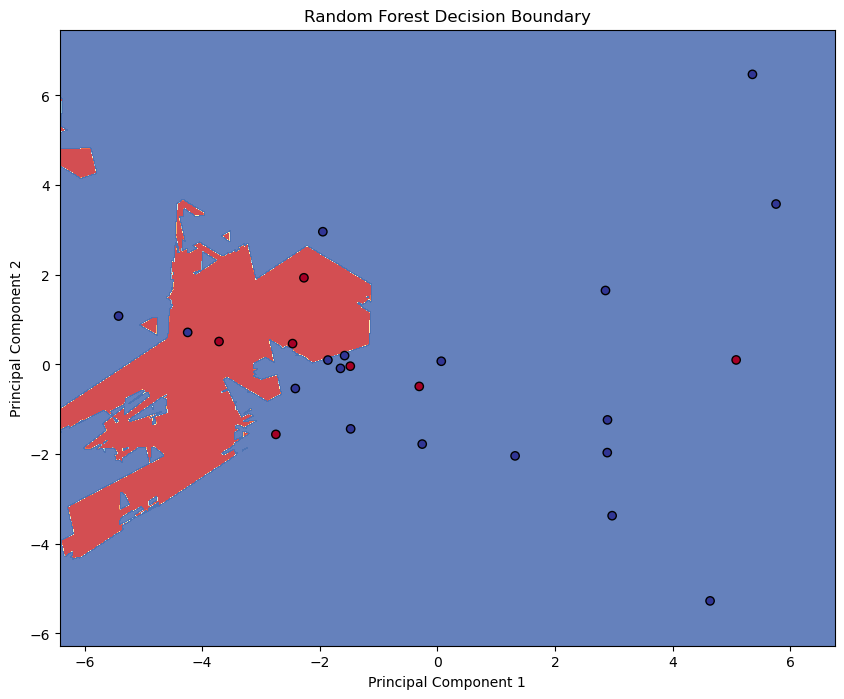

2025-03-29 14:58:06,103 [INFO] Decision boundary plot displayed successfully.
2025-03-29 14:58:06,111 [INFO] 📌 Tuning hyperparameters for Decision Tree...
2025-03-29 14:58:06,112 [INFO] Starting hyperparameter tuning for Decision Tree...
2025-03-29 14:58:06,115 [INFO] Parameter space: {'max_depth': Integer(low=2, high=50, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'), 'criterion': Categorical(categories=('gini', 'entropy'), prior=None), 'splitter': Categorical(categories=('best', 'random'), prior=None)}
c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor3\lib\site-packages\skopt\optimizer\opt

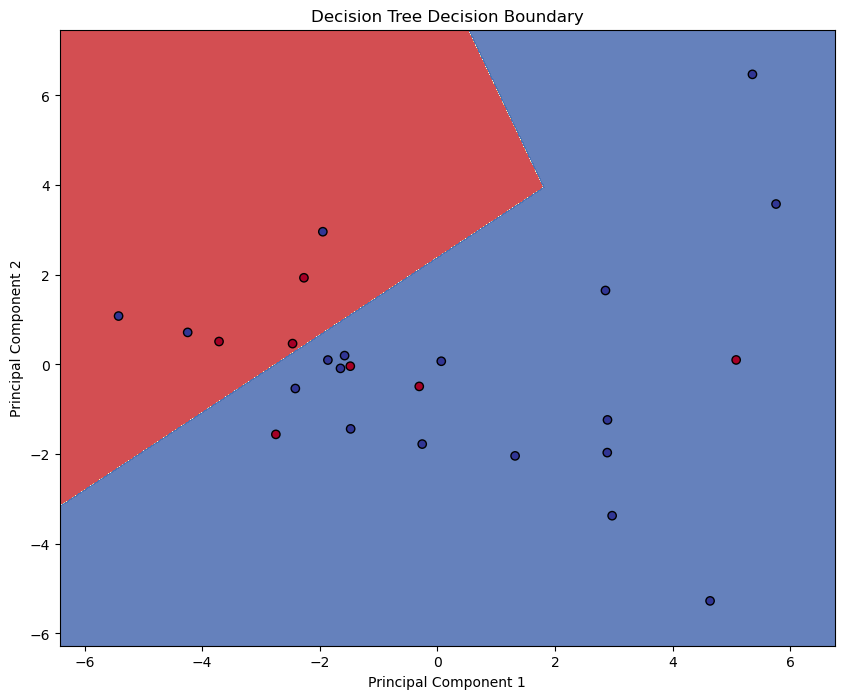

2025-03-29 14:58:56,926 [INFO] Decision boundary plot displayed successfully.
2025-03-29 14:58:56,934 [INFO] ✅ Best model is Random Forest with Log Loss=0.556339506304983
2025-03-29 14:58:56,956 [INFO] Model saved to C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\examples\preprocessor\models\Random_Forest\trained_model.pkl
2025-03-29 14:58:56,957 [INFO] ✅ Model 'Random Forest' saved successfully in 'C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\examples\preprocessor\models'.
2025-03-29 14:58:56,957 [INFO] ✅ Tuning results saved to C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\examples\preprocessor\models\tuning_results.json.
2025-03-29 14:58:56,958 [INFO] [SUCCESS] Training workflow completed successfully.
2025-03-29 14:58:56,958 [INFO] [SUCCESS] Training workflow completed successfully.


In [ ]:
import logging
import json
from typing import Any, Dict
from pathlib import Path
import yaml
import pandas as pd
import joblib  # Ensure joblib is imported

# Local imports - Adjust the import paths based on your project structure
# from datapreprocessor import DataPreprocessor
# from train_utils.train_utils import (
#     evaluate_model, save_model, load_model, plot_decision_boundary,
#     tune_random_forest, tune_xgboost, tune_decision_tree
# )
# from model_factory import get_model

logger = logging.getLogger(__name__)

def load_config(config_path: Path) -> Dict[str, Any]:
    """
    Load configuration from a YAML file.

    Args:
        config_path (Path): Path to the configuration file.

    Returns:
        Dict[str, Any]: Configuration dictionary.
    """
    try:
        with config_path.open('r') as f:
            config = yaml.safe_load(f)
        logger.info(f"✅ Configuration loaded from {config_path}.")
        return config
    except Exception as e:
        logger.error(f"❌ Failed to load configuration: {e}")
        raise

def bayes_best_model_train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    selection_metric: str,
    model_save_dir: Path,
    classification_save_path: Path,
    tuning_results_save: Path,
    selected_models: Any,
    use_pca: bool = False
):
    """
    A streamlined function that:
      1) Tunes and trains models using Bayesian optimization.
      2) Evaluates the best model.
      3) Saves the tuning results and best model.

    Args:
        X_train, y_train: Training features and labels.
        X_test, y_test: Test features and labels.
        selection_metric (str): Metric to select best model (e.g., "Log Loss", "accuracy").
        model_save_dir (Path): Directory to save the best model.
        classification_save_path (Path): Path to save classification report.
        tuning_results_save (Path): Path to save tuning results in JSON format.
        selected_models (list|str): List of models (e.g. ["XGBoost", "Random Forest"]) or a single string.
        use_pca (bool): If True, uses PCA for boundary plotting. Typically False for tree-based models.
    """
    logger.info("Starting the Bayesian hyperparameter tuning process...")

    # Scoring metric selection
    scoring_metric = "neg_log_loss" if selection_metric.lower() == "log loss" else "accuracy"

    # Prepare model registry
    model_registry = {
        # "XGBoost": tune_xgboost,
        "Random Forest": tune_random_forest,
        "Decision Tree": tune_decision_tree
    }

    # Normalize selected_models input
    if isinstance(selected_models, str):
        selected_models = [selected_models]
    elif not selected_models:
        selected_models = list(model_registry.keys())
        logger.info(f"No models specified. Using all available: {selected_models}")

    tuning_results = {}
    best_model_name = None
    best_model = None
    best_metric_value = None

    # Ensure model_save_dir exists
    model_save_dir.mkdir(parents=True, exist_ok=True)
    logger.debug(f"Ensured that the model save directory '{model_save_dir}' exists.")

    # Loop over requested models
    for model_name in selected_models:
        if model_name not in model_registry:
            logger.warning(f"Unsupported model: {model_name}. Skipping.")
            continue
        try:
            logger.info(f"📌 Tuning hyperparameters for {model_name}...")
            tuner_func = model_registry[model_name]

            best_params, best_score, best_estimator = tuner_func(
                X_train, y_train, scoring_metric=scoring_metric
            )
            logger.info(f"✅ {model_name} tuning done. Best Params: {best_params}, Best CV Score: {best_score}")

            # Evaluate on X_test
            metrics = evaluate_model(best_estimator, X_test, y_test, save_path=classification_save_path)
            metric_key = selection_metric.lower().replace(" ", "_")
            metric_value = metrics.get(metric_key)

            if metric_value is not None:
                logger.debug(f"Metric value for {selection_metric}: {metric_value}")
                if best_metric_value is None:
                    best_metric_value = metric_value
                    best_model_name = model_name
                    best_model = best_estimator
                    logger.debug(f"Best model set to {best_model_name} with {selection_metric}={best_metric_value}")
                else:
                    # For log loss, lower is better
                    if selection_metric.lower() == "log loss" and metric_value < best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
                    # For other metrics (accuracy, f1, etc.), higher is better
                    elif selection_metric.lower() != "log loss" and metric_value > best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
            else:
                logger.debug(f"Metric value for {selection_metric} is None. Best model not updated.")

            # Save partial results
            tuning_results[model_name] = {
                "Best Params": best_params,
                "Best CV Score": best_score,
                "Evaluation Metrics": metrics,
            }

            # Plot boundary (optional for tree-based with PCA)
            try:
                plot_decision_boundary(best_estimator, X_test, y_test, f"{model_name} Decision Boundary", use_pca=use_pca)
            except ValueError as e:
                logger.warning(f"Skipping decision boundary plot for {model_name}: {e}")

        except Exception as e:
            logger.error(f"❌ Error tuning {model_name}: {e}")
            continue

    # Save best model information
    if best_model_name:
        logger.info(f"✅ Best model is {best_model_name} with {selection_metric}={best_metric_value}")
        try:
            save_model(best_model, best_model_name, save_dir=model_save_dir)
            logger.info(f"✅ Model '{best_model_name}' saved successfully in '{model_save_dir}'.")
        except Exception as e:
            logger.error(f"❌ Failed to save best model {best_model_name}: {e}")
            raise  # Ensure the exception is propagated

        # Add Best Model info to tuning_results
        tuning_results["Best Model"] = {
            "model_name": best_model_name,
            "metric_value": best_metric_value,
            "path": str(Path(model_save_dir) / best_model_name.replace(" ", "_") / 'trained_model.pkl')
        }
    else:
        logger.warning("⚠️ No best model was selected. Tuning might have failed for all models.")

    # Save tuning results
    try:
        with tuning_results_save.open("w") as f:
            json.dump(tuning_results, f, indent=4)
        logger.info(f"✅ Tuning results saved to {tuning_results_save}.")
    except Exception as e:
        logger.error(f"❌ Error saving tuning results: {e}")


def main():
    # ----------------------------
    # 1. Load Configuration
    # ----------------------------
    config = load_config(Path('../../dataset/test/preprocessor_config/preprocessor_config.yaml'))

    # Extract paths from configuration
    paths_config = config.get('paths', {})
    base_data_dir = Path(paths_config.get('data_dir', '../../dataset/test/data')).resolve()
    raw_data_file = base_data_dir / paths_config.get('raw_data', 'final_ml_dataset.csv')
    processed_data_dir = base_data_dir / paths_config.get('processed_data_dir', 'preprocessor/processed')
    features_metadata_file = base_data_dir / paths_config.get('features_metadata_file', 'features_info/features_metadata.pkl')
    predictions_output_dir = base_data_dir / paths_config.get('predictions_output_dir', 'preprocessor/predictions')
    config_file = Path(paths_config.get('config_file', 'preprocessor_config/preprocessor_config.yaml')).resolve()

    # Output directories
    log_dir = Path(paths_config.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_base_dir = Path(paths_config.get('model_save_base_dir', '../preprocessor/models')).resolve()
    transformers_save_base_dir = Path(paths_config.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()
    plots_output_dir = Path(paths_config.get('plots_output_dir', '../preprocessor/plots')).resolve()
    training_output_dir = Path(paths_config.get('training_output_dir', '../preprocessor/training_output')).resolve()

    # Initialize Paths for saving
    MODEL_SAVE_DIR = model_save_base_dir
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
    CLASSIFICATION_REPORT_PATH = MODEL_SAVE_DIR / "classification_report.txt"
    TUNING_RESULTS_SAVE_PATH = MODEL_SAVE_DIR / "tuning_results.json"


    LOG_FILE = 'training.log'

    SELECTED_MODELS = ["Random Forest"]  # For testing, select a single model
    SELECTION_METRIC = "accuracy"  # Change to "Log Loss" if needed

    # Extract model-related config
    selected_models = config.get('models', {}).get('selected_models', ["XGBoost", "Random Forest", "Decision Tree"])
    selection_metric = config.get('models', {}).get('selection_metric', "Log Loss")

    # Extract Tree Based Classifier options from config
    tree_classifier_options = config.get('models', {}).get('Tree Based Classifier', {})

    # ----------------------------
    # 2. Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, LOG_FILE)
    logger.info("✅ Starting the training module.")

    # ----------------------------
    # 3. Load Data
    # ----------------------------
    try:
        filtered_df = pd.read_csv(raw_data_file)
        logger.info(f"✅ Loaded dataset from {raw_data_file}. Shape: {filtered_df.shape}")
    except FileNotFoundError:
        logger.error(f"❌ Dataset not found at {raw_data_file}.")
        return
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        return

    # Extract feature assets
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    # ----------------------------
    # 4. Initialize DataPreprocessor
    # ----------------------------
    # Assuming a supervised classification use case: "Tree Based Classifier"
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []), 
        mode='train',
        options=tree_classifier_options,  # The options from config for "Tree Based Classifier"
        debug=config.get('logging', {}).get('debug', False),  # or config-based
        normalize_debug=config.get('execution', {}).get('train', {}).get('normalize_debug', False),
        normalize_graphs_output=config.get('execution', {}).get('train', {}).get('normalize_graphs_output', False),
        graphs_output_dir=plots_output_dir,
        transformers_dir=transformers_save_base_dir
    )

    # ----------------------------
    # 5. Execute Preprocessing
    # ----------------------------
    try:
        # Execute preprocessing by passing the entire filtered_df
        X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(filtered_df)
        print("types of all variables starting with X_train", type(X_train), "X_test type", type(X_test), "y_train type =", type(y_train), "y_test type =", type(y_test),"X_test_inverse type =", type(X_test_inverse))
        logger.info(f"✅ Preprocessing complete. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    except Exception as e:
        logger.error(f"❌ Error during preprocessing: {e}")
        return

    # ----------------------------
    # 6. Train & Tune the Model
    # ----------------------------
    try:
        bayes_best_model_train(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            selection_metric=selection_metric,
            model_save_dir=MODEL_SAVE_DIR,
            classification_save_path=CLASSIFICATION_REPORT_PATH,
            tuning_results_save=TUNING_RESULTS_SAVE_PATH,
            selected_models=selected_models,
            use_pca=True  
        )
    except Exception as e:
        logger.error(f"❌ Model training/tuning failed: {e}")
        return

    # ----------------------------
    # 7. Completion Message
    # ----------------------------
    logger.info("✅ Training workflow completed successfully.")

if __name__ == "__main__":
    main()

In [ ]:
# src/ml/predict.py

import pandas as pd
import logging
import os
import yaml
import joblib
import json
from pathlib import Path
from typing import Any, Dict

# Local imports - Adjust based on your project structure
# from train_utils.train_utils import load_model  # Ensure correct import path
# from datapreprocessor.datapreprocessor import DataPreprocessor  # Uncomment and adjust as necessary

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def load_config(config_path: Path) -> Dict[str, Any]:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def setup_logging(log_dir: Path, log_filename: str = 'training.log') -> logging.Logger:
    """Setup logging with proper encoding handling for both file and console output."""
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir / log_filename
    
    logger = logging.getLogger('model_training')
    logger.setLevel(logging.INFO)
    
    # Clear existing handlers to prevent duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()
    
    # Create file handler with UTF-8 encoding
    f_handler = logging.FileHandler(log_path, encoding='utf-8')
    f_handler.setLevel(logging.INFO)
    
    # Create console handler with proper encoding for Windows
    c_handler = logging.StreamHandler()
    c_handler.setLevel(logging.INFO)
    
    # Create formatters and add them to handlers
    # Replace emoji with text alternatives
    class SafeFormatter(logging.Formatter):
        def format(self, record):
            # Replace emojis with text alternatives
            if hasattr(record, 'msg'):
                record.msg = (str(record.msg)
                    .replace('✅', '[SUCCESS]')
                    .replace('❌', '[ERROR]')
                    .replace('⚠️', '[WARNING]'))
            return super().format(record)
    
    formatter = SafeFormatter('%(asctime)s [%(levelname)s] %(message)s')
    f_handler.setFormatter(formatter)
    c_handler.setFormatter(formatter)
    
    # Add handlers to the logger
    logger.addHandler(f_handler)
    logger.addHandler(c_handler)
    
    return logger

def main():
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config_path = Path('../../dataset/test/preprocessor_config/preprocessor_config.yaml')  # Adjust as needed
    try:
        config = load_config(config_path)
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return  # Exit if config loading fails

    # ----------------------------
    # Step 2: Extract Paths from Configuration
    # ----------------------------
    paths = config.get('paths', {})
    data_dir = Path(paths.get('base_data_dir', '../../dataset/test/data')).resolve()
    raw_data_path = data_dir / paths.get('raw_data_file', 'final_ml_dataset.csv')  # Corrected key
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'preprocessor/processed')
    transformers_dir = Path(paths.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()  # Corrected key
    predictions_output_dir = Path(paths.get('predictions_output_dir', 'preprocessor/predictions')).resolve()
    log_dir = Path(paths.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_dir = Path(paths.get('model_save_base_dir', '../preprocessor/models')).resolve()  # Corrected key
    log_file = paths.get('log_file', 'prediction.log')  # Ensure this key exists in config

    # ----------------------------
    # Step 3: Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, log_file)
    logger.info("✅ Starting prediction module.")

    # ----------------------------
    # Step 4: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    # ----------------------------
    # Step 5: Load Tuning Results to Find Best Model
    # ----------------------------
    tuning_results_path = model_save_dir / "tuning_results.json"
    if not tuning_results_path.exists():
        logger.error(f"❌ Tuning results not found at '{tuning_results_path}'. Cannot determine the best model.")
        return

    try:
        with open(tuning_results_path, 'r') as f:
            tuning_results = json.load(f)
        best_model_info = tuning_results.get("Best Model")
        if not best_model_info:
            logger.error("❌ Best model information not found in tuning results.")
            return
        best_model_name = best_model_info.get("model_name")
        if not best_model_name:
            logger.error("❌ Best model name not found in tuning results.")
            return
        logger.info(f"Best model identified: {best_model_name}")
    except Exception as e:
        logger.error(f"❌ Failed to load tuning results: {e}")
        return

    # ----------------------------
    # Step 6: Preprocess the Data
    # ----------------------------
    # Load Prediction Dataset
    if not raw_data_path.exists():
        logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
        return

    try:
        df_predict = load_dataset(raw_data_path)
        logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",  # Or dynamically set based on best_model_name if necessary
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []),
        mode='predict',
        options={},  # Adjust based on config or load from somewhere
        debug=False,  # Can be parameterized
        normalize_debug=False,  # As per hardcoded paths
        normalize_graphs_output=False,  # As per hardcoded paths
        graphs_output_dir=Path(paths.get('plots_output_dir', '../preprocessor/plots')).resolve(),
        transformers_dir=transformers_dir
    )

    # Execute Preprocessing for Prediction
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
        print("X_new_preprocessed type = ", type(X_preprocessed), "X_new_inverse type = ", type(X_inversed))
        logger.info("✅ Preprocessing completed successfully in predict mode.")
    except Exception as e:
        logger.error(f"❌ Preprocessing failed in predict mode: {e}")
        return

    # ----------------------------
    # Step 7: Load the Best Model
    # ----------------------------
    try:
        trained_model = load_model(best_model_name, model_save_dir)
        logger.info(f"✅ Trained model loaded from '{model_save_dir / best_model_name.replace(' ', '_') / 'trained_model.pkl'}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load the best model '{best_model_name}': {e}")
        return

    # ----------------------------
    # Step 8: Make Predictions
    # ----------------------------
    try:
        predictions = trained_model.predict(X_preprocessed)
        logger.info("✅ Predictions made successfully.")
    except Exception as e:
        logger.error(f"❌ Prediction failed: {e}")
        return

    # ----------------------------
    # Step 9: Attach Predictions to Inversed Data
    # ----------------------------
    if X_inversed is not None:
        if len(predictions) == len(X_inversed):
            X_inversed['predictions'] = predictions
            logger.info("✅ Predictions attached to inversed data successfully.")
        else:
            logger.error("❌ Predictions length does not match inversed data length.")
            return
    else:
        logger.error("❌ Inversed data is None. Cannot attach predictions.")
        return

    # ----------------------------
    # Step 10: Save Predictions
    # ----------------------------
    try:
        predictions_output_dir.mkdir(parents=True, exist_ok=True)
        predictions_filename = predictions_output_dir / f'predictions_{best_model_name.replace(" ", "_")}.csv'
        X_inversed.to_csv(predictions_filename, index=False)
        logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
    except Exception as e:
        logger.error(f"❌ Failed to save predictions: {e}")
        return

    logger.info(f"✅ All prediction tasks completed successfully for model '{best_model_name}'.")


if __name__ == "__main__":
    main()

2025-03-29 14:58:57,005 [INFO] [SUCCESS] Starting prediction module.
2025-03-29 14:58:57,005 [INFO] [SUCCESS] Starting prediction module.
2025-03-29 14:58:57,014 [INFO] Best model identified: Random Forest
2025-03-29 14:58:57,014 [INFO] Best model identified: Random Forest
2025-03-29 14:58:57,022 [INFO] [SUCCESS] Prediction input data loaded from 'C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv'.
2025-03-29 14:58:57,022 [INFO] [SUCCESS] Prediction input data loaded from 'C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv'.
2025-03-29 14:58:57,024 [INFO] DTW/pad mode detected: Horizon will be updated dynamically based on computed sequence length.
2025-03-29 14:58:57,024 [INFO] DTW/pad mode detected: Horizon will be updated dynamically based on computed sequence length.
2025-03-29 14:58:57,024 [INFO] Prediction mode detected. Automatically loading transformers from 'C:\Users\ghadf\vsc

X_new_preprocessed type =  <class 'pandas.core.frame.DataFrame'> X_new_inverse type =  <class 'pandas.core.frame.DataFrame'>
